# Geometry Constrained Feature Matching

In [9]:
import numpy as np 
import random
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import os
import sys
import itertools as it
import cv2

In [10]:
os.getcwd()

'C:\\Users\\G531\\Documents\\8 - Github\\ComputerVision\\9-Geometry Constrain Feature Matching'

In [11]:
d = np.load('Ftrue.npy', allow_pickle=True).item()  # Dicctionary
qs= np.load('qs.npy', allow_pickle=True).item()

In [12]:
qs.keys()

dict_keys(['q1', 'q2'])

In [66]:
q1 = qs['q1'] # 2d points in homogenous form 3x8
q2 = qs['q2'] # 2d points in homogenous form 3x8

In [14]:
im1 = d['im1']
im2 = d['im2']
R1 = d['R1']
R2 = d['R2']
t1 = np.squeeze(d['t1'] )
t2 = np.squeeze(d['t2'])
K = d['K']

In [15]:
def crossOp(v):
    """
    v: is a vector, should it be in column vector 
    """
    crossv = np.matrix(np.array([[0, -v[2], v[1]],[v[2], 0, -v[0]], [-v[1], v[0], 0]]))
    return crossv

In [16]:
def fundmat(K1, K2, t1, R1):
    """
    K1, K2: Camera Matrices, 
    t1: translation vector camera 1
    R1: Rotation matrix camera 1
    Returns: Fundamental matrix 
    """
    # check the shape of the matrices
    if t1.shape == (3,1):
        pass
    else:
        t1 = t1.T
    
    # Compute the inverses
    K1_inv, K2_inv = np.linalg.inv(K1), np.linalg.inv(K2)
    # Compute essential matrix 
    E = crossOp(t1)@R1
    F = K2_inv.T @ E @ K1_inv
    return F

In [17]:
F = fundmat(K,K,t2,R2)

In [18]:
def estF_8point(q1, q2, scale:bool=None)->np.array:
    """
    Given two sets of points in 2D in homogenous form (3,1) from two different images taken with the same camera, 
    we estimate the Fundamental Matrix of the camera.
    
    It applies kronoker product two the pair of points to create the B matrix
    PARAMETERS:
    q1 --> Collection of 2d points on homogenous form [x, y, 1] -- > (3,n)
    q2 --> Collection of 2d points on homogenous form [(3,n)
    
    RETURNS:
    F --> Estimation of the fundamental matrix. 
    """
    
    # Check if we have the same amount of points
    if q1.shape != q2.shape:
        print('q1 and q2 should store the same amount of points')
        return False 
    elif q1.shape[0] != 3:
        print('Make sure your collection of points is in homogenous form')
        return False
    
    
    # Create the B matrix with the Kronecker product, initialize it for faster computation:
    n = q1.shape[0]*q2.shape[0]
    B = np.zeros((q1.shape[1], n))
    
    # Loop trhoug each point and apply kronoker product to the pair of points
    for i in range(q1.shape[1]):
        B[i,:] = np.kron(q1[:,i],q2[:,i])
    
   
    # Apply singular value decomposition to obtain the eigenvectors
    _, s, eigVec = np.linalg.svd(B)
    
    # BUG: Instead of the last one, the np.where select the penultimate eigenvector not the last one. the  eigenvalues have 
#     8 valuesinetad of 9, selects the last one but it's not the corresponing 

#     # Find Min 
#     idx = np.where(s==min(s))
#     # Select the eigenvector correspondent to the eigenvalue
#     F_vec = eigVec[idx,:]
    F_vec = eigVec[-1,:]
    
    # Reshape to 3x3
    F_esti= F_vec.reshape((3,3),order='F')
    
    # Option scale it
    if scale:
        F_esti = F_esti/F_esti[-1,-1]
        return F_esti

    return F_esti

In [22]:
F_est = estF_8point(q1, q2)
F_est

array([[-3.07914555e-08,  3.61883689e-06, -5.43583727e-04],
       [ 4.49876682e-06,  2.24402705e-08, -1.51520136e-01],
       [-1.95223414e-03,  1.48295604e-01,  9.77264527e-01]])

It's nor probable that we obtain the same Fundamental matrix, so we have to check if the values of the estmated fundamental matrix are scaled. In order to compare them. A good result will be that all the values are scaled by the same factor. <br>
**Scale:**

In [34]:
s = F/F_est
F_scale = F_est*s[0,0]
F_scale

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

Estimated Matrix scaled with the scale factor from above

In [61]:
print('Estimated Fundamental Matrix scaled\n')
print(F_scale)
print('\nFundamental Matrix\n')
print(F)

Estimated Fundamental Matrix scaled

[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]

Fundamental Matrix

[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]


Check the Fundamental matix and the Estimation of the matrix. Compute the Error between both matrices

In [39]:
print('Original Fundamental Matrix: \n', F)
print('\nThe estimated Fundamental Matrix is: \n', F_est)
print('\nThe scale between the matrices is: \n', F/F_est)
print('As all the elements of the matrix have the same value we can be sure that it is being compute correctly')
print('\nThe error between the matrices is: \n', F-F_scale)

Original Fundamental Matrix: 
 [[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]

The estimated Fundamental Matrix is: 
 [[-3.07914555e-08  3.61883689e-06 -5.43583727e-04]
 [ 4.49876682e-06  2.24402705e-08 -1.51520136e-01]
 [-1.95223414e-03  1.48295604e-01  9.77264527e-01]]

The scale between the matrices is: 
 [[-0.00021693 -0.00021693 -0.00021693]
 [-0.00021693 -0.00021693 -0.00021693]
 [-0.00021693 -0.00021693 -0.00021693]]
As all the elements of the matrix have the same value we can be sure that it is being compute correctly

The error between the matrices is: 
 [[ 0.00000000e+00  8.54755712e-20 -1.68653127e-17]
 [ 8.48726600e-20  3.44452063e-22 -3.12344416e-15]
 [-3.62243698e-17  3.05707743e-15  2.00960396e-14]]


### Find the matiching points from two images 

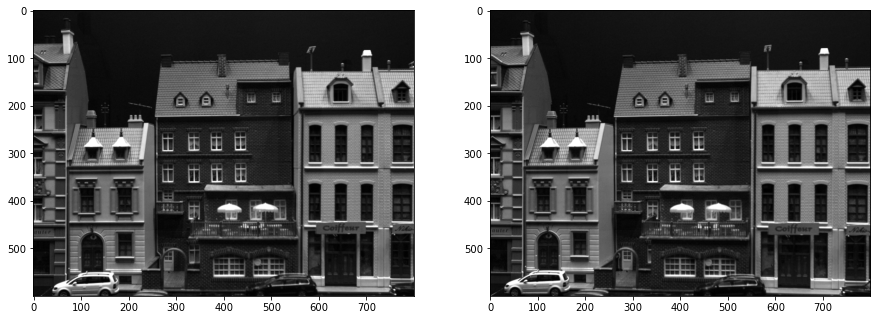

In [149]:
I1 = d['im1']
I2 = d['im2']
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(I1, cmap='gray')
ax[1].imshow(I2, cmap='gray')

#### Use cv2 to detect SIFT features

In [150]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

# BFMatcher with default params, Find the keypoints 
# For each descriptor in the first set, this matcher finds the closest descriptor in
# the second set by trying each one. This descriptor matcher supports masking permissible 
# matches of descriptor sets.
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(des1,des2)
     
print('Number of matches:',len(matches))

Number of matches: 2086


#### Visualize the number of matches with cv2 

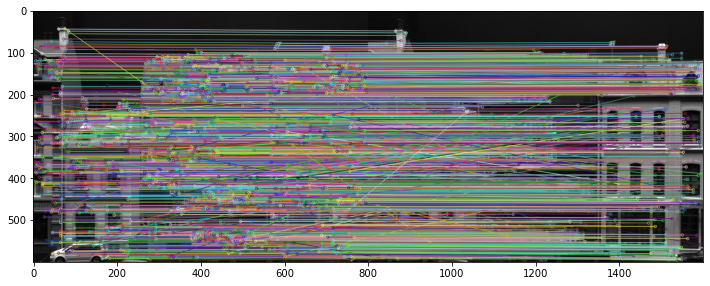

In [151]:
img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches, None, flags=2)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img3)

### Convert matches into points
https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python

In [152]:
# Initialize lists
list_kp1 = []
list_kp2 = []

# For each match...
for mat in matches:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx # The index or row of the kp1 interest point matrix that matches
    img2_idx = mat.trainIdx # The index or row of the kp2 interest point matrix that matches

    # x - columns
    # y - rows
    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))

In [153]:
def select_8_points(matches, num_pairs:int=None)->list:
    """
    Given the matches from cv2.BFMatcher, we select a number of pairs
    
    PARAMETERS:
    Matches-> cv2.DMatch objects
    num_pair_points -> number of pair points we want to select on both images
    
    RETURNS:
    im1_points: List of tuples containing the coordinates from the points. [(x1, y1), (x2, y2), ..., (xn, yn)]
    im2_points: List of tuples containing the coordinates from the points. [(x1, y1), (x2, y2), ..., (xn, yn)]
    """
    
    if num_pairs:
        # Select n number of pairs random matches 
        matches_tmp = np.random.choice(matches, num_pairs, replace=False)
        
        # Initialize arrays 
        list_kp1 = np.zeros((3, num_pairs))
        list_kp2 = np.zeros((3, num_pairs))
    else: 
        
        matches_tmp = matches
        # Initialize arrays 
        list_kp1 = np.zeros((3, len(matches)))
        list_kp2 = np.zeros((3, len(matches)))

    
    # Convert the match DMatch object into points 
    
    # For each match...
    for i, mat in enumerate(matches_tmp):

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx # The index or row of the kp1 interest point matrix that matches
        img2_idx = mat.trainIdx # The index or row of the kp2 interest point matrix that matches

        # x - columns
        # y - rows
        # Get the coordinates
        point_im1 = np.r_[np.array(kp1[img1_idx].pt), 1]
        point_im2 = np.r_[np.array(kp2[img2_idx].pt), 1]

        # Append to each list
        list_kp1[:,i] = point_im1
        list_kp2[:,i] = point_im2
    
    return list_kp1, list_kp2
    

In [154]:
points1, points2 = select_8_points(matches, num_pairs=8)

In [155]:
points1.T

array([[344.83621216, 172.48274231,   1.        ],
       [369.95620728, 105.51016235,   1.        ],
       [272.07174683, 118.87493896,   1.        ],
       [230.66297913, 237.17408752,   1.        ],
       [606.18572998, 379.97219849,   1.        ],
       [422.33480835, 171.42398071,   1.        ],
       [ 47.24268723, 184.90516663,   1.        ],
       [184.89183044, 277.75622559,   1.        ]])

In [156]:
F_est2 = estF_8point(points1, points2)

We can see that with 8 random points we don't obtain a good estimation of the fundamental matrix. 

In [157]:
F_est2

array([[ 6.52554545e-06, -9.64399316e-05,  4.68238949e-02],
       [ 1.10189644e-04,  9.29642591e-06, -1.22537868e-01],
       [-5.31670616e-02,  1.17597596e-01,  9.82922195e-01]])

In [158]:
def sampsons_distance(F, p1, p2)->int:
    """
    Computes the Sampson's distance for each pair of points 
    (q2.T*F*q1)^2/(q2.T*F)^2[x] + (q2.T*F)^2[y] + (q1.T*F)^2[x] + (q1.T*F)^2[y]
    
    PARAMETERS
    F-> Fundamental Matrix (3,3)
    p1 -> point from 1 image in homogenous coordinates (3,1)
    p2 -> point from 1 image in homogenous coordinates (3,1)
    
    RETURNS
    d-> distance from the the point to the epipolar lines, integer 
    """
    try:
        if p1.shape != p2.shape:
            print('Shapes does not coincide')
            print(p1)
            print(p2)
            return False
        elif p1.shape != (3,1):
            print('Not in homogenoius form')
            print(p1)
            print(p2)
            return False
        else:
            pass
    except:
        return False

    # Calculate the numerator:
    numerator = ((p2.T@F@p1)**2)[0,0]
        
    # Calculate the first part of the denominator with p1 
    denominator_p2 = np.sum(np.array((p2.T@F))[0,:2]**2)
    
    # Denominator p1 
    denominator_p1 = np.sum(np.array(F@p1)[:2,0]**2)
    
    dsamp = numerator/(denominator_p2 + denominator_p1)
    
    return dsamp

In [160]:
points1.T

array([[344.83621216, 172.48274231,   1.        ],
       [369.95620728, 105.51016235,   1.        ],
       [272.07174683, 118.87493896,   1.        ],
       [230.66297913, 237.17408752,   1.        ],
       [606.18572998, 379.97219849,   1.        ],
       [422.33480835, 171.42398071,   1.        ],
       [ 47.24268723, 184.90516663,   1.        ],
       [184.89183044, 277.75622559,   1.        ]])

In [170]:
for i,j  in zip(points1.T, points2.T):
    print(sampsons_distance(F_est2, i.reshape(-1,1), j.reshape(-1,1)))
    print(is_inlier(F_est2, i.reshape(-1,1), j.reshape(-1,1)))

1.9435320019925027e-28
True
1.9811118396182353e-25
True
5.999967308137998e-25
True
1.0752647623795714e-25
True
1.1519848550010202e-25
True
2.0121676120071123e-25
True
0.0
True
9.452844736867856e-27
True


In [178]:
Q1, Q2 = select_8_points(matches)

In [179]:
p,g, n = num_inliers(Q1, Q2, F_est2)
n

2.3450317425822487
2.4741838517812678
3015.5278094700875
21.797568770812862
15.810611150442465
0.6489789067514176
2.1227686096573626
11.51886270528459
13.226548341191503
31.646634448696634
22.970989454666217
16.270150397060313
6.667899425395902
2.57584606625879
8.973794888363512
5.199041200908877
12.190065908600515
0.5292432632498374
1.1250630249286842
0.5072847667187087
30.828683753905693
9.323940122603856
15.127237064072816
11.167545034136003
0.4991261400416134
18.059083737353017
0.42322222225818945
3.755639993298712
5.5684998643642025
5.5684998643642025
3.479717900272743
1.262143056008463
13.28121598437571
13.28121598437571
0.6105309885812649
0.38444855416091694
0.31049102899205744
0.17086176754829485
7.769392415490052
2.8926589785363874
31.49244631628396
22.548821380174374
4.772903719640219
1.044755987255101
0.07707899091898059
3.8381937063528206
21.337218449001647
25.317532435166523
1.7289264000480729
0.10900363992319684
2.394264075782618
9.075317899424613
9.075317899424613
3.2495

537.7103846469049
512.6466176016088
512.6466176016088
0.5767840677440349
208.47318997298424
573.3774949965598
573.3774949965598
29.99500682197141
0.8490955879918949
1.6325391263294236
0.11638156724573324
10004.2244052408
0.10411614193142851
19514.128114918403
266.2713256349293
301.2918071227891
521.5356842119177
542.2758148568587
542.2758148568587
0.582121893121005
576.1239534782986
576.1239534782986
294.947291800792
1.3727434402094056
0.21712437927869274
0.4224604984845307
0.17262478797276312
0.17262478797276312
0.8638305882288582
505.67809764709136
568.5441528499375
568.5441528499375
628.9621057425757
539.2284238457111
89.43090379058803
60.79474266247496
601.3898600698919
601.3898600698919
214.6368447926705
1.7152735360182374
1.7152735360182374
0.17631490415185988
0.17631490415185988
2.288393399988696
8.015242010292651
0.21931996486053415
0.047888201565425496
563.7512519148245
593.1858754323176
537.1314160742257
233.92258325690506
135.60961339055143
285.4859089389292
285.485908938929

848

In [180]:
n

848

In [124]:
p1 = points1[:,0].reshape(-1,1)
p2 = points2[:,0].reshape(-1,1)

In [125]:
q1_p = q1[:,0].reshape(-1,1)
q2_p = q2[:,0].reshape(-1,1)
q1_p

array([[192.80308677],
       [482.655306  ],
       [  1.        ]])

In [126]:
dsamp = sampsons_distance(F, q1_p, q2_p)
dsamp

1.428214067015515e-27

In [127]:
F

matrix([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
        [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
        [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

In [165]:
def is_inlier(F:np.matrix, p1:np.array, p2:np.array, thresh:float=34.56)-> bool:
    """
    Calculates if a given point is an inlier. The distance is calculated with the Sampsons' equation. The threshold is
    set to: 3.84 * 3^2
    
        PARAMETERS:
    F  -> Fundamental Matrix. (3,3)
    p1 -> Point 1 from 1st Image. In Homogenous form (3,1)-> [x, y, 1]
    p2 -> Point 1 from 2nd Image. In Homogenous form (3,1)-> [x, y, 1]
    thresh -> Threshold to determinate if the point is an inlier or not 
    
    RETURNS:
    boolean, True if the point is an inlier False otherwise
    """
    
    dSamps = sampsons_distance(F, p1, p2)
    
    return dSamps<thresh

In [172]:
def num_inliers(P1,P2, F:np.matrix, thresh:float=34.56, *args)->int:
    """
    Given a Fundamental matrix and a DMatch object, calculates from all the matching points stored at the object 
    which of those are inliers given a threshold and the Sampsons' distance.
    
    PARAMETERS:
    matches -> RMatch object
    F       -> Fundamental Matrix, (3,3)
    thresh  -> Threshold to determinate if the point is an inlier or not 
    
    RETURNS:
    Integer, number of inliers.
    """
    
    
        
    # Transorm all match objects into poits:
#     P1, P2 = select_8_points(matches)
    
    # Initialize list to store the inliers and the counter
    p1_inliers = []
    p2_inliers = []
    n_inliers = 0 
    
    # Calculate for each point if it's an inlier and if it's, store the point and add 1 to the counter.
    for i in range(P1.shape[1]):
        p1 = P1[:,i].reshape(-1,1)
        p2 = P2[:,i].reshape(-1,1)
        
        print(sampsons_distance(F,p1,p2))
        
        # check if it's inlier.        
        if is_inlier(F, p1, p2, thresh=thresh):
            p1_inliers.append(p1) 
            p2_inliers.append(p2)
            n_inliers += 1
    
    return p1_inliers, p2_inliers, n_inliers

In [147]:
a, b, c = num_inliers(matches, F_est2)
c

80.12744205143318
82.38587468515482
58252.29418725989
3.1176744565162307
2.097630163145338
88.45841909340857
72.14881619928013
15.239686759917962
8.183456693953893
43.585208011002045
5.239499156013528
1.1789666102691645
38.71451047884194
58.85563673740039
26.57956908454558
46.783208148758035
10.897068100156151
49.87060038463584
42.769625199484864
80.64871418703827
35.885826907855055
22.098088013366585
1.5109234515595842
8.004341661617424
39.80702327687195
0.17621102712749456
26.999942339383125
55.64977806819584
45.917488107943186
45.917488107943186
45.41332072736683
52.03364883840443
5.535233209856814
5.535233209856814
28.30485324628582
141.81462974266543
491.4703450760356
291.1900956420719
21.140699525307426
55.30585644602511
47.062323359930886
7.71178754012705
43.39117871746382
51.39348087871352
17.91685008315049
41.15293431258823
6.40294195872406
11.971463741829341
56.59105322003814
16.552268622138666
723.1540995165209
14.975001739563847
14.975001739563847
796.4083600697069
0.530819

72.1807811460328
103.77647907810608
436.44057288764077
45.976545930538926
200.28420320064092
3056.9377945045826
99.85475164469376
85.74991295682973
3.8177116814555805
0.15061203496362355
0.15061203496362355
177.59635544899447
119.08572452559035
76.02104785424167
45.70466881403037
172.68453536508773
93.6770405781217
110.31676653904984
1848.631855828609
5102.911266336285
257.00798566490676
213.01735084490937
8043.274744060978
182.0230077490638
96.91449508704191
85.32444933284717
80.16254674390716
106.70791021045967
2962.7278909331467
184.379341291859
11.222355327064102
136.0705787032594
0.1977045321472596
0.1977045321472596
66.81976280037946
20.487171160281974
92.24140411568298
92.24140411568298
10582.783503466624
127.64305010140694
509.0258745120207
221.959809864708
64.7997597376175
5.7289343862086435
209.10262840089385
131.01669692071889
99.05836301356113
309.1578654059968
309.1578654059968
100.3399805562146
193.27868920715903
4319.321337574413
2927.4981789167346
85.48426498258456
125.

545

In [148]:
c

545

In [140]:
3.84*(3**2)

34.56

### What is really computing the Ransac Algorithm?
In an ideal world we would have the Fundamental Matrix that makes the correspondence with p1 and q1. Being p1 and q1 to points on diferent images (2d) that correspond to the same point in 3D. As both images have been taken with the same camera, we should know the intrinsics and we would be able to locate this 3d vector perfectly on each image. The problem is that we don't know the pole of the cameras (the translation and rotation within respect the other camera) so we don't know the fundamental matrix. <br>
Recall:
$$E =  [t]_x * R$$

$$F  = K_2^{-T}*E*K_1^{-1}$$ <br> 

In order to estimate the best Fundamental matrix, we have to estimate the fundamental Matix with all possible combinations of the matching points between the 2 images. We'll chose the best one using Ransac algorithm. Computing the Error (Distance between the points once we have the fundamental matrix). <br>
<b> Are we computing the ditance between this points in 3D or in 2D?



In [175]:
def ransac(matches, n_iter, thresh:float=34.56):
    """
    Given a match object and a threshold, calculates the best Fundamental matrix calculating how many 
    inliers lie within the specified threshold.
    
    The distance is calculated with Sampsons' distance.
    
    PARAMETERS:
    Matches:-> DMatch object 
    n_iter  -> Number of iterations 
    thresh  -> Threshold for inliers 
    
    RETURNS:
    N_opt -> The number of inliers with the optimal fundamental matrix.
    F_opt -> The Optimal Fundamental Matrix (the one that has more inliers)
    P1_inliers_opt -> The points that are inliers on Image 1
    P2_inliers_opt -> The points that are inliers on Image 2 
    
    """
    # Initialize best Fundamental Matrix
    F_opt = None
    # Initialize the number of inliers 
    N_opt = 0 
    P1_inliers_opt = None 
    P2_inliers_opt = None 
    # Tranform the matching object into points.
    Q1, Q2 = select_8_points(matches)
    
    for i in range(n_iter):
        
        # Select 8 random points from the match object 
        q1_8random, q2_8random = select_8_points(matches, num_pairs=8)
        
        # Estimate the Fundamental Matrix
        F_est_al = estF_8point(q1_8random, q2_8random)
                
        # Calculate the number of inliers given a thrashold 
        p1_inliers, p2_inliers, n_inliers = num_inliers(Q1, Q2, F_est_al, thresh)
        
        # Check if the number of inliers is bigger than the optimal number since here
        if n_inliers > N_opt:
            N_opt = n_inliers
            F_opt = F_est 
            P1_inliers_opt, P2_inliers_opt = p1_inliers, p2_inliers
                        
    return N_opt, F_opt, P1_inliers_opt, P2_inliers_opt

In [176]:
N_opt, F_opt, P1_inliers_opt, P2_inliers_opt = ransac(matches, 100)

0.00017556811436500208
3.834399831823637e-05
11512.036920785318
0.025112211235610336
0.011638755144178569
0.005211688213607115
0.015424384762495441
0.001971264199559286
0.0028456771859445163
0.07189242900808826
0.012518440491389681
0.011138536380283112
0.005740550836351221
0.08998725449492564
7.975148500148421e-27
0.014358011917157116
0.00474976008024048
0.00016398550363182123
0.0021918374609643052
0.0069605547019694425
0.03353935587096571
0.0002842954886855661
0.015157547548434675
0.03623519580568307
0.005752625637061792
0.024678572699377198
0.016159344823517118
0.0010649259305419768
0.008477480790373448
0.008477480790373448
0.07453437420412655
0.001637163460795864
0.001876289997360939
0.001876289997360939
0.009011651300675438
0.0002656085095990025
0.046466731219545414
0.01452186769813482
0.011979271367823029
0.000861550882959001
0.0876932798167028
0.031630070154547184
9.433582154445965e-08
0.00025223092266546767
0.026806400963798598
0.03445846741871865
0.04222010668099975
0.003266639

0.011183010193386486
0.07955294014077918
0.05285746408708634
0.006577723036376415
57.11343402016188
0.0010998252033347592
0.01832039474954996
0.004618835145121738
43.260418797946244
0.1772415367712467
0.34647165573719746
4.09579947586757
0.03826873302933838
0.03826873302933838
0.0038735243931241814
51.47589964007198
0.007584542183577349
0.07068099760931983
0.0006711117364082578
2940.754691624808
0.003112400026542322
0.024674141545226496
0.022116755882399478
38.49759610950146
0.0005054521863708211
0.0019991711203414236
0.006209153327607977
0.13628383111346992
0.040376165587287544
0.04711466318111636
0.0957292990971254
0.009578999552297476
0.1613536736505761
0.051801482584193766
0.03879297063584584
0.004670167215692713
1.3306187003465217e-06
1.3306187003465217e-06
0.009142006803220264
0.038413036048210905
0.00012105284381086654
0.0003147083534692842
0.008817855961474247
0.0033320426718216776
8.378237376831044e-07
0.0012171143166147375
0.10463882318877621
6.436875883913174
0.0044836427913

1.7192226651142677
5.1036155274984045
4.756741841796385
5.904187371429495
6.097033539530443
0.8051606802869017
11.490037623302428
13.628631964004919
2.6991442685013745
1.8697067165797703
3.8629869371897154
0.12504733022662268
0.014582585497536858
0.6641765834624115
49.38917474816932
684.8084540431813
4.7687411823464805
11.780663207078684
12.205696400146612
2.5068218919598277
18.4928776887913
18.4928776887913
4.848816126896752
10.99317290302769
0.8888123579421857
0.8482917637576347
0.8482917637576347
11.734413894762262
151584.30192395466
0.5703597481469043
0.5703597481469043
0.28437315442483296
5.686911358094138
5.686911358094138
1.0883182985514552
104.90294917739939
0.36438606929600226
5.967109406186343
15934.249630295026
24.24566358308204
1.1350271399269514
25.359299200430062
1.8536852504514663
0.8878477017457953
0.556118383266973
5.808425629690506
0.3705806424602948
0.3136748966088998
1.8588696993631482
5.474367154228986
18263.181858159976
0.4353387285877735
1.3151454739703854
0.1487

0.01811598047898696
0.02758493602943686
0.02758493602943686
0.02710368073658655
30.27441722583673
0.003433626151104301
11.512799116270314
0.005841917422563496
0.028543844446575616
0.04092880401051964
0.04696112358812621
0.04696112358812621
0.006487174299836201
0.006487174299836201
0.014118417695064594
10.297565417272828
531.8048414007555
9.921769752962687
6.825879563644657
8.507492935462906
0.0033395666108160375
0.055436082506288197
1.1466900342345825
8.793140741085328
0.0825931582254544
0.014965139176825543
0.2969395069444809
223.2582567064981
1.3137829371093888
0.01300737748281689
0.040565443188545214
0.040565443188545214
0.021120715646701788
0.021120715646701788
0.0404201847843998
0.049469262908134935
11.574567641795552
0.2028788322259976
0.12194235128100407
2666.6671059296473
4.128297948721293
11.653824405302393
4.701606988173658
8.626173977924187
2.074206311819241
0.00015944462318377394
0.04582249607475711
0.04582249607475711
0.012093055733699546
0.040836557953490976
0.04083655795

1394.258818962656
921.02444257313
3759.3118143643555
3693.9116234712014
605.5006069596127
3692.307804293987
4121.8052604024115
3.3796258837396707
1020.1626540850026
63.06938730441482
1.551692503801075e-22
1.551692503801075e-22
825.8417629876335
878.5179572541226
7.705798316356181
0.0795113733689398
2.5544861928733544
5.3749416414864575
4676.759458785251
0.4564952494647303
2.284648628422608
5311.1156635865145
0.7644684337726604
0.7644684337726604
511.77008718389766
0.050121727405270794
10328.126154233432
11505.458273849159
18.838699139887567
5808.819301246154
20.060865674071792
9.809574174178476
8720.750698585054
5179.693196411327
2869.3065910227547
1374.6871687853138
3463.791468354385
319.8149470627565
319.8149470627565
1507.8963737643617
1507.8963737643617
18124.45111534673
1122.0363079964507
1122.0363079964507
10791.927857378376
2418.661081607432
2061.462577310581
31.373865003636748
12.733313810128744
1841.835595100751
1756.8040044084971
388.48348788562555
732.1048958724946
1901.4065

118.06529526704873
109.29452617355886
131.00984417164042
10.808681564947664
363.1146224146324
7.173201625588821
450.5188523005584
450.5188523005584
4.620250482993986
7.388277065224241
319.3423610705856
338.83425349527283
303.0056369835805
534.6735199949658
328.4500531981969
314.2424458134861
361.50489041704634
7.3856414293500015
7.3856414293500015
376.9028482170455
335.4754832142495
23.43703296355879
322.9293529197072
7.901351293623961
7.901351293623961
7.529647323988722
7.529647323988722
457.5907742167277
59386.8795467909
522.0103367151929
387.18031597477847
387.18031597477847
6.894895493455716
6.894895493455716
7.196137190752823
9.805218428130985
95021.37762696849
488.8393938579125
7.5470986649244995
74.47967268912723
510.92161052154125
439.8326597491232
18.327927188167486
23.319739352728355
5752.038891503261
8352.916087916372
7855.518460891803
8614.76951186749
110.03101390901361
670.5856503784537
7.995027809399099
352.11129388380357
327.0366213652001
19.624828830550207
534.663590880

1493.9455994738112
102.679551026437
4.534215194445579
18.429816546069528
18.429816546069528
201.85010666019625
0.0642883822303924
0.014277474872008433
324.84900053915885
19.539790423192127
19.539790423192127
9.224126534229422
4.415712654452622
0.07758695127078917
2386.878695386556
8.364041055020401
8.783800345570004
7.8619361320302845
3.225871976485453
0.7925231805577452
0.523258658859334
0.14775314266726097
0.341661928937164
243.59690278587942
32.85191509450443
10.198372019659088
3.7797928840440216
8.117991511297348
33.714005032899195
9.322527152829391
17.65736564359022
1.3674598020935675
17.63798316477241
17.63798316477241
54781.517964510705
31.634164779713014
10.34171052901916
7.485242076327294
10.638456524266966
8.75325116114009
9.77036042328882
2.4848667561566087
1.2147672624601218
19.835996453404594
23.609780785246816
3.4011200791489666
1.4673241933260261
9.312725062078952
9.312725062078952
44079.530585122026
6.951021887013171
6.951021887013171
10.227718247301123
37.1047900614366

2.929012810087768
295.37241927483126
0.23878772800428955
1455.9445711092287
14.385581277834884
1.5721513161080578
0.8573945008582499
215.27619690187018
200.2096932697876
161.93376817391427
0.011810588018694723
172.79895768099166
141.11778687790144
82.18604135059532
0.19638793895559328
258.9989857534416
23.364506117487913
16849.907666052713
207.0753793122196
0.048003444897338786
6.34691213681907
0.5732307076563565
0.006099488498143736
0.05200107102412749
69.08749923290652
88.99104601146496
234.20844635532222
0.027090809184412982
0.018117000013791233
245.672075524683
0.033913603927975725
4.727458278181921
0.006769631429900537
272.3266467595001
321.54613294552513
234.26793371112583
234.26793371112583
2.370672447409521
6.717070780843079
70.90427627243537
70.90427627243537
70.90427627243537
0.0013263431149502765
67.250166424288
67.250166424288
242.69940329503015
0.0036493600488574137
0.5923634696300026
75.07586457811273
0.724657084624777
107.76755358212189
107.76755358212189
0.1176991620162

0.005205463792246284
3.863158951783668
0.10155279644489833
0.0003269432558348367
0.0003269432558348367
0.4450195939180831
0.23440809152152936
0.5329706556639645
0.07186833419511374
0.07186833419511374
0.004642617918892205
0.0032322591942294952
0.0032322591942294952
2334.577868434589
10.98076128089491
3.8629271360540445
3.8629271360540445
456.9189739362686
0.08050959383514832
0.3588425374041787
0.001648644812159892
0.008291043010746112
0.008291043010746112
0.014860436624135543
0.014860436624135543
2.828952993151883
0.00042136992516040266
0.6319107766173631
440.80031996568994
0.5257415952186636
0.5257415952186636
1.276140773355261
3.1170654204221244
0.032227551062624996
0.033486416833134545
0.01780201751275756
11.041941693211948
10.046721928866258
0.01149078629735435
9.748039195112403
0.02134016745975459
434.5866677448197
0.08701267167291225
116.47894814201543
0.08124817061408407
0.08124817061408407
3.1332537717015656
1.215633630681649
0.00023014757214952992
0.14898017663641333
0.1489801

3.605735098914539
29.638292912790767
10.304438859362882
24.70867795750688
1.3292027731879155
1.5676598091067098
3.3384867659356705
2.4254297753571645
21.18453481031442
3.196226305365287
13.642962412407687
0.021516788857362818
0.07921680502066616
0.07921680502066616
0.08525766226758745
6.209332792181186
3.3031966061712765
3.3031966061712765
10.76238927132883
27.779691242282585
33.196419654283815
32.679743569053166
2.00921948974038
0.46672553240689396
1.6658825688084378
2.7225948279728827
0.2799458813313339
5.550690879332848
20.401979140748896
0.28320903413868603
2.265552974529453
2.030995631927625
2.1871872572956454
19.01533914799752
4.638897628259612
2.064367424439837
2.064367424439837
3.8995699328305626
3.6586026474531503
1.1278994741093151
1.0294781575872312
15.807656780737561
15.76147942616698
9011.203583558263
0.34127330478659307
0.17828390249563145
18.170520914734187
1.817319014910576
1.6535669334597898
1.7161059997803
1.2542033779293353
0.14565693774554947
1.913119949344776
1.796

0.35562750129679416
0.010463952530328247
0.010463952530328247
287.83537406836905
0.343732996567915
3.7169167963474656
0.11447292036913395
0.002194503939480584
1.0414903370172541
2238.2590483340537
0.0025471607713411087
0.0005944396387769805
12.873042614896145
12.873042614896145
0.016544418598243283
0.020598510844274567
2126.749293706284
10.156223805999218
6.84297972237305
0.4083920393983418
0.1812011389628629
0.1812011389628629
0.051529781082450314
11107.973523881607
0.11972224561260042
0.5562764427097736
0.15062235183034448
0.5550915395239032
0.04248710245649261
0.04248710245649261
520.3281847177556
1.9349459130615803
1.9349459130615803
1.4643973017963494
2.081860424870989
16.503735963300628
14.328888685597079
14.328888685597079
0.005725332666195873
0.005725332666195873
0.005725332666195873
2.0967711173379575
0.028117172455238336
12.665646211173925
12.665646211173925
12.665646211173925
5.0987988574530805
0.10985063911807101
10.002925319508572
142.25235053881744
0.084061183632291
0.210

0.07059577026348292
0.07059577026348292
0.02532218931751487
0.0675276836556192
67.8355315772627
0.10410359614500637
0.15038946160235253
0.5756650044286875
7080.659750972053
0.32356878656231386
0.048537347185463625
0.05147874640862484
0.652672194065937
0.028118959308269024
0.1964654786323403
1.6855559496726016
0.05724128368869817
0.007536815801308143
0.4321959696323546
0.04778550369885748
0.0028309172997349474
29.026802374161704
0.22142674597885542
0.33031832705901637
3.653021791238244e-06
0.46993825067749695
56848.32366555608
0.4075775518742862
20884.258570783768
38688.353613830936
0.15617120955377345
0.15617120955377345
0.0011092580864512098
0.6290228749809322
0.28565547621872267
0.28565547621872267
1.41202979187026
41336.37594981984
36964.89330321723
0.2722751524391146
0.24522283100706832
42.95835749889521
29420.80683155274
0.12603770502058734
0.10067092490856498
0.10067092490856498
0.04139258818168983
0.14520157557317387
0.1329155410781355
0.3083928317893321
0.17189096492241834
0.08

27.110846294379403
1.667386308774011
23.032322063398542
24.59326897974315
24.07769942399945
12.361372527997197
0.9102722466639376
0.9624309406675841
0.4980408749091169
21.13428547831394
21.13428547831394
21.13428547831394
1.0077912248638665
24.540167780547968
23.410837951852134
6.355866694504682
18.489289536985574
21.2322444743911
13.101435357836
24.82774082085615
0.42609737210927
25.472358718999928
24.565891440783844
26.787580678995003
11.484911558403525
0.6499313225424689
13.596921422024757
12.920938223046452
23.025404687322663
25.323917415695284
13.953376547938323
23.131870760196385
0.33157700473511953
10.21867224720841
12.87721942810715
2.2299611843426205e-25
19.537596880439715
17.94809855112656
163.69512945343317
25.344412200073428
5.1922885402289145
32.71117625883559
0.4184666202995813
0.5035891225048126
30.76588137017751
58294.005074246146
28.001915497458175
15.49339317674309
8.488096434561607
20.494421075481046
0.8013009356913762
15.076073754052652
17.41854810026215
50.75036283

5119.260815032431
230.45635881289846
5934.879942981898
62.297437094860136
74.84025432435011
3875.8399615637304
213.23825773894916
1164.4049883673254
825.4241731851182
147.2181520896901
216.1992588482181
331.8155640110012
171.2019784818016
293.75401801049554
193.02559449611886
193.02559449611886
16.093385800624322
16.093385800624322
54.791714525448874
34.805321565560305
34.805321565560305
129.0789209877792
371.91627622811296
415.39820452643096
797.1822913636482
1588.0115760852889
69.63748030161429
460.71111542103654
153.2213403161903
68.57941765088445
7.188986110462825
26312.76896547309
281.10774045416167
3996.0642308090105
39.624699624499726
5877.655575995639
30.401784559509682
727.3245851293154
727.3245851293154
137.00957636135888
661.5390250721528
774.3393726438193
886.7167699690572
568.5721235873466
787.150792240745
32.44549200499243
14770.235151412187
671.5253424618772
207.19548663938158
1131.8664455553194
1251.1488436351285
43.33706351217045
161.99610784858228
0.7663027700240997
3

0.13246496551211948
0.13246496551211948
3326.960105717743
3326.960105717743
4199.801389982718
14418.965774894548
27759.299380325545
3.6371268177695226
3881.6103493053133
21751.84894838362
3.103068283400932
7503.8551109560485
2376.968141379492
1706.4314831358327
2959.7515990595793
252.18398921968233
126.13956211475426
299.48481878735987
292.9872237984374
9.261983773043736
4635.668388765255
0.3637940761865275
196.8711529130883
3227.8835855375723
3.6217026085335866
406.68666401886276
4337.103458222282
290.4825337315779
3771.617122322774
2.949674008576661
281.0042588258689
10109.679686801623
3108.9267139735775
648.1765287209691
285.19584589369447
54425.05438240161
3.566555466207924
5507.180684187896
4.056905963732968
3799.5587528354768
2670.416249104748
2670.416249104748
5141.95285801343
0.13718108165799434
0.13718108165799434
4580.574734829937
228.61543098968752
228.61543098968752
339.62885982554064
4126.490421124776
62.068114988948956
62.068114988948956
5051.887167104004
5066.60667388352

1636.3576936171066
0.013981109229593272
6293.128742884421
2.1881716816941705
2.1881716816941705
0.8052073370146139
0.14897029598483028
0.14897029598483028
10.928953128878852
2510.446618255121
29.874609225110383
2489.9843302153804
0.542733904694844
0.7586243633927368
3.9206049108879335
7.2846125956497145
1.714498108833722
1.714498108833722
0.29094490531689277
0.29094490531689277
0.040358029568817795
0.18355360783725092
0.09125523597957472
0.09125523597957472
231.40771637820026
0.8119368948214389
0.8891896087125745
9513.395749984567
0.3186155645450143
0.5064578883180422
6.760255257249918
0.1553384484157534
0.005739745861728715
2.1561013356630445
2.1561013356630445
693.2899028621501
22.036576909683014
0.59224059627209
0.3610310704211985
0.6208944003193528
7.933895728888628
0.6031347943835142
0.6196034244653009
0.029650566826068023
11.238573017300912
0.14623574055001973
0.7996346779105742
0.7996346779105742
0.17183704705471606
0.021674134490068688
0.5988729354025982
4.289134632645039
4.289

505.37382961833424
0.0057580180659234734
0.0057580180659234734
32.01558580742722
1.3867340202762433
9.993081691528933e-07
9.993081691528933e-07
9.993081691528933e-07
16.25442537743795
0.0006208308200155411
0.0006208308200155411
0.05828402049477647
16.31634930735648
21.914052430036598
8.633516235044718e-05
28.612689834875404
0.0600635798347403
0.0600635798347403
23.79005802215302
27.530807283399362
0.0073020172328158404
0.0073020172328158404
17.741282260911756
92.07676937955843
21.725273165835436
19.88015394923486
16.415179380220003
16.415179380220003
15.639892316171013
0.030593538772166078
0.030593538772166078
0.06256276276845911
28.449777133206705
20.42806388714841
20.42806388714841
0.00011081371099355378
28.19717138609254
0.002973210215563149
0.002973210215563149
2.7633077653301578e-06
0.004014118156722858
0.004014118156722858
26.73610848195584
1.39076924006338
134.300461390611
1.529043816500974
28.07302613913753
17.36063371325476
17.36063371325476
0.0183035100572101
5.16262818149301

215.76172231634135
4.333151032830166
59.45563034466625
7.52678376727503
7.52678376727503
1.4435787914958247
5.812825266563865
8.185579077434177
0.18936276392126006
0.18936276392126006
0.031308916937429966
0.03962524908875589
6.778647396352291
3.6624041965743985
8.152985624233356
0.04394899880097527
7.412899337881901
0.2986481171247734
7.708401023222454
1.4204712138919053
7.533133020328125
0.9974667954636552
75.78083529328596
5.467335205449774
5.467335205449774
6.443056307234974
4.117646221543289
4.117646221543289
3.816877500397178
4.695851329358069
0.007517221476515153
0.03225400783111738
0.34479030543876954
0.41453197662485897
2731.550454517767
4356.266050898593
6.978030629360932
0.09544345975092608
4.513142669888711
0.029803869049642575
6.207165377192801
9.421368538511588
8.183362846192711
8.335777498225852
5.608564296585436
0.2140329341874448
9.24422373466777
38.37805786551722
53.07926110529228
0.03060985285648761
0.10479717132627366
0.10479717132627366
4.868660364488018
0.127579311

1.3847014527377992
0.09424030596776577
0.14741430421491356
0.1934273773429158
0.20324902821800886
0.13915918275787564
0.41575883044017037
0.3111144811514028
0.2496419025331367
0.01385924095087673
0.01385924095087673
0.027446571301667607
0.001421215340850562
0.017330342831402914
0.04922692682656021
0.04922692682656021
0.12913915739214593
0.1630521760725602
0.21677330918552684
0.2979749388254541
0.2998195604903686
0.4272870921298479
0.3683865415025001
0.32677503784568
0.3540832997360795
0.0003723406973808462
0.33868199324682235
0.37743719440101003
0.37743719440101003
0.2519885596264279
0.14057824429563226
0.14057824429563226
19.779549791599386
0.4709279525889794
0.1739705006057131
0.0010262570134651218
0.11839776240938707
0.4659555140722693
0.11312711401224254
3.104375194581191e-23
0.1793630306166328
0.24176215844526294
3.3504650086145316
0.25350852371911564
0.34520289681154315
0.24433988016582614
0.3492148154657167
0.2560818307837826
0.01138424083530099
0.18771370298611328
0.04538724761

16.750838035201706
5.706687623031123
5.706687623031123
1.073797253633711
1.073797253633711
1.073797253633711
77.49053544068447
0.20390748518064164
15.090092519759162
15.090092519759162
15.090092519759162
2.6057221777113573
0.09093645717783941
10.041601841245464
338.8303885378891
0.19950359775950877
0.3446522870913259
0.3446522870913259
0.6838951081466293
0.011283281579546897
0.3446681524181044
0.06436482228813924
0.06436482228813924
0.0450019515292821
0.43986080562104507
10.962084820468258
9.114714687837601
0.0014841578710381351
18.378593040210518
0.24666852094500538
0.04474574229693012
313.8274708088893
0.30730010561907634
2.498056556826987
2.5420833695383824
0.321382465757822
0.09269303742107589
0.5550435971009594
0.5550435971009594
2.700900674565148
19.038672259389944
2.8949916875428467
2.7934473734423246
0.7083512546695917
11.16207703659092
0.17893566226209998
0.1410819797618248
0.1410819797618248
15.982626833628093
3.3686794978500427
2.740185120776282
0.4286707316448176
0.74126232

14227.892152536368
14227.892152536368
794.8924809928724
13537.35297499699
9270.236477263965
11286.74961112156
6975.930645592347
1726.0713759449015
22.406974337515937
146.13297618728475
2602.311881413522
1.1767700536237007
9953.171699108927
1310.6375509223183
1071.234746909538
13560.918716446144
9018.996374254657
260.46759316937795
29.452655691982276
10923.76087215683
15825.676696675077
6199.841705361605
13096.975584470138
13096.975584470138
12304.464382312493
4952.112697444014
1623.8749655127267
3096.770807380627
3264.4813610717933
1038.171695413435
29246.908143518584
2951.3629815627082
5881.9733648123
9871.347932454126
1318.3078987718952
8899.191427239166
12482.535050931314
144.5172114551152
5390.131432355508
11457.66073994696
1666.7724172991889
16510.177130267704
18521.061407610112
1738.149718487603
2179.480792459893
1334.461608732631
14763.013242532526
962.3735895068982
68261.87626020343
1191.1043795795345
7873.752107174766
1788.168864356973
4259.728932689785
4259.728932689785
15563

1.9380032056602177
4851.501351845704
159.28696348050659
126.00718736269887
70.77861375190747
6.60194927418458
25.797115522404663
5719.216822863025
0.2129960327782599
8404.645754062953
1.3388332458100694
5578.797267130683
5289.653960980558
1.6241677790688405
36673.19424957707
1.402130941313182
108.14430631308198
10380.690883398898
23.55231618107468
7639.430242078704
89.75498758318754
33.92626669399195
2224.5956948380685
1.4673197679098653
119.67054171697096
14618.947565558421
9012.851971637754
38.067110313468234
7683.237313056014
2.264424183594011
4.758472905530945
4.758472905530945
861.911257804284
45.75129962781256
104.53464232104453
3920.78849779091
242.79872034245315
11025.234057578858
123.33159094514797
123.33159094514797
205.30520810844948
5.392989524514604
4.450059663124789
10984.727895736247
4597.15634937378
4732.027877944688
212.09086168074103
190.3995468002764
2511.8513315096793
9831.736164355265
7763.074261210787
2709.5477949905003
43.91847699757846
346.58122695021393
16.6267

1.4725515590506442
0.262705122821473
0.262705122821473
0.9207325030920601
2.9517985898280488
1.5205589100388597
37.67981924490166
1.5644835659864438
1.4784177537034835
4.353700584115138
0.7222772484140836
0.45719390488857364
0.8971284426957987
0.8971284426957987
1.1898118053366653
1.1898118053366653
0.4446603543259334
1.1204096788746993
1.5023399359204024
1.51078309728062
1.51078309728062
1.4349717219748794
1.4349717219748794
1.491669577162703
1.423466172310457
1.1224518702847162
1.1224518702847162
0.027321101420536804
0.053776243382547
0.0016827471555074184
5.058391013463887e-26
16.15598560126176
0.13251902337068988
0.13251902337068988
6.363867697971693
1.4150982287708294
1.4625863708686735
1.4503415311218577
0.8600359890386904
1.4087021974381466
0.6641318243329465
0.37843749980844715
8.187382955924054
1.0773386339762134
0.6342298306203215
1.3564030947332044
0.8336432971340515
0.4816400521922434
1.0511603670077954
21.78059718958196
0.35565346512851853
0.0438752499697371
0.322170657409

1.4316696286921669
0.11060427805216648
0.30188521013040653
5.953043463461383e-05
0.0033909144119020655
7659.239174587805
7708.54582952734
7697.61431017873
7713.899678592386
498.4232407630468
188.08315799838638
0.146106410916888
0.007311170486998023
0.40142353633739347
0.06678245510086782
0.015876836373217528
7702.169462154339
0.00742244129419817
0.08872559108716735
0.044049205247906065
0.021381314081725212
7702.566350813521
7471.542182373453
0.02382607854981261
1.453430908752895
0.09227781252216728
48.7608102799845
0.03227953516415245
0.2754051426847085
0.0470289254608649
0.013207410012203042
0.02897000108825066
0.02897000108825066
0.1047612926564072
0.006103868875554095
0.006103868875554095
0.0037653317619046967
0.05660936366203034
0.05660936366203034
0.12550761589918297
0.01205026463994762
0.16474906928500774
0.16474906928500774
0.019015637578261125
0.0798024869859295
0.013077348500019391
1.3125236294161796e-25
0.0331666651409567
55688.24681835044
0.09793099925791093
1269.89206610660

423.3432113475999
158.80799542870145
158.80799542870145
1.324684964500702
696.4200558670783
689.475822950933
9729.09500475659
704.1478693821505
568.9530442269336
124.81593237493303
215.14059618964794
273.3650655510074
1.591535484770647
1.591535484770647
1724.990697297886
2.7513601825378107
625.4771425270225
552.0154432221628
696.8797763570811
193.57603539594268
685.9927047401353
576.4369126273654
46.386153238977904
11028.629829985437
173.64588576808754
696.4936118645875
696.4936118645875
502.69741071178015
315.7981584375082
628.7524049736159
19.60777284523337
19.60777284523337
303.53030844168416
529.1062894522854
1002.0134027006211
300.41241980647885
575.2799776586343
497.05174416591836
0.02138728483254373
572.161493245007
3.8397150561853226
338.53850487664994
185.23939612790664
652.5180475451617
16298.503491226526
221.2760584470805
29.49905743492921
669.3189754872207
235.84341120407308
235.84341120407308
94.1088461252246
570.6398777066796
390.23548525467976
6407.254750001484
213.15267

43.58724415988171
31.652560606078584
98.42361179252269
12.00807597782248
84.86872496391834
39.913660835533385
0.39996064366125333
0.39996064366125333
2783.8374982567566
57.03029755551005
0.0021377620477605213
0.0021377620477605213
26.24547886210292
4.44297377306733
17.863641931983075
2503.671564377864
5505.867817996998
38.85807413394667
172.6370146973216
1.2340702230906195
90.50729668978964
0.03188541892340473
66.26923223576958
3.696418231095302
3.696418231095302
27.745194823899993
62.26638511685597
62.26638511685597
104.73295632065609
2886.8057200236162
90.02930828200036
35.25654056085053
0.3351198512779242
1.59812092292127
25.534813660680722
3.298627083187004
81.29239797534275
72.99110823367296
392.96438475190814
35.29071243699607
0.0011823609551860363
2854.4860117158555
2854.4860117158555
33.65612921977962
2.8298976323889485e-23
84120.2800903733
1387.266619750807
55181.40967384479
0.16195539743347112
2.5023264842098083
37.347609549508036
0.383521720027612
67.09055038578758
9.1697184

0.31872843346427226
0.03140119096522117
0.11421021399686428
30.614631132158294
0.06344875694826232
20.027922019356826
27.78838347433983
16.15948803751877
13.45799649063768
13.45799649063768
0.12277197151704441
2.5910781993446235
28.326501828737392
21.44369937674777
0.14281296022469558
0.09386846533623573
0.7915622689730039
3.1134893165522453
2.876047419094457
0.10005661211240616
14.947832774838465
12.958390771588364
15.687892374906777
3.900884550071225
0.07066765804952571
0.6738981713378943
10.632333831572295
9961.212709649844
108.76364534193162
0.0032277435706170375
18.59897113890018
12.125160299596503
15.164276772322957
15.164276772322957
0.06026390465601298
0.0025986237944489467
0.009968749945032624
6.011947724036898
0.47983090537967293
14.958287754851076
2.9334036939595176
13.112770592158562
0.10276902475091992
8.494999691764828
0.2845455721408854
0.017399641981025192
0.017399641981025192
6.3456340780269676
0.15655976115889633
0.15655976115889633
1.2763579597413939
0.05981935184168

3.860152885513457
3.697694255939384
4.056566700738324
4.056566700738324
3.152843776761934
10.59358855404486
10.59358855404486
6.0614603392293205
4.086871350616001
0.6590177520022399
3.0359272375303346
1.27512576499358
9.88266692814145
2.054092564774322
3.6220968322063327
0.4622337641277009
0.5584211716729737
1.4045848801460121
0.21484338616952278
3.142409018585942
0.6269385669395521
2.7261759902877425
1.1032893352662536
4.375751360701778
0.12253785399311874
2.9941860349052845
2.9941860349052845
2.2406321480033804
9434.201903902174
3.390880920957122
3.916495684257469
0.0006699740111194628
0.171844633706485
2.740540635068143
0.003908322176212576
2.62874383199888
0.34473759589330255
0.3334752389951642
3.782992863330855
2.029047825601305
2.2496407173225323
4.68605095907131
2.52883277780867
2.52883277780867
2.52883277780867
1303.0900864150296
3.1941384408841245
3.1941384408841245
10.39755091389958
3.7686915982514426
11.384659849339931
0.34673225999147483
2.0196797911125004
3.143747308490038

0.0460938279873393
0.08797213672882176
0.016141204432906786
0.10747435648852714
0.10747435648852714
0.02244178663791349
0.0022683931371145706
0.012556192427376735
0.03463472225360008
0.28761975151551467
0.005092557385116222
0.07542771328707554
0.23870299708427578
0.23870299708427578
0.0051684409955510295
0.0008911563320864557
0.03798110536734251
0.1159034209145539
0.02248713856217194
7106.281681330405
0.16442434361874736
0.09660638177645622
20621.10106291573
0.030384135148828626
0.012655226664003615
0.010098383315676564
0.08528253708052451
0.009616468735882937
0.08970179708498963
0.21313163661914836
8655.681106688984
0.010782871919210051
0.11241375838351102
0.046498270455600114
3.7175207389655855
13165.782296415859
0.22591127151844548
0.13842710958426843
0.04185401970265648
0.05826445408725467
0.05826445408725467
0.11933245288464904
6.6141097076209325
0.04530460843522581
0.040202373949430256
0.05442300487015403
0.05442300487015403
0.082061729656016
0.2829467785147493
0.0959703221033716

14.28432428674996
0.7720953081165047
1.248306557483479
1.248306557483479
0.5794180657027478
11421.103823769874
8900.091854656404
0.9481402927359781
1.103769838443592
534.8321427453817
26239.67754616425
0.7727543675699595
11.260402256968854
11.260402256968854
11.21253988665705
1.2343822804968139
1.144130421827066
1.139653658589424e-06
0.9346898817463792
0.38319169129859915
10.905969864357974
0.14626130619651628
13687.262366511819
0.0020577693243555083
2.7722750969948042
63151.52472815957
5.863808533845182
1605.2476235000395
1.0335194026309724
2.172526751197109
13.647287149014007
0.36515994246715194
4.231857107616943
1.9511213327222703
6.394404541912718
4.538029554481557
7.570062367388219
1.7473172153206484
0.23264983773608297
0.7786650406717558
0.019329159587879344
6.903068083223312
0.15604458377267116
0.8901274290780558
2.2772874248609942
2.882340503087294
3.7606576296568814
1278.8067518596197
3.48798543475529
3.8052779785245634
2.2123913833605244
0.43402462687479315
0.2975624775513819

4.218669867099706
0.8790966127477975
2.2574888908930126
2.2574888908930126
0.9046985036697355
10.898811082467766
0.5613483070105206
0.5613483070105206
1.7710588069733784
1.5801737371958005
2.498512551685322
1.0200758097965876
17.12424915989613
4.288165972107306
4.177068185406801
2.461141013738599
2.461141013738599
0.3369377553498657
58.702617064017936
0.2984088754514256
2587.2841328728646
830.0982191496544
0.193888322883149
0.062162124133787314
1.1438735169463876
3752.365043302601
2906.668050349168
184.6646797621591
1863.8940804595384
3364.022860713726
259.23302165104127
1.6387052622874316
100.71397737267091
1.893240968154204
0.6587037394886518
1.3483517828689842
1742.759505828167
342.73461135504357
1.2134280397283665
1.1125087690584945
1.061912938526085
0.375654461822537
1.1232834764951614
1.7674846886805118
17.19230318424557
2.7711079558292164
11.384853223125733
2.1076645406295818
3.0757485034671226
75.23489010773048
1.5645166338439909
1.0385687088465616
456.25767842923557
7424.72094

1.0364922014963474
120.56758538385265
19.752645293863882
45.95907752096475
3.8016873241682414
3.8016873241682414
2.8858966305279834
2.8858966305279834
48.098233508095895
11.837691762902931
1.1903482508536931
0.8660842349479594
0.8660842349479594
0.5185634015836699
0.5185634015836699
0.00020706743280655843
0.025624612271075316
4.455284954144086
4.455284954144086
8.466263366140586
11.101404849505023
7.227641996389057
11.375807109064505
63.19672403670975
4.353946800771396
4.353946800771396
20.19893785074807
0.4111948464922597
0.6983352365527351
1.0614784047255765
3.600532518475103
0.004919188830658318
4.2304106692666545
31.75161747747555
326.5105376880863
3.3539734554466434
0.0044197165079478086
2.142182361978351
8.61358404515157
48.59723957955628
2.929294506715791
442.50627243560876
47.98339655980029
11.669831390791161
44.36963307658359
19957.189181926537
333.3171314173786
3.6330956539348507
0.5924299829141013
0.7223619210484784
11.775086342984931
2042.3678868873105
11.908312602943266
10

35.943714534445995
0.0718545108598183
0.2044430122133236
0.26193588199464063
27.57326620165682
29.932047295145228
6479.3819358297105
6613.535650136519
1.6039390732440744
35.75385300288611
8.765278299412833
0.4433581217740557
24.157035408360287
99.46278516552378
15421.729229036839
0.4269810394479939
0.08851624769139523
4.47817252517948
4.47817252517948
28.949943895496656
2.591516413159737
2.591516413159737
111.5539634148416
0.004451382309916553
19.043659799456034
15.05556442870558
0.07706979189087886
0.001533528051346541
0.1873677620408202
0.043713970722616825
132.68519668500198
6.911512672857738
2.6824757927338947
2.6824757927338947
24.45689089452752
0.5213285098649076
8.473160631837791
247.12817503363144
2.526349294856646
106.89517647591367
60.43056618690045
82.80052538046914
105.37500537635471
0.427276159500103
82.56137876478441
10.883323751063966
1379.3861635808812
65.80456459030813
79.68158183283077
25.63612990333479
102.47103513658557
1.0428404494344823
1.0428404494344823
23.78242

0.00454356698149046
4.240710238804749
1.0454141615759263
3.878239203005336
0.0006401770539261125
3.8230830761859065
0.4512120954949862
0.010603256333149774
0.00016454300399946806
3.39015192844411
3.39015192844411
0.0007097469976888995
5.919659647949286
0.08082051771179923
3.5808700402296676
5.869258386412442
9.123481744591798
0.38054611693327567
2928.1143865239465
3.976119353058166
1874.260364727344
6.243941903763016
0.03164240764694882
0.3322996760350457
508.5324275749306
3.472188609069376
3067.732842329495
4410.778868785996
295.58655971797276
8.284222140976615
1.0419758201561198
0.00679770996082804
0.008758003799771888
2.660000037945324
6707.6743209941405
3.497775083412087
896.7697330296376
5.307076020875879
0.6153416038746707
0.6153416038746707
0.19658077188496692
0.19658077188496692
0.18692935312561643
0.4283074727674469
0.4283074727674469
1153.5751572011006
3143.045059320328
0.16909939805599483
0.006949309699539627
3035.089590148763
3.319182018729376
3.319182018729376
7.3381593940

51.93430023213586
58.02135980781914
72.99245099381434
74.10846165316835
55.523972229299574
29.406552173373814
58.39282837191184
58.650285216164576
59.84047164145128
0.975879547544836
23.544476768453926
23.544476768453926
51.06362926404499
51.06362926404499
59.360094225159656
22.969268443196334
37.891779934051655
85.3090852806084
83.75057908135629
45.141253047980726
88.44158438087125
42.41318161460603
57.28855773772382
66.06161691070322
46.199877714586364
53.158431093737725
43.93468278958256
69.94115309512357
57.47491341362638
61.204360752586226
80.35304248805154
47.36668230114235
58.76653637125259
85.15543348546572
48.632745404213345
82.1562332729701
21.029256554356692
21.837658661023003
13075.094666102344
12.399452556952253
15.98377644919602
3.736788570682334
20.6780542617572
16.86468329304133
16.214596800514215
9.326782226991387
11.375644976793732
15.618286016924728
15.136865329791213
19.074361013088204
14.662835341961946
14.686207747484303
16.508059213560944
4.723742365735031
15.907

0.038438591174536546
0.0034165804646608183
0.0034165804646608183
0.00493920071193229
0.00010767832959922677
50.313483641805995
0.33558936707947334
0.006107297857365203
0.006107297857365203
9.333438910330171
18.892065304453645
18.892065304453645
4.046244923006837
4.046244923006837
20.01670636338537
42.83301264792066
1.2051489625593805
11.320248302310276
0.006288615064295991
0.024364124002967683
0.00013764983426991842
23.871667493242867
1.2282502909740418
24.241100990349512
24.241100990349512
0.052856351345318686
26.031690940527987
29.313815658756784
33.65464072198697
8.507172158674843
114.6046906840231
33.02457244354835
18.381893240571287
9.201237460826148
43.28603156767258
24.116958096465932
48.474313074111755
44.78012453046923
41.641747153487174
47.06216976213457
110.81014207178075
1.6517355963146476
420.59743197171724
2005.4901996845438
0.014243281293626443
0.014243281293626443
25.8209819010517
8.776128529839205
14.601594806495362
11.677748006979412
29.70217749346387
1446.76895261110

23.225285541111045
0.7713167087454984
14.45920946609836
517.1342222043395
773.7486304285432
773.7486304285432
0.15609514479888634
2507.383776133477
23.300085856169304
2.4821887602077406
0.012451662988624589
2342.0004071979715
19.380157472457885
2200.874872869889
695.3555527923517
145.23190558917767
584.3317193766887
584.3317193766887
1475.9909915095802
1048.2267878497105
3420.6299471525635
4.972322273578747
4.972322273578747
2698.66321534272
929.5290647744789
6338.615325267908
321.02507848058013
859.7343455808585
4705.897217237689
7706.734446256521
61.45930866869338
38.171221355152824
4889.884097580212
299.13855313061566
299.13855313061566
0.2083528851918195
11.239369098299472
17.846535444296165
4.460111396328489
539.4753796872548
5380.514926524736
6045.27206700698
2892.4641323777973
858.2003603380672
117.28207415081167
1354.321001167238
1423.0494822732926
545.8223476583065
20608.35231920421
3588.598958133346
24.640180630716035
5389.309613392832
4997.103155708544
771.3943325810943
7116

135.06617932021064
0.21960552676544176
0.9066997666463722
5.4680088991156406e-27
39.33544589211044
2582.395709860337
1257.6339267237506
7.034893597849664
4.130928083723861
8.087876402619123
38.0367611272546
0.0004019844876158802
0.15211980644195316
338.86252404066977
103.76674332345192
0.9487934598632387
4.107989363905234
6.353344862444094
0.8185141048132013
36.71867924497438
5.328850851086606
300.54623358275614
2043.6165495947585
9.484718075221151
3.703500427524277
3.703500427524277
0.5993596776312355
0.5993596776312355
2.588812423571353
2.892547995981935
6.472454545541598
165.4672950638842
1.2891796002156986
34.96281622245642
1.8397222367542883
12.711190333573803
12.711190333573803
3.3905391034092633
3.3905391034092633
20.950404266559378
117.97828712339573
3.080910558738639
79.10178120968642
93.45837398294618
45.580471618228714
31.025943872752677
11.974944817367986
33.763489064351546
51.20751002604602
0.07485602894191848
0.5390656271768827
12.733279298370427
5.197312567123681
35.6143

0.711060505882204
0.8857502917751281
0.10518277283835448
0.007184924226694132
0.0016141960661967558
0.0010925022690982558
3.149455849980691e-05
0.007733485727929101
0.001230943651141069
0.0029973324968733577
0.0003606634968786286
0.0421525120867423
0.2599941767985839
0.0004541533659173839
0.0025140943833830334
0.0025140943833830334
0.0025140943833830334
0.010748293770847276
14545.450395061425
0.0017660457771476626
0.10375043285527097
0.0017612657605390936
0.1943624801132783
0.04949402642923128
0.052853274722975685
0.02517009460500634
0.02517009460500634
0.12422689248099866
0.02657004882233171
0.09883983159440876
0.07143049083754903
0.07143049083754903
0.0011289463562828787
0.0011289463562828787
0.0011289463562828787
0.0024077066144555246
0.14338606263665052
0.0023830344314739993
0.028766530785693908
0.570045665410408
0.04961476205183922
14305.566151942923
1342.1716328197185
0.013416812833203519
0.10489686763557901
0.042170029951648105
0.09648574249908626
0.33200035929024596
0.000711366

7601.924378309742
7478.569447289323
0.009809237551640494
0.0007081507188309579
0.0035130622667200496
143.67228158331227
0.06851265486074148
0.010589560871903457
0.010437506907247906
0.00016863046467467273
0.04395794417241504
0.058199972711084604
0.03577872545944096
0.003297135925126535
0.003297135925126535
305.18773846806636
0.025437368706738434
0.003330581588095588
92.1924620788636
0.003983863710069695
0.17862820639502308
0.07693279005263091
0.019622809261366128
0.019622809261366128
0.00913807759880281
0.0035504879474791613
0.0536308043689071
0.15448373837513668
0.14686111577140046
0.001106818786973589
217.8330446483688
0.004895063453896924
0.00047249807825883644
0.012965916281357688
0.023164816974817926
0.019179051911336713
0.0006093446017109433
3.7881759073076364
3.7881759073076364
0.0010267109520327965
0.026448118535815406
8.434867385645605
0.026448118535815406
8.85897347863555e-06
0.011553405721994918
0.0024768881841518847
0.004352658474431282
6958.552126488615
0.14931337164738673

23.75542358295044
47.663992194828744
57.808790080329025
2.34537821386134
0.6504347090769208
18.411556703145656
18.411556703145656
34.21720151472717
40.1251726696633
39.91129117924396
39.48876515406264
39.48876515406264
48.28668078259048
38.993189186410845
113.06525136891382
113.06525136891382
424.4379546874186
2000.9459911581027
24.653565345747523
12453.014943281874
38.46785702060896
39.87192245146167
609.5912608639902
0.048259638369509424
0.46520524953712633
38.923349028059555
38.923349028059555
36.33871214559517
36.33871214559517
0.7873618185547847
0.4072090191946882
11.044491775175336
39.150928515113485
39.150928515113485
16.580330201317167
16.580330201317167
26.135808511056915
18.079314836881494
56.31861741251928
56.31861741251928
43.93726575228295
56.02613222864216
36.672120947852754
51.284569841664876
1329.2853843681914
6.565633003019328
6.565633003019328
1806.7548317105814
18.431933963900278
16.930736937033842
42.018780341317886
38.86192771774074
25.69975372566844
38.99263533733

11.40106976305027
5.874694191023484
166205.05874096366
2.5177431945717212
37282.59165963647
11.175499231247427
11.175499231247427
1.631612515686757
0.022396356918181752
122531.26991967451
1.622694299859697
0.522522244299334
0.522522244299334
2.4671293640386995
2.4671293640386995
1.2851809882787433
0.20463316926970945
0.20463316926970945
0.2514218439039161
0.3231820609299446
0.26466476648384973
0.8491762521472949
289.4245087045804
1.452046067359441
0.05719859650838435
1.2346368119126938
1.089387158230721
0.40477400609633113
1.2893333857035618
0.1502549491880496
0.1502549491880496
194.8909684763656
7124.685050504521
1.344188361224165
1.0481371346614032
4.2115021648978495
3.3179100857587533
3.2093595411027622
2.7284486955625513
0.001224751601084414
0.10520568137946773
5828.102154205046
29209.368112115873
2.6067375568227784
0.3023321978221188
0.5681125205418501
2.910782154583218
0.030684787898496234
1.4505478738802042
133339.4227966494
2.936561344146399
22.195904837172325
0.077697455852848

1080.2967059180678
378.93784989366395
156.6813813048638
1212.391822538391
4594.628373329494
4594.628373329494
193.81590985013318
4898.65014268702
5788.21423446571
181.06042480518315
1032.703907025405
279.8699773887766
3402.461373554943
910.5961252984663
4050.255618050389
86.55643792253197
6543.944399271371
767.6313880214763
13291.062124133896
7031.108815664226
4813.16781879307
1051.7322021585126
8885.548685085645
8885.548685085645
8741.610535425856
995.9936740681961
697.1500183793232
6343.706110713657
6761.219477587261
6761.219477587261
3971.182344818259
266.46883296741925
266.46883296741925
1398.5090667541626
7044.736600068454
3361.594583858258
81.41816079290011
6220.927772980589
6220.927772980589
1018.2602311326813
105.75407346328409
4870.991545062514
1139.095931821709
6990.085506342499
6990.085506342499
3677.8806503872406
1027.1252714643124
4013.1043293716275
18535.95543938766
3116.4473046534586
3509.6856348994324
356.49009566606213
1023.9247687394264
1023.9247687394264
114.01215355

876.3860092172442
188.67302885945324
456.41107011240297
1093.4060781451024
13.029967564617317
332.8811376494598
0.02498345154991271
408.87387791095347
4.226181303867318
611.4859910841496
611.4859910841496
1007.6605630311097
1307.0063868435113
1307.0063868435113
1504.651521182997
211.1570001065315
0.10271238164371188
1060.5572009343612
490.7366622557726
329.9597146933097
830.345800808593
589.5827013560438
0.044686979062894636
0.45634182525372147
1165.808896077847
1081.4558977608094
430.2282998834548
192.74516285688392
192.74516285688392
1039.9932610309615
0.2441056848008838
32805.98777479734
91.5569587989088
601.6420883270222
376.60899639999036
547.271731427558
1049.2916386206787
461.31499322746987
867.570195842374
614.522910196413
1525.2513467110925
0.09482267579156382
12.562719448658148
0.25832801773689834
7017.191761873094
1.8710952835817059e-22
1498.437618902231
1.031655895796964
25.96767179984324
406.70172170304033
0.18597960160256838
519.217192921533
519.217192921533
15.6593137231

759.0065083488792
759.0065083488792
204.1382850905158
218.30606035281969
213.41357239351512
194.0564692635147
71.08538162339947
679.8659842933668
54.599382709944194
607.990158520099
190.87016121391667
449.7841178180097
170.53690839179663
218.1407188321421
218.1407188321421
154.84165957657856
179.10107913164214
179.10107913164214
142.67661335634438
126.20242596024447
126.20242596024447
62.55702162263396
177.52802105710248
311.435833627823
454.96818100715916
493.7899421549746
493.7899421549746
723.537342522344
723.537342522344
613.0061766629905
536.766511704071
536.766511704071
197.0348351574966
44.51435573954436
658.6884193602684
658.6884193602684
153.15561764343474
208.4266705225192
224.52040431343067
163.9172524615492
8805.185560564541
147.85684574103155
15927.56334188327
124.87300200913855
116.40900051079967
432.5298071966329
489.246388827705
489.246388827705
186.93458702191165
536.8687970668948
536.8687970668948
94.92957927355448
224.4751565030834
113.15669343193704
169.235004106001

6.516615081109798
4.156362002430435
3.702107624885538
6.5837624877618275
7.099227589102322
2.302451821625904
0.22246880747615727
4.095420495004499
0.0032092985665304863
0.29180011424866587
0.2621538541574141
0.5249869277741642
0.5852796132548448
8.358828901716691
0.0015803262827545443
9.005985349576026
9.005985349576026
7.195376234286439
160.4817535911235
0.04722289030765351
8.165970251773023
0.4114190532123563
0.7900739670790545
0.3560385703799074
1.2879765475452618
8.57998410281538
0.01243398652733179
0.004794288830127505
7.750240472071056
7.370354665246088
8.000238056428506
8.382397777959039
8.567042894777103
8.567042894777103
8.567042894777103
5652.67424061954
8.607278308411756
8.607278308411756
6.283219818898191
11.557842909320403
18.946287273894736
1.1810546484406196e-23
11.275747508877236
8.953364271320403
4.010242366036203e-05
1.0482799847299553
0.0031450532799906727
0.00417388846976248
0.31120228783642095
5.6048403928896855
4.99103049875632
0.023947132345027117
14.398169480334

6.840012399195547
291.6034388365131
3567.441283320099
2129.620967011613
2.459027653362482
4.883127515665009
2646.176612155757
6303.486730552511
135.20742001901183
135.20742001901183
47.47170050857888
1800.5696871200369
0.01946668438995645
0.2864817216520722
905.3563131431792
1718.8753932966704
11.138417441361966
218.6310907314527
7.872255386040735
1566.113949700848
1566.113949700848
0.15967042481587979
1188.705561756028
35.03786865401295
0.08174138018578012
1008.6159087774353
0.08174138018578012
0.36046166043630173
1110.4881920384246
0.06689564244889136
1189.2848985477028
1242.954689463381
20.076229391416582
98.21259369663147
3403.1224327472146
1748.880440383651
870.7277980737535
8.01082368441526
2.753701386784276
103.15508510423477
755.1721376529545
643.528572188105
321.75305524815946
0.09936306593515186
786.8985342784667
797.9619381619381
751.1524239518881
382.7490015470586
32.60609711873185
37.32038020559319
0.20317048267640908
2992.430267112638
625.4119474469402
657.8304903905391
6

4.048786611593507e-08
0.09167767036511043
0.1145782541520401
0.021381531803911214
0.0010757674302109164
272.6936803273342
354.2171490259177
0.03800014444894294
0.057948679851179956
0.00039611652437501196
0.03270039597965665
0.01042824608218915
0.6196555549906435
0.02702216284169185
0.004013787413223981
2.738850483675923
0.6079590155749518
1.9435118698771316
61.42509168115653
0.07836695484442623
0.07836695484442623
0.07836695484442623
0.04890643798664676
2860.4340936585536
0.0014272900224103731
2.5649676125410217
0.02608319204325497
3.726282266517854
0.5126422384536389
1.217338316382383
0.07927411243453111
0.07927411243453111
2.1608236944099923
0.02568160211286192
2.372513789059702
1.1813617174822084
1.1813617174822084
0.016692496491586606
0.016692496491586606
0.016692496491586606
0.002887984711390053
0.042446813650508126
0.000867289997524754
2.79398951694469
1.061441792350289
0.11277691059103127
6097.114653904825
8571.47700095946
0.03971922870140264
4.190277613263726
0.4937252958639360

0.5798857894339662
0.4230852642746182
2.5267319054242607
0.08685487542293256
0.08685487542293256
0.049884818231997315
0.13651683590808872
0.007332264852974087
0.7893064422572624
0.10178873976087964
0.004539088491657742
194.868323486908
0.9879243333170692
0.19345119047675452
0.00527777819344133
0.1495971817642159
0.3719118910277872
5.162839447135337e-06
1.6133223140220363
1.6133223140220363
0.11641269614407339
0.11660107414152274
0.46601838082427294
0.11660107414152274
0.008827861425117703
0.43837691605684087
1.0596821001871621
0.10630661296985305
759.8088277603392
1.6712988198933125
1.1647655391491472
0.48183863827883855
0.0005926601777358808
0.21032587355568433
1.2964803586247138
0.23868014700821855
0.09571218246860727
0.1309386198288467
7472.148603307209
7477.701276772385
0.10139945706741371
687.9614447890165
0.09106147644339077
0.001542941402570607
7387.306210010858
0.0003302009178821812
7496.339068059272
0.004733864746658597
0.00012638606537316227
0.0001627060320635485
0.3193975313

24.883189858812464
0.031229958130553907
0.013260369370413978
0.0787295795682526
0.02040498358109888
0.0020929570540612324
0.14381737335006742
0.019270452429445136
0.0976788035107956
89.37204356323075
0.019456868175301366
0.019960385480859284
0.10433184897848846
0.13206619716024992
0.06685577479855973
0.06685577479855973
0.00484786052916447
1.7024734562886923
8.314790743695974
169.92694500753586
3.0189155699475894
4.279485747745872
0.045507481832618914
0.045507481832618914
8.920446325898569
0.4406893680754682
0.04397354092211317
99.32714631223189
0.024857983088612867
0.024857983088612867
0.0016527494614366476
0.0005425861180815082
0.11121657348797381
2037.5636363899964
0.04404451862537407
0.0005936446628458977
0.006161227227107172
0.00751113074414324
0.0027043217833771756
0.11339364690598523
0.005356915712620835
0.0009648640887778432
0.13967477896647704
0.03397403720040325
0.1898396503827948
0.00866124304651034
0.002820961267134948
0.7340382597358999
0.0012427546481549726
0.088893828375

7829.971291409212
0.059854542495451184
0.027249412649717312
378.92186934700203
0.08268477549178643
2.333807563413667
0.017189893962622955
554.0325721095968
25.399871162887077
0.04173772332252756
0.6571679601150647
28.083876054394292
0.226844588163857
1428.251348993994
12.650469534671627
0.6864394166065595
0.3463702526153179
0.42930470012023153
0.4802993982124339
0.4024247055711404
0.21014442087645993
0.49495905203715057
0.3112724736526591
0.06280186385839569
0.07910271709796882
0.7784902821013102
26.07658670189028
16374.815577692172
212.46657491210692
0.05154758628468086
0.024328212080938435
0.1836071789299105
0.06608837096706867
0.035073771874949526
0.0424970023198234
0.04560410902163106
0.6108568552598912
0.3091061638952016
0.05109193160403445
0.7375175625267015
0.03630987986657389
0.0038472531781995204
0.0838590638039035
0.8901200277591267
311.09307937763515
0.5262288605791394
0.5262288605791394
0.6903036575626463
0.007228574591636542
0.04959679296526428
0.04959679296526428
0.049596

0.9712886637408238
0.49694877221170036
0.05521788216771245
0.05521788216771245
0.0028358771523147694
0.4970644634910222
0.000645150173170491
0.5320264935543761
0.5320264935543761
0.4275215729182886
0.10629866693239409
0.10629866693239409
30.024936264931238
1.250236708335494
1.1133229511843172
1.1133229511843172
3840.849690077492
5.518516574884246e-05
0.5815724708961197
0.0006039109891649015
0.001224079207809047
0.001224079207809047
0.262217858740734
0.262217858740734
1.7082278058347133
0.4686283201509351
0.04771862211450715
1665.470963266859
0.0053507267271637755
0.0053507267271637755
0.0020652122684882033
0.7127259310222344
3.284754752429913e-05
0.5375768933644072
0.02053174138602293
0.5155253678671714
0.48044694452144643
0.003360387897948411
33.183914688572095
0.011304661773053643
260.1147484212679
0.057091241552182474
37.01289692238255
2.972011175336929e-07
2.972011175336929e-07
0.7312063534831539
0.006381147725087797
0.00021303311731648078
0.44400918117294824
0.44400918117294824
0.

731.1053041169298
722.0551504290532
2395.318798875166
384.7413845107093
427.671423428894
1254.7163212241235
740.9607524041573
468.38206003961676
443.59912425404804
323.974923776141
365.76189168068606
414.0001006895369
531.4880641150743
738.437636535342
492.78951953637096
561.9465077126323
450.0618462880711
1181.0301364682468
807.9059554627958
1161.9665305202602
313.9181406232313
465.11036892885875
401.7409882083202
433.87451772835055
1096.01339252869
373.10581830514184
829.1562373858039
563.4188483802316
522.3114327449128
522.3114327449128
553.4369768402682
704.4886093769605
406.8969059101311
406.8969059101311
796.8464313891956
1164.0707431219398
1316.4802077677018
1221.2738691091683
441.34189532512175
558.0050784882931
285.6231211770596
322.74102786400186
497.20203767991416
660.8449121402913
984.7348769079418
506.7965607524966
324.4382624557521
307.9476810480853
597.5866930256435
951.1557820342887
1190.3866794094872
409.2174439200594
409.2174439200594
1181.878722080485
372.86753220763

0.020127580162186055
5.413159855812402
3.0264166931507144
4.890088110837462
3.525438498950315
3.525438498950315
7.828284039384987
5.312816832732331
7.687917808207519
7.687917808207519
109.42547769563951
9.070771351020507
0.5547590442181136
1.6645302956002461
0.11451226727462807
3.6206782339367343
1862.8451365680162
0.5026371518302752
0.22645220534447513
24.50580186280045
24.50580186280045
8.00908756896311
0.7643443010673985
930.5039183387013
0.0003905987969937961
9.652429415916135
10.12144337865547
5.772349542404085
5.772349542404085
0.08618717361494345
13108.379313129572
6.293080825114543
5.011447355784356
8.705566682902255
5.498501043558959
8.514008056627612
8.514008056627612
231.83876123590716
4.607884262089637
4.607884262089637
5.262161863173905
5.631502044252158
0.2340010795591221
26.559555720658444
26.559555720658444
2.5824038039861503
2.5824038039861503
2.5824038039861503
47.72504923460636
0.04284137634588221
0.024369867250153665
0.024369867250153665
0.024369867250153665
0.02405

0.08757724040963062
0.08148468444999714
0.012798644813945957
0.008514271852377195
0.008514271852377195
0.008514271852377195
0.0025641028322714457
0.01786288276750366
0.09160221767977574
0.8351559282613774
0.46299587557964783
0.006198224526469901
0.1775793313931491
0.041412945882842375
0.012632644110040347
0.10980185010839677
0.02324291051473098
0.20216998426444177
0.00495456189897409
0.07610971249527698
0.21589367985761207
0.03334348535675395
0.06984692368831993
0.08119348500205009
1.1862857551604441e-24
0.07090640419772269
0.20469204059520604
0.20469204059520604
0.08018474659742518
0.0735584033824875
0.20777785291773654
0.00159279085637673
0.06521585368112294
0.01749583488041547
5621.008767023175
0.18349549823835162
0.07454444168558819
0.11916656041037145
0.0
0.07314951210967892
0.3407631692780112
0.24618706495513829
0.0658492975794001
0.04108036680980452
0.0367279813558628
0.08317900779886658
0.015978410920509455
0.36802548474686103
0.040048471088978556
0.0024180585082691033
0.009244

26.50526413532213
0.010061790323612815
7.989418434647518
7.989418434647518
3.66180232448729
20.746468374467856
8.747390468246174
0.020194358053475258
0.020194358053475258
8.313944566170848
14.699164612037645
0.6968026218592253
0.6968026218592253
0.007386872174270903
0.011460319621037843
0.02222800810738743
9.178997880697729
18.57651266163304
16.767437806244285
16.214254676445208
0.003286286611543365
0.003286286611543365
2.1132675861134906
22.56927848594304
2.561258393884617
6330.4374359046815
1927.814455457412
2.505786840803729
3.0159580591316573
6.8470314967140755
6663.582953543907
5884.68579902369
23.19136400404275
3970.3417360921835
7350.759029284784
27.33849898252819
0.02044171847528425
163.76000530952652
0.028950684142942665
0.6147829264988974
0.03820649651918955
65.63016708010018
28.49452693451636
0.1243082027423482
9.313709923860959
9.256629798754544
2.402864588843297
0.13338564232993774
0.02224525395498581
19.51139692926806
12.784221254841007
20.529797073185946
11.7629943069021

3.301293270040831e-05
1.180233226099588
2.4033872075021785
2.4033872075021785
0.565056313767968
0.00015482691178933725
21.59308360097511
21.59308360097511
64.93216397919764
702.8628372997572
0.050470732653341045
8704.726433367565
0.001337356106260482
1.7251714251205768e-26
444.4986055225749
0.9814427423213438
3.64133506467968e-26
2.578917454584425
2.578917454584425
1.6896242884794694
1.6896242884794694
0.002020217919318329
2.0154414008359693
0.7717410246503936
0.0007344657504174217
0.0007344657504174217
0.2796470177095591
0.2796470177095591
0.026919343028601397
0.8566683268536317
0.24356315043083757
0.24356315043083757
39.63299720213934
39.32374573012077
46.177129514559994
51.854658629975745
871.5130062873982
3.311734180973646
3.311734180973646
767.9026806062657
0.18638205984708875
0.20562739941525998
0.011790367067732992
1.808090130953942
0.032876129596521
2.962922400770312
0.300336734048701
2552.767353253225
1.7399661359723202
8.846335521534968
0.0002975741408776121
2.588598491853145

20.582215334014162
1.8219190715588762
6.4943426206968535
6.4943426206968535
6691.369394206654
9496.093260147052
2.584780357064158
0.44614419266266975
19.777148151348037
24.379242365185974
26.25213440687158
26.069037523119654
6.88133373940225
4.191665296020106
30.02604382697856
23296.971136629047
24.119463692691973
3.958926909484723
5.918373780114359
27.117586318984397
4.333463138424579
4.335905932021989
66077.35495537764
27.16775105740011
8.870765687548003
21.093815603991587
21.093815603991587
3.0156098727280916
25.856526223086572
25.856526223086572
1.0436097490718341
11.168728838618307
2.6775189380621907
0.2823025929948716
95.89472392633795
10.890412441159187
19.33676711403802
13.589254329295409
1.369397584414333
28.6812478863366
26.38963187050868
26.38963187050868
1.989914641428036
44.291975450980665
26.400802123324628
33.957223404379675
19.97412149539396
3.511306781786872
5.959036286152234
1.0123852859386995
3.976018077724347
26.48704304954086
5.299921827983209
27.904446483950682
20

0.007124499049726462
0.07572108963032617
0.0014888039218851894
85.36275928925018
85.36275928925018
6.573056178361976
0.002709917386514935
4009.7578754547712
134.13311472574168
0.009766997157432364
0.009766997157432364
0.4192027144214413
0.217753624152233
0.217753624152233
7237.728692104824
554.9692162535382
0.18831210256965272
0.005680218784713141
0.002070146755823278
0.002070146755823278
83.4833027137628
0.022526086886913755
0.0752631257606734
0.004077177843521013
0.0004647780206979852
0.0004647780206979852
0.10279093768776028
0.011042253252918735
0.2034386846811139
354.99803720245006
0.15318577847186626
0.13004933817766665
0.04316214918843569
0.003248108697060673
0.003248108697060673
0.0025519509050979474
0.08110001222997583
0.19968756032945112
0.0010599708163553953
0.0038241525804958883
0.00012056527449731307
0.03188672310297815
0.37130284246004214
0.08714081918111106
0.2800928644006003
4.564067801190162e-05
4.564067801190162e-05
0.02232463084719969
0.05547951119421898
0.24429057382

1.194819201979058e-05
0.29215812625161613
0.08504987144386329
342.73607669126415
0.008047086387168242
0.008047086387168242
0.012675111892151902
0.005124134913687134
0.04911662264490047
0.04911662264490047
0.04911662264490047
0.24787999850037226
0.08156395771971119
0.08156395771971119
0.0566512899324467
0.3622924043597953
0.020522210476466237
0.04438357980723141
0.12780443764092528
0.023702624793779645
0.023702624793779645
0.2548293610554405
0.36032018072391847
0.005235863040400721
0.005235863040400721
0.39639999375057844
29.52828959825843
0.3453927774408363
0.0006968737263910999
0.2991007963887318
0.2991007963887318
0.2697125813135403
0.23799232866767012
0.23799232866767012
0.045245027974801226
0.08087663717618543
0.034220375499460845
0.034220375499460845
0.00018836711720139995
0.23347485350323838
0.03616923212995465
0.03616923212995465
0.0005144630152290528
0.039414368785981424
0.039414368785981424
0.04680631594505388
0.031300014796129934
41.62433961491135
0.008331318024038994
0.04814

0.381863126527214
0.381863126527214
0.0010897341379280923
3.1400369461217466
0.004546082696646589
2.8517426989088492
2.8517426989088492
2.9190604335926023
0.4679313973940508
0.4679313973940508
865.6709855538213
7.055660563204237
3.0950265331813522
3.0950265331813522
41.639678856001694
0.001420463937575761
2.8983205865020607
0.0012447762063558332
0.007489493019905138
0.007489493019905138
3.4610684335120423
3.4610684335120423
0.8692194751465013
2.6600276679867885
0.018202890316068494
4740.03675815024
0.0028256900068398512
0.0028256900068398512
0.029359382022451995
3.6963769889368887
0.6068150263656029
2.448507585259272
0.9704090348983141
0.20827859271721627
0.15933190610220865
0.3621100521383015
0.05854563516201889
0.01600273365092233
6441.963702539128
0.10000434600031871
10.832377697027196
0.0001541880932210367
0.0001541880932210367
3.6051452231064522
0.022757199152945374
0.003467016713356195
2.7789368490817163
2.7789368490817163
3.057259497533131
2.555341951803676
0.030216425608591838


20.239184302225848
4.2812541785404025e-05
1.5748795250899078e-07
10646.928458657676
0.00017874984403293395
0.004371418626098511
1.1146122205434237
0.03352208510900164
0.0057079379404730264
0.0031069759925616393
0.005575632856604666
0.0027016796529687696
0.0025620468284030676
0.02248179883739184
0.17192145186244315
0.0038141750491883473
0.03666459980761784
0.006900271509689996
0.9728271348437244
0.02456048465645633
0.9579619130805624
0.019699193705787207
0.0012280583363312833
0.005646212308706873
0.04059601535314096
0.7266573288524408
0.0025098265211224943
0.02323276031066441
0.009031992050982127
0.0005416237628174467
0.0005416237628174467
0.11141086058624788
0.002874227862595101
0.0007254551205971689
0.0007254551205971689
0.02554924948322789
1.3109006692363578
1.8535933120794312
1.5119639052600524
0.02430003012894351
0.00015968170053183613
0.006939291723566737
0.0007694873866104486
0.004785351633944044
0.003059147058305318
0.3596627641900428
0.06267768566586068
0.00034842805946027787
0

0.18475103742230342
1.4649154618084368
1.4649154618084368
0.11035969265099478
18.30186130527554
1.7771631339442724
0.6793478966227807
1.7776228886124108
1.783504012420972
1.6925266186897567
0.07362050042895826
1.0262942861317612
0.15722594970772885
0.15722594970772885
0.7725187492377161
0.02722758227413223
0.6014344957803767
0.01619624431402949
0.10295523512538997
55.16946294938455
0.010009536071877849
0.10117708387731944
0.48134819286130587
0.08840165580221979
0.06616372974182351
42.26054604851703
0.002318424571446993
0.04763433958658239
8.701429368625678e-05
47.78903384664847
1.5597661300400447
5.616936367901925
4.282835103893299
1.5866773699937053
1.5866773699937053
0.04183038747547769
44.430457268531754
0.34443614926671434
0.250079174481265
0.008769317779573118
2933.4425079827956
0.05594173505403481
1.7890384649118047
0.505095692131745
46.45359397044862
4.093355004845689e-05
0.11053992511919576
0.13232851731702047
1.3532283467653323
1.3302177723709379
0.07091258438927323
1.99108580

1204.837408492827
349.10589696927724
496.0485920638855
1089.3259087172587
236.2727293526446
249.78694202847052
0.009959909349348782
1100.0588772745173
341.32834952482636
341.32834952482636
188.3728858090156
207.6211776565853
158.41623589452882
168.85233171795818
410.11762907659624
1151.0930706093445
1180.4131583914786
856.4083604732817
453.0384360902322
260.12547269141294
594.6513467168447
596.1932596112036
407.3159988255992
6405.455124490817
2441.3611809128165
151.03589600525743
1141.1296593618026
1124.007236588813
530.4452146670833
1247.4093609991176
1247.4093609991176
148.40597430248536
1121.772523723608
373.3074875273388
381.1713216158789
381.1713216158789
1130.8671776385108
95894.31254443104
393.8115880778793
393.8115880778793
415.3354880011411
33.86424307083714
33.86424307083714
349.0010061478279
38.19894452499164
405.30188145921437
32.07546290365069
1143.6881935333251
1253.6650236748717
332.5147897365284
1261.7631396543998
270.9241776253607
339.08956327262234
400.42179698925383


43.31851408336028
26.79572487223503
7060.098304477382
92.32330081564139
53.49508192822811
30.985780780608465
43.15157617073286
28.589468108437828
28.589468108437828
100.99985209958841
65.3897950223605
26.016429800296685
17831.113406451343
57.44716590041568
57.29862181129626
26.544143238473463
26.544143238473463
44.61241743554196
28.461614242908894
31.80265352246596
64.68538652752719
8531.019365425866
7464.372209630223
37.57421650970432
33.236790277465694
5748.121847533002
148.596665980313
79.39546693824104
5453.58484935619
44.23750008853182
52.88291684600481
92.92738247651555
33.94003727754566
12934.448927982789
42.930115457617426
75.9085068084558
51.16190488020741
0.42765922165135456
77.89203963205512
10.488546879865716
71.87378999388086
164.74066449838662
53.246849294808
53.246849294808
159.36963333062747
8.498408745368263
57.25303883568858
139.85559555496852
139.85559555496852
61.83362890424249
62.35822458930568
16.789466723910376
16.789466723910376
36.29513759966124
45.181212946869

235.96162307157456
1.7275294377361505
27.27132802291935
8.506546542725337
8.506546542725337
96.49342477652773
4.267449220016116
101.48712688808406
25.86248370308281
25.86248370308281
0.3171926001406959
0.3171926001406959
0.3171926001406959
6.935809774125274
0.3559894282385821
9.039310494153034
96.14334630277081
6.045508842596766
8.69647336566422
24038.169070572527
22120.638744558553
3.811990122919715
241.7188183974002
3.345044007435093
7.74315389990571
1.7741402601572782
0.2439223775076463
41.054467412657395
340.6977016034168
136.9840958854987
0.017761682840336968
95.19457534798246
95.19457534798246
0.33197702335777685
5.698066965009918
180.8887630309411
11.639519505366819
165.8965157458508
12.548503792846125
0.03774983860759643
9.219315710801846
191.44072446760734
191.44072446760734
11.06427596953305
13.145608495717164
1.1100426419106304
0.8780538225895332
10768.582722223611
1.0460626141986105
0.33079907928062763
147.87329524883057
12.242810956530116
7.103560673453867
99.6911945641654

0.45465625104060897
565.7727955635614
671.6462555208005
456.30549490352223
1262.0961423645767
612.002691976326
501.4360975671775
772.591442067534
58.03724047027457
58.03724047027457
840.9379038104368
594.3678062043914
153.6466727589258
489.632732374814
2.4535025311371805e-05
2.4535025311371805e-05
71.51418056971936
71.51418056971936
1203.403818003673
47382.89849657314
1542.0861353720245
766.9228109500895
766.9228109500895
67.46388525482517
67.46388525482517
55.38208644631901
1.4603273859172126
101001.52480094865
1290.7727209525901
65.03178041110993
54.17786873184069
1368.1824420387281
435.9593747746441
63.51989244199381
66.78210585932983
4944.713948700921
3544.238667479399
2933.8370724109427
3959.264789040176
323.7501730437322
233.24156754422248
57.62113602711492
509.4511739390726
848.733305530761
52.22474956874127
1390.0564415113743
4862.873241617395
60.51451115073616
16.044398255532503
70.02908003970934
1257.167584276784
3953.5270412483865
2861.99998291739
61.13732584265414
590.78690

0.24259208956892095
1.549984364530827
0.006015953138407274
1.336065881142756
0.04874391799797038
32.07045839927805
4328.688555681999
0.065406117125088
1.6065533795780016
1.6065533795780016
0.07631052681299905
0.07699327267143524
0.2882496488508763
0.05985917823532999
0.05985917823532999
16.941242637064516
2.2862480312995106
4.6795866136839415
17.148128530661904
0.04706363277916315
0.14603963795435182
0.002335211902047484
0.15991919638108182
0.004385544994290061
0.10763153718845343
0.013998807571689299
1.8247424256871836
6666.7873640816615
0.11872424859810027
0.005488614859363733
0.8743987836987861
66.88906498133264
66.88906498133264
13.698417833536855
0.1311345549649569
1985.5551554510953
1239.8244311518706
0.05098708998687091
0.05098708998687091
0.022398555860374682
34.744614690914474
34.744614690914474
24895.55577550099
515.2381319774236
0.08217169909500284
43.514161946832715
0.10016756750862033
0.10016756750862033
14.338195364278684
12.99208232059143
0.020673024479255973
0.322204813

1166.6313609467277
0.2558599038577101
34.462838539793594
2.897866283019872
2.897866283019872
70.31590101330953
2.2052285623778363
0.7765959588422232
0.7765959588422232
5.2387198429857795
14.50659375120976
9393.725726486893
5.137770532841484
4.317997943945898
17.664163029564886
63.747866358904986
67.50654282142325
22.123110606876168
1.8417829053189467
24.528116206003126
27.962067890233257
3.2529455696023746
13.318123514167574
1.050048439227286
1.050048439227286
3.4067257438149685
3.4067257438149685
3.4036797639603056
1.0559631714080666
0.6333145454914383
73.59704320379346
71.52004095249154
5.912011540486414
72.41838566935786
4.402939561616936
29.10402616102736
50.166449558700144
5.811590405362531
17.153042632058163
5.329246933145108
61.33176485832702
24.79023004415364
3.9102911821813153
78.80278782688026
6.2307921006984985
30.135190889322704
78.71126546704068
6.883572580004898
34.91935379377498
48.32504541236009
50.481467727432765
36334.08730976644
86.64730809076977
83.79702123781514
20

0.3879449100163478
9.105085987871798
3.6526976600304777
3.7617280592704865
0.7064574889602144
0.7064574889602144
0.23640300876662348
0.3681536917653308
6.08378322784336
5.760282048270904
7.70454661923497
13.70459136638823
0.14529401594076655
2.2593334227850965
1066.5545637343675
0.5293467858640719
0.0414683688401873
0.00208533254981753
0.004199602040103505
0.09627357302713696
7.703865199147113
7.703865199147113
0.007576982643027753
14.382532432850327
0.010822044766367687
0.019483264220583173
18.396903370592824
5.803787268178158
0.28043782279869645
0.16882523768712657
0.16882523768712657
10.306173031736526
0.00018158757415648937
0.0026607343034314654
5.339295690827551
7.392708975856808
6389.084655398012
2.919167340019288
11.467774761311253
20593.004079028127
17.902954818472978
0.610215628486369
5.304131416238189
35.462831541065725
10.33237795975165
0.0851405089867513
11.375160736043599
10911.710078164622
0.006725491557644118
7.571581398426321
0.003607646437650147
1009.7733020506305
2030

3.841189514820642
0.5393472350016827
0.022455869594402742
0.3270112839512243
0.5803836759068037
0.9750919957720066
0.8922650967241232
4.055820150774249
1.9429419777663148
2.7457687859646174
1.5293459782125838
0.07321836121586493
1.1180078706183916
3.9262506856736334
3.651451497225463
3.651451497225463
0.08757880726075348
0.4599773327546382
1.0391226474811617
0.1688587632506095
0.02680979820073109
0.6676420215160648
1.2201611880285634
0.9952866093720831
3.661177071793608
2.7190226208156045
3.864450421222863
3.864450421222863
1.3173460139562896
2.7090997547966795
0.003113375283589622
0.12685546015800456
0.12685546015800456
0.14162193124691813
3.0286244021192763
1.4041198659875072
3.819606378287909
3.042773730525511
0.6141012403646303
47968.803119102275
1.9190754893514863
393.89504175398065
0.640616882538121
3.504817377246075
3.504817377246075
0.05645658900124689
0.6981228449229131
1.0684708495302946
0.05753871880292712
3.68584685312664
1.4348374323415771
1.3937036727371055
0.101205367967

1.781612514758599
0.8358820494787321
0.1225021055124384
11.040511033435978
0.6576718411249155
0.006768374466595089
1.1963581455206898
1.1963581455206898
2.236468761702554
0.18901749716096813
0.1189827486708392
4.89919265237265
5.370606455407211
6892.365002763255
3.746064867393024
7.206612816588429
18476.526931347104
4.704136579030436
0.006907498200575715
0.6443589415550766
1.414878463260908
2.0299320320475216
0.40647444295175533
7.19045404694421
10582.000239681009
0.5329276999673934
5.03679445717947
0.09910103470221647
218.48049360507218
17783.68601955609
0.1774130723709699
0.5829186006341157
8.262839510133016
6.937442685409423
6.937442685409423
8.276261845956302
2.3796244390648593
0.004440524175767199
0.5484867771673113
4.974618881925287
4.974618881925287
2.1048340954675098
0.00017346657962143862
3.8831235282195062
6.197540472305637
0.31684892969945005
0.017632914063529858
2.5014016809368806
1464.2385362438436
0.003351668878896842
0.003351668878896842
0.7012137427923416
4.391444122056

0.03355810502422612
0.4303809263105818
0.001137833976739094
1.1368255910467118
0.00046719340948256594
0.15039962825312628
0.3724254002094792
1.182814574318349
0.09405533112890746
0.011842292170148185
0.6921397509589606
2.5636829432310226
0.9542996852117376
0.15935026442609454
0.15935026442609454
0.4011108465370383
0.8038228941340608
4.6934220419152926
0.9641907901997369
0.5109394544276221
0.08546242804893277
6565.380254764326
0.24643179652463676
0.9046549313138085
0.5348918808856844
0.3472366209735614
0.7714726386901471
0.02104555846163072
0.4122717245595281
0.8861874452152791
0.3859485108547757
0.26210459577850526
0.21812919689911003
0.019308441539172543
0.004339193522944193
0.39478802924473916
0.32573807489283135
0.002933029447809728
0.2460359682214837
44306.18779726682
0.24516639841472743
26302.955362347195
4068.9011506240577
0.5198067562891252
0.5198067562891252
0.000766569733736606
0.09787923279910897
0.20750854735678226
0.20750854735678226
0.012932865098896275
4968.071603746587
3

0.0005430720333422032
0.006020488268211295
0.0014677344208805744
0.11470936720306368
14.744975505000372
15.243596698991087
12.985888413573392
0.03872547206487007
0.03872547206487007
0.03872547206487007
16.7701547999211
2.9955094308147118e-05
7.408911595529619e-05
21.445919565899832
0.007695112724393956
0.03678786635044513
0.1486582253710268
3.143070974237177e-27
12.982118683923469
0.013953886349799653
0.006275047934726482
0.03079566770778472
29.02868217533188
14.349964689718117
0.20091064997528274
0.14329609750314407
0.07695834229891535
0.00021937555308513355
0.142764838441756
0.08011213299225217
12.973168334752595
0.3699076806778151
0.09028874061162628
29.518750463220147
0.0427349310189093
0.05705345318528569
14.404329744940087
0.018009355378436648
22.06902638334799
0.2590187003593129
14.570374218942055
14.67568636283084
0.10622226862770542
62707.664565944375
0.02858661740857196
0.022780754738466205
26.764403718934883
0.004551306043912833
38.29739803932385
0.1680018505791588
0.1609162

0.6383014163645295
26.11937528268302
0.03933683470608902
745.8149758151027
1.8574134494040715
2.1486266671045926
0.3576734855413314
0.16761998928936744
0.1518878396110415
0.5165056041347788
0.4020598784173778
0.48145333335617035
0.2563125433833718
0.2563125433833718
0.2192532763841977
86895.14603805567
1.972872470026005
0.33298880103287215
0.33590312156575247
0.26003665965917555
27.255244836089126
0.22478158228933567
0.17847156784364474
0.22926890339909878
0.513856821197363
0.07474336819399494
2.515508938163721
15.094109390720204
1.5945097057180662
0.214084016490137
0.3921659714208254
31.356948384342306
0.47694035843439964
0.31002436898720404
0.26046897466984875
1.7510553873287094
1.5600851229924284
0.48396838807872933
0.48396838807872933
0.4952896253471871
0.28551977249624677
0.041767378535184134
0.10763785318217209
0.10763785318217209
0.1806136273704672
0.35832441490741723
5.436871650257056
5.436871650257056
0.0016084153184911538
16.068125636544725
0.4283923971750681
71.7192610116083

0.1136773063299409
0.00680536836952843
0.00680536836952843
2.2066297880207366
0.09650576643782019
0.023943542165247807
0.02713196369740863
0.06101595885297048
11.575358249401638
8.771083669404764e-26
0.03847033697952121
0.020509026462160188
0.05142338887146416
0.05142338887146416
0.01721867217061294
0.006444707823606951
198.3272917324064
0.11098859164376457
0.2208875821374071
0.2208875821374071
1.8331162462779662
1.8331162462779662
0.10667645791399553
22947.227722955755
0.8943707318150673
0.345545400291545
0.345545400291545
0.044941361920235616
0.044941361920235616
0.05082617377190836
0.04413169145906293
845.4154971365098
0.03916538113361278
0.06189509193980332
0.19951733342733172
0.0494918526701124
6.481909529182486
0.021924233513518677
0.02562973866715237
7666.637899355035
7644.493498151648
7635.291329197669
7642.0541472268405
505.0427455631603
182.10952223321337
0.08690341405414195
0.05844788630833037
1.7841505499083896
0.017672960602431387
0.18382961910575973
7628.277764499354
0.00

38.025128764505304
84.00644732939509
6.724202083245132e-23
6.724202083245132e-23
905.2661824954081
1323.023729787357
1122.4954362181832
1293.3880552688793
70.17302015862921
96.36514190263603
3.529004249471584
3.154320130392352
1.4055364447690475
1.4055364447690475
73.67917957522457
73.67917957522457
0.027683844026616854
36.90496338500397
5.161558038557661
5.161558038557661
12.064239943212439
74.09616461537694
82.71005398262595
1306.2454982963066
57.05707539380269
74.35017974308509
2.922664371078889
66.09889308429935
14.753646015038694
1.4500116845132272
1.4500116845132272
2509.711019819987
14.291982141021844
86.29658826535831
61.64511037456161
64.23889546832825
3.1853101215944806
49.00719890968975
68.71717407342841
0.00398729629059553
1219.0198857876926
4.420702167792921
53.3611415778734
53.3611415778734
45.14411458744102
16.489873920679216
73.22596922593695
1.7648560745639
1.7648560745639
22.923096586934015
351.3101822654983
721.3788236422349
23.012978785866085
61.20509259931965
41.43

0.04728614196931884
7.639099528155483
0.08659124998988411
0.08659124998988411
1.1151184930739997
1.776611585277687
13.212374640503997
1.4559302761911563
1.241006680552402
0.7090906888920979
0.7090906888920979
7.604941144482979
0.12632591072030686
0.725869922039168
0.725869922039168
1.4503460135916932
1.0674193881206433
0.9084430804854274
6.687145793776141
4.908311109699114
1.0376051709874652
5.163863560979118e-26
0.6960046332635255
2.2551105450728417
0.6682167144605717
0.14466934999835537
0.9140405176941978
0.9140405176941978
0.6419483308837518
0.8852978952999594
0.8852978952999594
1.844629079160318
6.877793073224394
2.1180140233439637
0.863146704824364
0.3404726610797591
0.5574638031012641
2.989537746394096
0.9316069400332928
2.799713420554254
2.0553246302362074
56.79532386345075
0.6021470829856855
0.4049292197214993
8.18300147098037
8.18300147098037
0.5094142498490261
0.7100988238996514
13780.008012113802
3.3306114538229914
20028.884260701092
0.47431295819918157
0.7415576898534351
0.

0.10451814072998081
0.05108447494538091
1.2969756263042733
0.18179465335235095
2.6890018977205138e-06
1.1724917034371445
11.185870390590653
14.157351632339633
0.004479799265399849
0.011495356233834542
0.011495356233834542
0.4297207058422397
1.4673432987306958
263.6224579593313
244.89432059867437
0.11486523452884002
0.15435751103322673
0.09724594224716908
0.002400462580866305
1.3008088556895614
0.10285946070070968
0.037428934168905637
0.006214420359467799
0.005285767622260935
0.07812941405649211
0.40570594335596805
0.11798506743391038
4.032796757002782e-06
4444.913688818943
229.1061915515575
0.26546107340855174
0.008301685266888173
0.0007169227483434207
0.003879368569805384
0.003879368569805384
0.20510572775710373
0.37379331208406874
0.19164838266329576
1.6841582259914822
0.5233998761360424
0.006309593736263705
2.619142211831326
0.0006147319246824689
0.25999934094846944
0.08249995412120849
0.10855627159333124
0.3541635224685019
0.3541635224685019
0.24837186114953397
0.7096519480692888
0

0.06884334778959422
0.016193181959108245
0.11518354943509693
0.11518354943509693
0.00044814018109367134
17.241554160959836
17.241554160959836
18.76706985163498
0.032857890223763106
0.0005347333755646371
0.13362471566066778
0.0008012439126545404
21.977704891877544
0.012137894154123299
0.0204315028412291
0.006134320574742712
0.03152659974095263
1.1588626843329424
0.027413949978893504
0.0011837865681588663
0.026431899165040032
0.004807380851522307
0.019332265838647646
0.047022251849803104
0.050928377698208106
0.12046595769183877
0.12046595769183877
0.007716816022910967
10639.300716347243
0.005889416192678747
0.03243753763931504
0.026052567252398427
0.4318462012764949
5.438554789761432e-05
0.0010070146939999873
0.030757627768346382
0.04368350743814075
0.08425205725324811
0.0022447510793174802
0.0063508799611381745
0.01387003328555402
0.00020290270585400868
0.01893626177867751
0.01893626177867751
0.01893626177867751
139700.91738855743
0.017903522089696717
0.017903522089696717
17.07013332198

22.21641017565252
0.3122246015063765
0.3122246015063765
0.6391361178659747
23.072993219862653
0.19794346681210556
2.156820045553546
0.9448606870716127
3.9140445532720625
25.065610542800982
0.7181897307946391
0.7181897307946391
19.26590664423925
0.8067583686836522
2.161219910966057
0.12200685083293872
0.10281188200496844
5712.377030125302
0.2848623461254969
0.3291965901730444
22696.83192159411
18.051990029218683
3.920939254508682
4.2262567993078335
3.5072944372764874
21.166444316613905
21.243623734691717
0.005891007363894261
7622.049797494985
0.2477331196581101
0.12673956735273373
2.2955055053899787
53.15785006577237
19816.49914318458
0.7808547933874476
25.383545313043538
0.0727702568125446
0.06873469235285869
0.06873469235285869
0.04339776330525477
8.906380574559568
28.14062511714546
4.2763880045904195
0.002044009204300656
0.002044009204300656
61.48695999130905
1.3504412022163785
0.04383508633872655
0.00023976380102105167
0.7321555204604816
30.027617008691887
0.018342986999170304
209.1

0.029657420389070387
0.029657420389070387
0.052571716696722955
0.14712605636724102
24.726565545158596
0.19912604396405625
0.12010216753749393
0.04503399826671232
8525.507349663058
0.034478020164363174
0.15434033130395888
0.0570741141731255
0.0382336424558471
0.1069647375196156
0.0009409603341961074
0.035535911970248885
0.15627456360944708
0.1029667051747682
0.06171911117984326
0.009219866489186948
2.803583869544506
32.36659808971709
0.13356284975259397
0.14042140172928919
0.1126593643102326
0.11295203725696394
61610.737102666484
0.11072965667072787
20274.536215337732
19653.887582267114
0.0916552092055694
0.0916552092055694
2.4541632500574675
0.035482012043218665
0.11038474004572636
0.11038474004572636
0.03761806872065541
21811.501169262912
36771.21854694916
0.18643632481517533
0.17099723984424692
45.18912046319908
27686.888600233364
0.36918190387628513
3.144221955295995
3.144221955295995
3.365859279697894
4.672421551391012
0.32674912385675253
0.023952930916518046
0.2666845431378425
0.2

202.1505766352528
1681.9044941558996
0.012657652477569477
0.025023948847508477
114.6078664890043
1.8046539622988267
0.31576524134247597
131.51934603060607
0.3069135314027198
1.5023900881841215
0.923490552416479
0.22418158111206068
255.58332972240154
0.16681845592011188
0.003180203884699757
1.5054320610629448
0.06925953379757088
0.24415686146514964
0.14435913509774662
5.95605422502524
0.276166171706963
0.13468851793608128
0.13468851793608128
5.284407268543075
0.6174453952539423
0.23298456135144419
0.24689417266381275
0.24689417266381275
0.23319359837444126
0.9450134769269568
0.08971466712581828
0.08971466712581828
0.17341774426813308
0.14348309471641746
0.24181353512647866
0.2179966148277432
2.6881299176185838
0.15623446229425422
0.16950160868568168
0.3307623570288554
0.3307623570288554
0.15606683568974064
114.18356287636318
0.2312275220943867
6460.217667102893
1804.0208991915886
0.1601739074960221
0.12863708403351368
0.025678666661499802
6686.864586930947
5951.194151844652
122.58931627

8.42329424158237
18.55391371749543
31.93335985515683
31.93335985515683
6.617073675441939
10.736317040825755
128.7566350362662
128.7566350362662
1836.3055655575051
660.4876374767601
38.197021978901944
2962.571409813294
9.771468079716522
7.057556048188888
1.5014899661584975
23.94224235862763
1.1973717957297265
44.67941795194477
44.67941795194477
32.64727434630802
32.64727434630802
2.411077640440356
47.77490275936993
56.28862248952109
5.890421501090146
5.890421501090146
50.861220399397716
50.861220399397716
31.591860664302335
16.862188834159024
8.853275249271285
8.853275249271285
349.1268874570854
298.7449631815686
429.17062986942057
375.65684587384226
31.31673889162175
498.4231220294558
498.4231220294558
551.4165427136746
43.84742013720531
47.943964963059145
2.7283278860699656
36.40282178580649
28.670127622524976
56.13097130560672
4.02134086821629
62.165144902264565
44.42859364648053
107.11969810096471
0.09492842284533759
55.29605984025864
2.22640138917161
37.7344410924847
4892.557886990

2914.4302501329835
2708.25392074238
6676.509154328788
3129.4962940035985
386.06616291535465
386.06616291535465
16832.016050927803
5776.856112133912
3349.8434011117
2482.5355172515074
1.4250652057925826
9007.34999976504
9130.575635558724
8758.872230506266
237.4939033032544
222.6083171062585
2897.28102752754
570.9839554004661
10121.272559185843
152.63051908691676
491.58320040428305
8931.000581953607
252.48856955337044
27.02171370932208
197.64836574392433
8818.464893750908
12494.02102776833
8951.771210786546
8951.771210786546
217.67219973004865
9367.819247448195
9367.819247448195
14.105402267306387
12068.792645902715
345.7164118902153
1624.674670005288
1452.5762966899201
12367.20621337987
11413.900868531739
11992.940260295021
117.62814598999374
8183.375505255008
9314.515500495281
9314.515500495281
255.27051245343694
9097.095910415957
7665.601722333575
97.03066685234751
10536.264774928395
2699.827380723027
3271.1595654245084
0.051190622280916365
70.67511730106642
9276.810700504842
3038.665

5.822876398863653e-06
16.78852644820847
0.004499010023099219
3.1255370082679215e-05
3.1864283672903007
0.299748726348561
0.299748726348561
0.3582658583298943
0.5806560452643712
0.00020136063734950052
0.055698852918872034
0.05336395261633884
0.07868317890528055
0.0013540071202910685
0.020062637885449874
1.0843317870174896
3.79449704741105
0.0023785267452817987
0.0023785267452817987
0.8438843189405416
0.0399414351729955
0.00161429920195998
0.0019525507486207966
0.054803512544153256
0.054803512544153256
0.22746621011166435
2.9168777231991285
0.07547464172719476
0.07547464172719476
0.9948988231856465
0.454498654186506
0.00019215521273663433
0.09744996935697965
0.0008130279445577918
0.12686150281161485
0.41778473736138916
0.03188118095479972
0.006453554718616074
0.006453554718616074
0.1678183335941454
0.011820756518329418
0.16775805320920625
0.9611320977297656
1.1327300036852779
1.2736041928357422
0.0015623546530961483
973.198180857912
0.04242518082827232
1.2061209268472082
0.34599133076870

455.2835803145361
468.8521495488054
2054.5357796003486
1373.9905241000758
1177.7316833034624
65.77976110833453
396.8512383403316
1002.0699240913909
1067.900755260613
1633.2234341485118
1384.4737518234172
1185.859600709021
769.9200744017265
369.8623907138691
868.7363321972978
690.1420580569694
1030.327895386655
76.63777218466677
293.77412568726703
70.5731876700577
1576.0959201821292
876.6372108294734
1134.7107524847854
996.9585861882418
88.28647924157309
1229.5724423225356
228.45339298120842
588.1736358756673
668.9417143552226
668.9417143552226
609.5077765295072
347.6065203853116
1047.3473713876047
1047.3473713876047
247.3096587709401
53.3562968616128
21.989924476712368
31.64131229769977
824.7264876570969
512.2241152528682
1563.9801910942306
1330.933568886311
648.3905697812017
341.6330956963445
92.5766224064334
622.647700409464
1299.040937299505
1375.4580135291685
421.3061909367268
95.68160840171596
40.63745931356442
861.8695757480754
861.8695757480754
41.357138725741876
1034.1799056069

1.5545706569718318
219.4991541585419
1.254739391204946
5385.243018656184
3.570514483714926
609.6769451786322
609.6769451786322
43.76035333761714
20.811433430865446
2.984281650049683
3.7297166734818434
2.719602588430224
315.31986747900476
49.088756968737734
634.2834423308502
5.292615782141018
0.6029150826288092
1.0413564384792267
50.35856934061642
5.980988464415226
645.7969793000472
549.7821485519787
6.257835160150785
740.0571184949372
110.30465748045235
0.10417620507475421
579.2585651829453
631.3079677928756
3.08947680434743
2.571418921722937
2.571418921722937
43.0563642723902
166.1702928132536
0.008222445335280769
0.8558665213372063
58.910311568203106
0.07652975059655949
1.211361893061989
662.3227263639491
0.712515888179204
0.04239710521136108
7.6672986399873375
11250.536559571663
7.920342566927711
605.4351702948404
658.2071789482296
0.010682847874727093
1.0507067914074237
0.036236169617595584
55.24669959503136
2.513970537758604
158.00097417533416
2.56239714529993
2.56239714529993
3.6

0.3820189271232251
5.6430470052384605
7.771926796339538
0.8846762787051667
0.43176736960263873
0.7974951235898247
0.02955038714191621
0.030124182906837375
0.4124089284757722
2617.9342811807037
597.9970737511983
1.3956375162662669
5.5609377171140615
3.23806339415775
6.594450907520621
10.309111711804013
10.309111711804013
1.1137857424365223
4.847757180664764
0.6212938922482205
0.5077208471409876
0.5077208471409876
4.941653668506634
105025.00763568404
0.42821726388746384
0.42821726388746384
0.4157721040328256
46.66712478398066
46.66712478398066
0.5732130661765275
26.571894117578694
0.4031872786493582
44.978955366790316
27267.153596894565
8.719055467930126
0.4881161298914188
9.497478636606692
1.087039639387307
0.5593281420543266
0.06383717191249928
43.958868911272916
0.42901818528162144
0.02751602208398689
1.286560216326606
45.23004328208524
1180.9641351238638
0.7489697856132332
1.2372394112415925
0.8650312682809173
32.35661529402261
0.32644021138362894
1.466670610485083
0.8063379467988305

7.629614990695132
7.963866806464459
7.963866806464459
0.2562482518938458
9.293720622454568
3.787795729773298
0.006491349247637285
26.64258439687503
4.475797806678073
9.236282653226956
6.690897629726703
6.690897629726703
8.189011030144234
8.189011030144234
6.131242540172232
0.026168160673014685
464.2944203980351
0.0018995314990631214
0.3318866216878381
0.008135634193207899
4.68461759304277
9.071259022715594
1.3037968768459991e-05
0.01621867094753531
0.12562387948448742
7.400985839913643
4.28076233583776
143.89217300436752
0.019076781941978607
3.9079685025188127
7.493192775838811
7.493192775838811
7.32220657396208
7.32220657396208
6.772613479988794
8.646480439703524
0.011985968161916835
0.08664217455969156
0.12754508036780024
3722.3258398345993
0.0076518943294185265
0.023525197479561746
0.019540063509757684
0.014473582291793918
35.67185364608803
8.22269737690251
7.011418999700456
7.011418999700456
9.32817560317013
5.627005280926819
5.627005280926819
0.03244250197447582
7.036172585498008


8.787192657067468
8.787192657067468
1.55253239542923
29078.875388804565
0.4303648643801285
0.045575635696227086
1.96265664085425
1.5235320868994808
0.48436185559961936
0.30176285740463565
0.678334605094723
0.678334605094723
0.010278046458426757
0.0021472572088741433
0.014860358791189786
0.22786921895143888
0.22786921895143888
7.207598238005518
7.207598238005518
7.207598238005518
1.5356660578828365
0.02354501945754148
0.5560883285131065
0.0010256966910063589
13.941062762081303
0.7819348272922153
17634.52535032955
2389.6038643353995
2.5991812126710214
1.810846178157591
0.4304317034408779
0.3924706808247604
5.5086420774183065
20.446672889694533
127.10376415446359
328.1081441271078
0.2899821809734199
22.5935414136688
0.6258381445036368
0.6258381445036368
6.679575754892512
3.639292503901545
0.11558061800424155
0.3701842719818986
0.09727147601113544
0.47518424468417675
4.767578343079969
0.04398572288632101
0.005897868290672723
0.005897868290672723
1.531456965918215
0.23585238411260145
5.3011

6192.418436349732
37.65819933188204
1730.7813066946578
1730.7813066946578
1129.7632432507412
20.27346129354703
3.2002106876788576
36.390274964605624
951.5704964902495
0.06553298183156761
15.656456096507624
0.8335592654464873
8.831393809345881
1.8948246104378836
0.02695260624193096
41.466984722672024
32.45668915033461
32.45668915033461
6105.230212421816
64.14213260918123
33.33391774378084
169.1042544687103
20.859736312363342
32.52462944394502
0.5308849900424798
6.119037049907377
6.119037049907377
2.4793507056586477
71.56607049359592
3.8143805851578585
1.504306175964855
2.086505784326204
7.729523661379997
164.80095044413758
32.19000073059878
7.8049317305817025
31.64637540457247
28.78083318605607
0.38268069498425955
1.9903498960047072
46.45946148361589
46.45946148361589
0.5982888358417295
31.358828931041813
3732.7388256879876
31.358828931041813
6.5212810879091885
4.947271210282845
64.59227592610343
23.16391230383375
26070.444056446
6.95539358489299
36.969892597852954
64.28074512484335
30.

11.947751883876569
4.408677159390828
4.459058397208629
5.480209527574879
5.480209527574879
13.0449462572464
15.488950035584445
14.500466103855647
4.93480902705655
18492.82994579096
9.521391921794306
5.794006863356591
12.238638216339258
12.18102600011854
5.714544055911551
8.337158317662805
325.85454934241756
11.823278771628589
3.907766464685528
8.26227618117646
8.527187466390973
0.008858360486228843
0.16900449689231367
15.974985353159083
4.0506241683040916
19.590362440542748
9.719120906119317
4.538123999554995
8.357864108043822
5.943611058271495
11.599259538999894
7.604587583931136
11.994496419991972
10.763931293436817
103.6622886131296
8.367248235766679
3.984199791428699
7.4537638462995455
7.160851399331608
7.727807843376902
7.727807843376902
9.738126227106504
1.444896492442215
0.5066038936224999
242.91254142666725
0.027109004110466284
28.09310149557063
2.503110943429406
2.503110943429406
3.7765949531227627
7.025516674682197
9.458441452229845
21.012544621202682
3.5397655855324026
3.539

0.0456636961405045
0.0456636961405045
0.03326116940692852
1.8201566581234299
1.8201566581234299
0.09469686801391326
0.09469686801391326
0.7391407281575904
0.04964325145928417
0.04964325145928417
54.657494450948874
39.5120614165149
0.2949722611461001
0.1294513694710933
0.013021749823054483
0.013021749823054483
1.302449165529581
0.8387576265196842
0.05204961281876125
0.10300846383821037
0.10300846383821037
24.363471993924744
0.15156692970244948
0.21013074133784712
3.217705453299283
1.6939933147394084
0.00429362499281404
6109.027241211088
6109.027241211088
0.06332138783561071
0.30856567727977297
339.25963189606426
0.18016619507435777
0.11573885665363434
0.048288676413824345
557.9018377414636
19.112418858090575
0.019339735259774476
0.8165417412844542
195.88688304527184
0.4688510107855098
1412.6944175220417
18.38290647464312
0.4484496860261293
0.7730055160717162
0.5586172078667673
0.4307563900987401
0.39702168966010254
0.04954262381492757
0.3265418247319919
0.34998329110033116
0.43790139899

0.2637429961080005
3.7269082607538997
0.2382447130126757
0.001187084893058151
0.011360969607582042
0.1670170641979129
0.1456192962343219
0.06517788832729905
106.70540559445884
0.00621231897228119
43951.4677462978
0.3250637096599866
168.4790697244054
0.0009200757710553665
0.0009200757710553665
3.2816759601913583
0.25723753437418434
0.0002741004406627106
0.0685453628873769
0.0685453628873769
0.20060925677108257
0.0030784606064658453
0.24922617137791242
0.014870332959451659
0.12556904296047564
0.009339699163573485
0.16602567395363135
0.14061147304821642
0.2021174516562943
2.8811493564073296
0.1406432015523689
2.6533717417473053
137.88668781070365
0.19873028377155053
0.19873028377155053
0.00013920795918956358
0.32479356197419834
0.32479356197419834
0.4332483050243285
0.11389867341179974
0.0011851052405893008
0.00024076642218862903
0.15768655334815224
0.21758406609792658
526.0926949579657
32587.248217300927
0.17679392572260302
0.024436902388886395
0.13880693110912018
0.08567056083772734
0.0

0.026248188667853452
0.004476163263614132
0.005293516258571959
0.005293516258571959
0.08873909631233519
0.008048497781776163
0.0006005439655883708
0.0006005439655883708
0.017209253701974604
0.010088185556069162
0.00015912358896438106
0.001236149190497222
0.008914240440033567
0.00025949444340011586
0.002475672085295062
0.0002542667718320003
0.0006365219618196204
0.005177003638776492
0.015541597086983225
0.04470392946002005
0.0025140414715358337
0.014150605148297728
0.0031600976263079935
0.002405707309218975
0.001983278335353598
0.0004447086619950299
0.0004447086619950299
0.015304783049135608
0.21378732628038138
0.0016247996506727129
1.401407621992205e-05
0.622316787655056
0.0015695337984757657
24203.95940461538
0.014147793488673573
0.28524848959502036
0.002519430455292523
0.0046964692500638715
0.0009262240151925291
0.000134499865556354
0.016019975033743524
0.00019342066406107506
0.009090781846623132
0.0014165811803644524
0.0018342788408821935
0.0018342788408821935
0.00011640235503367974

2.3904722930171235e-05
39.7553733383621
8.667564695436384e-05
0.00041982808609801475
0.0003890923050148215
0.021906169276839624
0.0006587017864276459
0.022095666992396595
0.0016885446288683788
0.0024092766444714516
0.025834774533285663
0.0016564043584304943
0.0001033890938297603
0.0029785506498206564
0.0005295570549040025
0.0005295570549040025
0.002609952998184673
0.004659269367984993
0.0004480462049182023
0.003043768735272222
0.0013638164208433306
0.007380068724328471
0.00031529425002393616
0.24512136131168505
2.8440867276056122e-05
6.573167610218305
0.0007608265180852103
2690.266321228974
0.0028179325121419183
0.00038168023917501597
0.021223406647756154
0.00016183568438468755
0.003493559590688177
0.0008920319660482657
0.0002530738795558924
0.0001358525193220621
0.002086532061887454
0.0008531933512821703
0.0008531933512821703
0.0015767385278123234
0.0004401046544063238
0.001686764367385775
0.001686764367385775
0.042717713154223534
0.0016774594942897544
5.05335334809872e-05
0.032351103

3.6358169305112322
9.147712948784976
83433.3159684883
4.889756646488037
4.849424781783019
1.838492789217309
7.287398305603275
3.243475758682704
4.637424853009761
2.3941361826104006
3.3485103300034815
4232.5422601060045
0.6328938022748177
3.119509226662951
26298.94236798208
1.591428365046733
4.925004329876855
4.925004329876855
3.874800518889658
1.5477038045332898
2.2027300615714043
5.339680584351621
4.660796305056467
0.1199065603899892
1.1482765285590426
26821.77766034174
5.245485421952683
7.37280851843063
2.278559572866651
404.57141305029296
5.0110618782805165
400.1913831646895
0.012622641810116186
5.119193763054559
0.2370526749136294
5.2842155699042825
5.435157742220123
1.9195651826897877
4.777411172062576
5.421579674122391
0.9648039035748357
6.179031879385467
0.0782359529905675
5.45820730271619
5.949345770192019
0.8852214879214024
4.476097653532989
0.41144075878686753
0.41144075878686753
0.41144075878686753
3.657945089386477
0.4230168318109818
2.809576711614051
512.4164873020104
5.89

1.2463255558907302
3.3260045612251705
1.45956532151205
1.45956532151205
0.48752829232843664
0.48752829232843664
0.08377726056999092
19.303644388197284
31.861630659053827
2.6824328254019836
2.7635134115301505
894.5554294911267
1.9549581546269654
34.18304297492097
3.6091289602217023
27.180501017142987
11.48679106912285
8.59726319311924
0.7517425634907691
0.7517425634907691
19.09757301305595
0.002637901099704691
0.002637901099704691
8.000353330794985
0.13105320185313324
5.943195997224001
5.943195997224001
3.9304699477587377
2.975666362055069
513.5033831855462
2.64571381755642
41.206500246162946
0.9506725519624002
0.5048215279779894
0.19123196584189292
3.1467753775508536
5.660420991181358
8.265591524021582
3.6140125723353473
18.542576278700377
18.542576278700377
18.542576278700377
11.966870681252063
0.22945006878433752
1.1038706877294227
34.05850751842581
7.096128210318508
5.017836189874422
3.420503665947951
0.28930342876021126
3.3453666127862847
0.611773619161686
0.40369395428241867
13.97

0.1665447691759116
0.027749990020270555
54.290802147057214
3.5183138434116663
10.751157128059317
20.373140337894295
0.0034135884952787585
0.07039697995311589
0.10796451153415974
228.9834027052456
0.0383635931893185
0.06318927301237953
0.06318927301237953
0.3806570486656458
0.3806570486656458
0.1481353512319331
0.16020035019531706
0.16020035019531706
0.007988632891209059
0.1098922201231897
0.13941840137868503
7.8830582754024725
13.228137126280787
361.1143961163955
0.11782961049683616
0.03461622755278468
0.06827684315710389
0.46619312181446343
759.7767957934465
0.7134306440506506
115.05957577504626
0.18803425626650028
296.65756892068833
0.1914546942933813
7.618983821354949
7.618983821354949
0.003368865927630855
0.24182174275856536
0.2202512761411351
0.4245874211585184
5.169295466621975
7.956352163289251
0.3988726019248888
8113.204390965639
5.4428262571133565
518.933838499433
0.41453789306966554
0.6527541417624064
0.35364184397300724
2.287685884577788e-23
1.2918538982085115
0.694752563756

9.711941833566618
16.509230790159226
204.67434900194482
19.156789398620234
0.05650602902331158
0.05650602902331158
135.2626857569516
135.2626857569516
0.27995985914266786
5585.155957295169
0.2804314383460063
9.639660921870538
9.639660921870538
96.49335003119431
96.49335003119431
76.0641992612011
0.9988164574501678
55952.48669147378
0.012207830984647897
92.40143233156503
46.56612309288143
0.011277091552967418
10.489609808124516
126.6484908520884
154.24968040103997
8624.597529883536
4981.976808528471
4838.941146390023
5001.198415639847
1037.4763226567063
2.6488609787205144
80.56113094367123
19.613586272984964
174.1970659463614
97.1506695671209
0.0024104245264737986
4943.002455393725
86.54554639335625
184.50464254316145
104.07537410772923
0.3623128654289572
5031.649450276732
9003.804482717544
113.89574009598046
15.220898411970996
180.18869039518063
17388.95799886755
0.07272532912116522
74.27078846342314
0.16659400891678403
110.40757907763202
127.45264010060335
127.45264010060335
86.244849

0.0018935014293393296
0.05198965071672763
0.31719394185026656
0.08850083385890001
0.08144975865664797
3.3351531628859066
2.204987800453052
0.2938848968976018
0.001037605451586879
0.13827618224014637
1.145543066669183
0.00795249068288863
1.189503474144101
0.07107567029407053
1.507503066942669
1.507503066942669
34639.133190878376
2.113607276019442
0.027216003547240446
6.305676761979609e-25
8.94312238452458e-05
0.06266527380443125
0.05839423269685602
0.9926587243037751
0.8470102257047855
1.0095832396565114
4.077246446762393
0.035509546427737564
0.20063917481010965
0.09310843658644352
0.09310843658644352
52236.992173350394
0.981497569204507
0.981497569204507
0.03110201303455115
4.324751557653799
2051.5712015446475
0.012493535917988416
4716.377087437773
0.5600917422043561
0.5600917422043561
0.11179258085944442
1.6198847625030075
1.6198847625030075
0.8373599420221335
2122.3650866741186
20.46445347548587
2141.446146163873
0.047059919854301295
0.08462338961114645
1.2327437711762
0.942749080830

0.31554274208705096
0.287710674937242
31.903823855201715
134.78963577319448
155.47365338743694
33.221595644862205
152.45787946466504
58.517597485051006
146.73586348175158
42.85527322798224
867.515274598741
31.6658044838107
31.6658044838107
224.19253991202862
54.74913322622113
0.6281493839889615
0.6281493839889615
0.6281493839889615
152.6089614711756
1.3130683054601104
1.3130683054601104
32.69694401815141
156.77263756931472
196.5586395368765
0.5278271716223522
226.41095323587817
0.9285373183166314
0.9285373183166314
201.2715102981599
225.1437986163373
31.091302484813667
31.091302484813667
172.5186266327492
346.1049226532423
195.41264367616625
204.82962953922473
167.6832526534017
167.6832526534017
167.3778696463782
2.096496573148562
2.096496573148562
43.09310169001175
242.53398081812145
207.37345948419238
207.37345948419238
29.84905887278735
240.5544308076811
0.9566950602337152
0.9566950602337152
34.17642526615307
1.4392711281190496
1.4392711281190496
245.20833296364393
68.0108437215817


41657.95761342705
0.5449079548287941
0.0009423844340425913
0.5280464711413225
6.23842108680979
0.29198472684159976
0.7773264821099548
0.7371274875756753
4.598232676462273
0.2509794122393462
0.8741366720616554
3.952332623258874
199.73573439181763
216.89703871511267
0.03747707879065282
0.0031221639547175375
0.0031221639547175375
0.08005266928944764
8.88390589516448
4801.518540998635
4701.02516992501
0.6867871677779366
0.49249833421356726
1.121053531466525
0.8875817599246948
8.184551030303865
0.6688874451204389
0.03467144014996698
0.053647929643990164
0.029518349605196326
5.931072713900467
0.20529620476947222
1.3324777851666365
0.2390092375612232
4852.375436393614
3101.055616023471
0.35496547654712013
0.1328562745928776
0.13884547368509464
0.00021159115635348099
0.00021159115635348099
0.6530149646655593
0.22615402099032622
0.6591313169674773
14.040924984187768
6.505536356924841
0.012351085846039464
21.346411566366505
0.10217443175829345
0.8888134270010509
1.4209258310972832
1.473543839605

6.794074074078617
192.8736066089488
5.835215946033956
21.81924295108729
364.7785185260757
0.10075187868843291
373.16066846838595
0.0021701002467579213
186.41166918056078
299.69379828274185
299.69379828274185
154.26288900408082
230.66013886103522
230.66013886103522
7.082419195978279
177.21966453578327
0.49030441065774855
0.10206399268296194
0.08142842639255382
226.49836973940344
0.040391340847681055
0.0004305958566816021
0.711131711941878
21.779132597533504
0.9847119135062196
12.464403563389475
124.22978700669746
23.110208523928097
89.98294902399599
35.81294545408062
0.007256425395074156
11.308709590929693
0.1618466345665788
0.1618466345665788
0.17526110362203262
3323.0418192809875
142.594442166052
0.04952320849253352
4.073429312698764
26.39091950246218
99.03602371399003
1.7872755435219725
0.3838973081939415
13.492308184963893
12.904585480770862
0.1335569962285084
0.31687534719273813
0.4199432818347086
0.1434537247879794
0.518620463602791
0.518620463602791
0.518620463602791
210766.01646

8.142374733449318
0.3804319658650338
1.2909822899442167
2.8294327585100802
2.8294327585100802
9.29544233848194
0.1812192976152875
9.73874445041074
7.109299313819734
5.324061644504404
0.4989811811723951
1.2600034460334595
1.7285078787921482
1.7285078787921482
0.01933210253908314
7.855374231060694
7.495714961424161
1.4657088237148028
3.1329090291659054
185.13253142712435
0.3145074657385857
3.8552025407571993
1910.6333036410726
0.37237219089077944
0.34598292135847336
0.557695759843349
11.06030913038823
0.0015957429431290335
0.04724458423841293
3.7087328026601294
310.51397978974126
8.877922770972507
2.0033935468297144
7.926797391887974
1038.801655302083
2458.5948976565246
17.171328862113782
0.004712749524524211
7.757242429134568
5.518434788954017
5.518434788954017
14.73712882828109
9.372043981032865
2.549268447440187
0.32496610489086153
3.494781991167412
3.494781991167412
4.4419765071435435
10.65299315485141
1.5017534164462272
4.667540424844952
9.135214706257612
1.5518896258683827
0.501309

15.43745844498334
16.76448461688294
12.943996578737972
9.267367219749312
3063.312681014946
9.960049015105549
12.203087168895754
5.25382957656571
30.392253634516077
28.844193815775014
28.844193815775014
17.287346842612468
31.921641907247523
2970.498697628382
33.6265251514137
33.6265251514137
6.030539535652474
20.584307960868077
35.48462071480693
23.465514587458586
20.321181528225495
31.934369403437948
27.909203429616575
5.118679815526909
14.645238438041693
2937.9144778358495
2241.4441500159514
15.463015512500025
0.038226633426652744
0.45762562841262605
0.3312294807997104
7.4701924637585835
37.85849868630847
14.667911479141221
0.08959244786501525
23.274691601400196
40.44092149967613
15.194567492154459
1702.3365976811574
0.06095869695634728
0.06095869695634728
0.06095869695634728
10.564306042520736
11948.613948763226
24.34387295140601
11.981583496961331
8.830682158733287
3.280284094667735
36.54045980914552
36.991603405460964
16.68177739335706
16.68177739335706
14.783215677777688
29.559653

17.874397247133476
2.245322263581771
2.245322263581771
4.272386163594369
0.013587668137989424
1.9582523159462992
15.990049492305669
15.990049492305669
2.164327921558864
0.7828668671096471
10.462925038029315
10.462925038029315
9.465897473690488
10.904617969380071
18.250165047619642
1.8078099254067013
1.6968462115604992
0.1273759871497188
0.18186064888156994
7.212541572161851
7.212541572161851
8.709420887830241
3067.8704780382527
7.777730393759607
6526.956605563726
1417.0665983780282
7.894776681717407
7.121857041195477
3.100368799647109
6277.208106931286
5822.8643370768505
2891.378670295026
4118.661724066294
7284.5223430793385
2854.013860398467
17.86424458296982
253.3428661312247
17.745163382925355
13.122479228105437
8.927775782736692
13490.257229431283
2086.848641632308
7.873507366531953
1.8250225415463557
1.8826110371495157
8.081807011697807
7.594279504405545
7.726510166679725
2.2891403625423266
0.7953223517151334
46.6261381209262
1.0351800587085993
0.6959146751616349
125.7058953127285

48.711323772006395
0.03933345406592011
0.04650216558672717
0.0014058895771923213
0.046021600107405664
0.05794912651218104
0.02534206612219124
2.716691379541326
0.12029913045279358
0.021904871484110654
0.141574383271525
12404.305886083177
57.62248598578097
0.0041779790796171905
0.013820005870438816
0.0025478837104170077
288.492793703547
2091.383715249128
0.02146166636436074
0.002168606125407828
0.005166907005973518
0.005166907005973518
0.0003592544415699006
0.15671783625290509
0.025128668764556265
0.007468012746698511
0.13215739889693137
0.13403597618453175
0.1231584440818318
0.4410304980757092
2.1216571742205332e-05
0.006992397870056207
0.0056763013953471265
0.001599249550993009
0.6009107194009109
2.9351986971950863
0.11704063345920789
0.11704063345920789
0.004014226416776878
0.04639228361885459
0.01696976638833613
0.03367756536550136
19441.65245085707
0.03615355800836308
0.10093983877914015
0.015472487335393838
0.007872691693742691
0.03234402632299924
0.034889732678740834
190.89600846

178.53055459070913
0.0037087536990547134
0.054076722862752696
0.0051806383342483065
0.5879585284432606
0.003260015442262234
0.009861220900147332
0.009861220900147332
0.005051400671198226
138.34168259283098
0.009001897907023906
0.020046300991403376
0.014489130451615834
0.008593059675486398
0.0029810428924021285
0.08842406031610012
0.3791092715775208
0.06299148741367912
9.671884566960261e-05
0.0003976776395615106
1508.5426220469092
0.07221647181920009
0.04266690670691474
0.00014251455467332468
0.000571512003471589
2.5882853589642247e-26
2.5882853589642247e-26
0.0028997935416571925
0.03733029287802189
0.03733029287802189
0.006736887634143036
0.006736887634143036
0.00016112346077156028
0.00016112346077156028
3.127763712997935e-05
0.025184314073647858
0.025184314073647858
0.09672164151370125
0.09672164151370125
0.024059374504915756
0.007812995820866286
0.007812995820866286
256.97878706798656
1.2289516871301946
0.007685235901609282
7.911584732625811e-05
0.043790220034202146
0.043790220034202

0.7596650609258362
21.061396369493327
31.78332694007521
18.537919671107307
23.520971343188474
2.357068226465499
25.16257105323694
18.647592833903335
18.647592833903335
2.703491306201499
19.515655785882114
2.003530390822342
0.07770383488063508
0.02335574745449934
0.0071151141261730205
22.841172811619483
303.13551800736735
2.6359247588021373
993.6737403676875
0.0012032727812447772
24.547391303001202
21.08653638891377
0.2299012959547389
0.14267542684738974
0.029563143134691793
0.03201917358850589
0.24119053684471337
0.01996998435972576
20.469292471791846
3.032629055605847
25.15370039148618
0.2194131312873907
3390.2985007656057
0.1491025747449101
100.82452522245788
22.87272004946519
0.6524878466890084
0.6524878466890084
22.596846527587022
22.596846527587022
3.8520834334541436
20.640342592974523
20.640342592974523
191.06429089545244
71.3033328600666
0.004618812945672326
25.73611386957564
0.013822994653647067
0.09168573204871593
0.09168573204871593
0.003850988636128794
18.326235355831724
1.1

2.882316481750952
6.196054987946462
16374.850062385965
2.538529822578167
2.21251264250899
7.187860476826729
3.658994592866589
3.2216528755181386
8.199823525012572
2.807129291477389
8.044134577179038
7.753995051611927
0.43407102840807127
62.257620721926344
3.7874543867761554
3.7874543867761554
2.011855131722995
2.011855131722995
0.7098864013614646
4.397197740696454
7.497248850763816
2.0089515700906615
2.393612121885169
3.9413578755710796
1.8938129397645938
3.3206695206245582
8.775337906117935
7.3042465741704605
4.848378024069121
10.885927924711204
4.233512833838674
5.369415070294389
9.12394729842731
1.0995568799171307
2.554709753049381
4.394886143849058
8.97354773387867
2.0529773238320392
4.9878905459512115
3.866775003730325
0.012323927571099395
0.008169801632712272
10980.025817813801
0.0031290650807483905
0.002400987548535508
0.03650434147828701
0.0003306177660459259
0.0006333081297295848
0.0003315506021328519
0.010233296541050098
2.404932533938688e-05
0.0018108158688632779
0.010741258

1.0335374624191454e-06
0.058558955013207674
0.00474110292398291
3.225747582714377e-05
3.225747582714377e-05
0.20165349617336203
0.023544514615773122
0.023544514615773122
0.20245265845325258
0.004362169933364542
0.004362169933364542
0.00018505670326071367
0.9651763502194306
0.02428311863416122
0.0002859512930218358
0.00821442020789901
0.00821442020789901
0.0027506155013470096
0.0027506155013470096
0.0320495267950805
0.0005530758639176643
0.0005530758639176643
0.0005765832290055948
0.003456843371127108
0.0022973361314843795
0.0022973361314843795
0.004462660246969038
8.802147450637155e-05
0.0036032390826408797
0.004203291057452197
7999.090042822112
0.005722096413983098
16325.322714000964
0.592060881044382
0.006035628851578692
0.02823707981566915
0.005404826799405331
0.005404826799405331
0.002949463941066769
2.1378282516327675e-05
2.1378282516327675e-05
0.004154512611369554
0.0028627581196774394
0.11436520413692995
0.004526666328798182
0.002149594982168161
0.002149594982168161
0.0079575393

82.31117790677314
72.40724441647026
30.972038682221452
61.50904038920674
33.57921893992415
33.57921893992415
35.725242487303824
10960.963055251243
82.37011568058239
30.756815532800925
54.238994262014565
59.27501754607125
78.15331437181848
52.786387338294304
33.20281154885005
61.64633788621307
61.02855064984886
29.325952578563708
34.57806867025991
33.38872533649944
26.753430586552536
31.951419768093984
31.951419768093984
31.951419768093984
5896.499038941276
29.33994390251541
29.33994390251541
124.15136978912778
29.72583482790695
16.706196708711623
58.152785159417895
32.17961963962472
29.21003683023084
45.12696131447086
48.58208747640178
56.478443916126785
75.14864777702235
76.62036850260732
38.844305399806494
38.77900864395303
71.44467589456481
23.37190528123352
77.24674200529184
69.45746434766939
67.56358267593532
73.67774233020741
75.32770176206272
74.60104955081131
58.02165260905257
53.873141539891996
53.873141539891996
74.13402939978255
36.56600937780628
71.44133754678921
76.4537916

9.6606929645399e-06
0.17306817068953018
0.3239925349972426
0.2747811132199729
0.6186942149347461
0.12605144151623246
1.4569464087685386
0.356375130578446
1.0151823443635721
93.90236831733621
1.4164127708994105
0.4879303575982515
0.4746023606220449
0.4746023606220449
0.5085384697695454
0.5085384697695454
0.7205893562455373
0.29891578996985413
0.08437041317543648
1.8060589263828597
1.5436634531392137
2715.3637287069655
0.5858207167313697
0.07394538903004202
0.44378802685065993
0.13277775782232965
2.1270815490926576
0.1462683398433963
0.5585821761887484
0.5585821761887484
0.17667787485372005
0.8104168158355484
0.8104168158355484
0.45259979043657195
0.7935758211464337
0.39929888746635783
0.39929888746635783
0.20421804070366323
1.7728610259929103
30.749910701767515
0.20044388133049798
0.7321225296676025
0.7061258372223436
0.5599603991518081
0.7623070071810856
1.340534545240747
0.5224811044742486
0.4429702420815142
0.43184682161672105
0.0894731660033739
0.0894731660033739
0.0894731660033739


1.7541488707670072
0.00046968451423436456
0.013209172681786308
0.029306541374094282
226.7549598771438
0.07136491385147439
0.06809470400316602
0.0027676561399304746
0.04359242287512393
0.022646854127467475
0.022646854127467475
0.03119060124384672
0.08498862542274954
238.9218704350081
0.05927878463549825
0.05927878463549825
2.35469442187967
2.5856549374851555e-06
0.39925049339332974
1.6921682758387253
0.012280073740250747
0.029544663973829235
0.21795651265366864
0.11843010454391271
0.0002959521186698874
232.72045452413968
324.26375689712427
0.06371533976046848
0.18246079941919432
0.26287244553985956
0.19712812594008836
0.062295297444749244
0.04421992793069593
0.018580247492852357
0.3046602315142714
0.885202155760909
0.011989074240171411
0.47817279732259016
37.23554614530737
0.19685607740202105
0.19685607740202105
0.19685607740202105
0.0799790084407214
3529.6717037275653
0.01411108218727184
0.871184373154693
0.06510367976375779
1.9945536030176652
0.04856805972161658
0.14537632323016722
0.

0.05121755807046681
0.035817616213921495
0.18627982368565144
0.2327202513561304
0.07809864884216232
0.008401057883615932
0.008401057883615932
236.5255384869789
6.690374590627054e-27
0.017793802742038303
96.86501065794404
0.7155710159191482
0.24955089420271517
0.6559327499933574
0.10546530935830352
0.10546530935830352
0.04528403581009651
0.06829003133388703
0.023410183691815606
0.5832154054934773
0.32895774442309966
0.05288530774838888
206.21975252343046
1.3510190691701365
0.2341912844934852
0.00020948940619929866
0.02192930611446228
0.19540289318243637
0.04391593718549395
0.4365493275993752
0.4365493275993752
0.01782257611279448
0.061949855912530695
1.5079033921402283
0.061949855912530695
0.02802495700783929
0.34303836336878035
2.368202102244459
0.0014230290647567877
981.7754805789
0.19510959662858438
1.7743249706167674
1.7211695272056597
0.00262863841033537
0.14360652248463357
3.421992202344759
0.15092620420813596
0.03615915370932781
0.03603141695443667
7483.18992767502
7486.136620546

0.6199471044155495
2.469168339368808
2.469168339368808
2.4757268867760533
3.282114745836598
2.023471105006185
3.3533514881337543
112.80952167288835
1.2138761285133464
1.2138761285133464
62.29792094139605
0.554090028686773
0.45770373090836924
1.5444056845191068
1.73984924504788
0.8757071872188507
1.9184934920444725
0.049500019312398294
150.16212113449674
1.4565382883402818
0.00298300822455841
1.8659232230233185
0.00938254799298502
0.49041814371292863
1.377424305008493
527.1124568786078
0.3175459143571946
3.474495631372487
0.25785234023481735
17449.895671777656
353.153721644222
1.6990099137835655
0.554092531242736
1.319935063653601
358.905831021098
1933.9706941737259
3.469328194379414
0.017772107305627047
0.4661048128361779
0.4661048128361779
2.6040044089893537
2.6031908886743795
3.464397827396109
1.603129324829781
1.834973664898872
2.7434505496036166
0.43952298731091577
190.6114649106102
1.0284447647401882
1.6499759329450487
2.920084378149396
0.8882483283831536
1.0164047193820909
7.7384

0.0994776158252701
0.005100441591331851
0.005100441591331851
0.003902676682305508
127.50746608193663
0.04379387529095302
2.1007562098275843
0.014473236279344775
0.20263133986253887
0.20300417353280922
0.03656132026698004
0.908956963573744
0.2628723772011884
0.1697503227741634
0.15496445252141336
1772.9382401457335
0.5930142913354566
0.01457817258007631
0.21711590901819758
0.04855925451242096
0.03589918314758959
0.03589918314758959
0.012844503626491319
0.35875177968815763
0.35875177968815763
0.16202558349199306
0.16202558349199306
0.0020375325888633364
0.0020375325888633364
0.01793166931317119
0.11701411385522234
0.11701411385522234
0.31385084322548157
0.31385084322548157
0.010854205610639435
0.23386519911693773
0.23386519911693773
761.144237957337
212.81817125214113
0.06876444761409278
5.542485159666459e-06
0.09084349217553193
0.09084349217553193
0.011492391608041604
0.03652600991438497
0.3274406838797572
0.004778652788923362
0.004778652788923362
18.016013889045553
0.22570240168945588


4.60754318300113
4.392933045182765
9.0654714133871
16.998825151601487
6.464000036909776
4.374176558960989
4.374176558960989
19.129880523901004
3.3500393468079435
21.445343546646892
31.93213045329098
34.909550606521115
39.55050482632426
5.721150569429047
10804.684634634905
33.82964301395698
1313.202764177934
0.14967120529510655
6.671702283647557
6.366300316071681
4.219363127562294
34.207160964915936
4.20893288597878
4.535915842232825
4.017091842402782
40.86180553106258
5.7938289906481755
21.78161325294911
5.536117835036298
33.52540453074275
889.2454124563192
34.90777733060087
575.4100677903157
1.8652287592219616
26.56559059065575
26.56559059065575
5.488244331801395
5.488244331801395
16.434522551687408
9.275651058265435
9.275651058265435
2130.6219900916353
6226.59235024793
4.255614344000677
5.006779168838315
3.5671597664051733
35.7278448050978
35.7278448050978
42.004405928023786
3.620049700043355
6.559591213820442
16.525462955462128
5.018248182357078
3.1667308291593605
5.316952703654557


112.66939387192014
108.33177069411106
47.04538965077616
6493.367368929659
114.09747265028581
123.67518532166277
37.30705065098359
0.15798831200041638
0.47610584781501963
23.57078205757177
113.2851683091237
21.871536166834613
17.189600103669978
179.53706956001253
49.77300763053649
117.82545923272288
117.82545923272288
149.9180693851718
149.9180693851718
181.0625255957353
115.6909512980836
141.29046031446848
0.0003634097769435256
0.012394744951275847
107.22643144260039
0.22481357673971544
122.44815608442059
18.872911760726478
1.9597549987967595
108.06492166408722
39.55578616724445
112.79302420168594
0.1493285026893848
27.724742720392108
185.09310524816533
0.3368308120457568
114.0093775995055
19.79486737169063
0.029241819789751086
111.28221515195649
124.90153730758162
5.42871984436678
5.2996464186285115
14941.176911743623
7.8207074185068866
6.55839957350375
9.05376268377069
4.730384362096324
5.825325239592169
5.9527098510188345
9.639988232499956
7.564547706930556
6.450112689783903
5.69143

11.370535610495454
7.401931114865596
0.049463532880345475
0.020223903348659405
0.20373158063856867
0.8397367597073243
10.216731646848142
1.778038162443594
1.778038162443594
2.874884897175863
2.2975697231451226
0.008407231275330626
1.36397428515504
0.005401160420469697
89.05950146929915
2.5718896212212035
5.289561897215668
5.172840299985721
0.11046627925499838
0.7411231073245599
40.191833018492446
0.059103682201742086
0.04996320749848808
0.010596150124760291
52.69001251878944
10.806203938441453
205.63848329058072
1284.9263261489775
0.15299106062208628
0.15299106062208628
0.5741498071944464
21.58496003379827
6.899617657928206
6.287965981970028
3.070266226189462
3286.722062430452
0.6042511751174979
0.1231712482001722
6.948137769560941
79.37121368741217
1.6724928119520706
6.12123414249349e-05
5.819076613704432
0.0033011307274543183
0.1947520950645671
5.373114852732548
0.012957146061516066
0.022588577144893783
8.937851197715487
0.13273348506521612
0.10049279028883572
3.6740758653794465
2.82

1.7373912974278785
0.037401341485162234
0.11460398832969736
0.47164469913762835
0.281797280104651
0.11521396851636222
0.4214319229907424
0.025660776419074754
0.3008557281147957
16637.386464190375
0.10863059523846973
0.07212214520521674
0.9669761544948542
0.026232673143000953
0.8848718524752881
0.03987829834207579
0.3637311165325111
0.0038382777562611975
2793.7379662151106
0.33960031547993125
0.020357612293392596
39378.659546438015
0.00033578283384774006
0.11948566056624206
0.11948566056624206
0.022761950838981183
0.035404974971873386
0.7785867063507985
0.046417244098000576
0.036264130447415735
0.08524670667399643
0.30919583998742206
8141.172671742551
0.008276436266889708
0.39627402419988395
0.007561467370868327
16.056242138872282
0.10846678006043119
17.59694493581321
0.1649868251050293
0.08037696206414623
0.04835497303990844
0.02213313224134554
0.07989146840120726
0.0003102579355344148
0.07838366792052867
0.13813651313451933
1.7011927863121874
0.23992319075265162
2.5708871871438093
0.0

0.01780625465830288
0.00027578766909400486
0.05351152339162955
0.004069906936981186
0.01916185419729578
0.009271137582851544
28.692624259952794
0.13233055489309614
0.05111409918711252
0.04027759323833254
0.06719972921237954
0.9055338812819266
0.5303378319583052
0.11340261945137385
0.046367531027101144
3.09528575680666
0.07287017358908399
0.04534017154842077
0.04534017154842077
0.023402609688207954
0.023402609688207954
0.044664469249078194
40.59231613394005
0.22352965104993064
0.12071419029228247
0.5365686687657043
0.12133881806389385
0.00024561710423408697
0.15126363620487385
0.15126363620487385
0.011508689179995923
0.011508689179995923
0.11726083780441268
0.0853759966605132
1021.4109676067214
0.1983286487646809
0.4659469999336518
0.18839118982696673
0.34150777932356335
0.016113339314653374
0.20221720689342798
0.13053534063049155
0.013772781811395783
3.651631483290465e-05
0.010480836512407879
647.3311317920366
0.1412446677509896
0.1236307334358137
0.03048286003260056
0.0304828600326005

33.87939098335144
33.87939098335144
2.5073983367848087e-05
31801.672869364975
6.157667234618091
36.250257106012086
0.18289799180262922
33.548391730158954
24.657605640670983
35.663633400918386
1.8419994100375585
1.8419994100375585
36.36805248429499
15.871363272567248
36.25677343813735
34.06272162374203
34.06272162374203
27.726712968115805
27.726712968115805
27.726712968115805
0.32102371138635744
21.93378381142519
5.268562307507646
36.334573711206524
50.07211498939758
1.1621613610479125
20789.294864346528
24921.292254050524
1.9227265902485318
33.23965086923221
33.876547567426314
10.035907824899429
3.932713408441146
14.597391983537637
91.1409140155995
213.03651070884857
66.22459709188516
19.069556243230124
74.29955587002934
74.29955587002934
23.379716775357036
0.08396056356887187
67.48792157302897
37.609119192691985
64.81996183145493
7.970031408713156
15.355926486805691
14.808456949905176
71.31333889698146
71.31333889698146
4.754509390304811
14.529986098010845
6.909206998492148
25.7644450

0.555239900264615
338.4506159080871
5.020598332385176
1.3240695571872925
94.58551991825884
3.567170891973648
0.2533499927534949
59.158782901592815
10.153495549740036
10.153495549740036
12.492229575930425
2.3320695482610323
12.264116155067109
6.51206763599023
13.908960837787777
8.042195709667034
202.72606712690566
1.4385752521401693
7.984224516249034
0.06863274734001608
0.17414058856545042
6.877549661999288
8.564007422121884
8.341750267708562
8.341750267708562
9.206035995352305
0.18861233994164558
14.93656524972523
0.18861233994164558
10.267581240769813
5.622740717380976
0.2681612073795632
0.37243243269458737
17523.45553049158
37.6571018892176
1.1320410736988382
0.8444589487064125
0.35316261587084286
5.436489332369657
0.015938246712709644
5.8705218357360875
6.732910999196903
7.523813426087245
4572.024868038901
4820.162439114317
8.346755738481873
485.4681881032187
1.599621391829206
10.986643217884827
5002.91897778493
9.758674480043146
4954.704697267531
8.966103656194013
9.03707221642993


0.12782185874480806
0.00991444830051162
0.0634523994655002
0.10730404891483213
0.344447235554125
0.07479198529242284
1.058929138947439
5.821006437461646
0.10317866614042168
0.10317866614042168
0.15903211127485664
0.46620270439671935
0.49405271946155005
0.2003115380788361
19301.169006703352
0.00028643863062041176
0.07532717767150007
0.208001241871635
0.1472713394085753
0.10727448952709423
0.01373924732672101
187.9436392022432
0.15810499921190663
0.232084793962093
0.009212005747238692
0.0018648703233647287
11.193098055654817
0.21331682459184576
0.14344130221600493
0.12700631850075028
0.5047793832187512
0.020751229248340386
0.09048316092722167
0.0011548409647025683
0.031166976487324943
0.14951615967807635
0.016638278769036438
0.38690664848351086
0.2512087747463851
1.0350847317720693
0.00782266311861045
0.10747499460933987
0.00702395126850925
0.014325715221521288
0.00030169256972465764
0.00030169256972465764
0.06899775514526547
0.08063391030670759
0.11991691219583937
1.8507600842013894
0.1

0.20174685333391426
0.005439264305311449
0.005439264305311449
0.027982797349162127
0.006019476032001503
0.003730727864232425
0.15342823109677392
1.465324702181067
0.001701565027906272
0.20335174719681842
0.017404898727521052
0.01999035884290892
0.0005314109823111268
0.24626068381633293
0.015387344312730577
0.015387344312730577
0.0028532717083392047
0.0002245650300315923
0.0002245650300315923
0.006846562971806212
0.7712548979297794
0.032684597158428454
0.003534238132712004
0.03863322240262523
0.03807217710539598
0.5228351999146964
0.06688765373639717
0.004931920705075093
0.09932316138131102
18.68079856523511
0.009103627711269416
0.0002030725965767255
1.1994329934209076
1.1994329934209076
0.00695991846927637
0.3972582563595491
3842.2796319671293
1.032200697006507
26123.78891006966
0.016017343741979977
0.03662260045238004
0.001003885641643258
0.047723267304068145
0.010846210695602779
0.029574990906253276
0.00026719697633949074
0.004361287648072522
0.30781209872740245
0.36840362727785964
7

0.018752530379194925
850.0097938441055
0.0005053871924438231
0.009503210492929532
0.0011524167631670678
0.002999803002288739
0.002999803002288739
0.01819248942499049
0.01819248942499049
0.1792812933116286
0.0023387556718269
0.02401463992836951
3032.8102350930394
0.0002376839579328434
0.0002376839579328434
0.0036245617733911876
0.00703742921140762
0.0017276421316937155
0.008679858123154666
0.008452573634366304
0.005255467405945416
0.005219173074735977
0.00495612956508155
0.19908804703077382
0.002553943013165579
4682.637130016061
0.00576552449242183
0.3692071328977313
9.241941457287817e-06
9.241941457287817e-06
0.002892827585933347
0.001053363977861962
4.406915332309232e-08
0.0004807822146184742
0.0004807822146184742
0.01657056443177484
0.0005910306754425515
0.009730492589898101
0.014954157484020045
0.034836540179748375
0.0044268284417220295
0.006001887539727518
0.00295254666755495
0.00734750892652754
0.0005622667117681022
4.407415704279964e-05
0.02380476204412726
28.81972582520686
0.000

0.3726125015848328
0.32990306872989134
17451.10412309979
0.18029430080535044
0.19675921073852554
0.18605036194644026
0.21757323412061813
0.2148131823124247
0.1870946255669319
0.13434144141359616
0.12804529163074876
0.17560561161039318
0.38598306617964423
0.1274486513255484
0.2584211151363124
0.4973376496133932
0.20643478678317964
0.13955198891098083
0.45312551173706184
0.23681592452176714
0.07956831970886466
0.19934554110783625
0.18814696993747312
0.35476129391434874
0.29355443662500313
0.16561503399992766
0.40122669457081805
0.2989575724978699
0.1836837163230477
0.1836837163230477
0.6798373866656509
0.3718363765168014
0.13302923868509994
0.13302923868509994
0.42423352096230943
0.09324398435404437
0.10936262120511105
0.06307975688066747
0.2482248437287908
0.21175285413808512
0.10246139556595996
0.10363721384961337
0.19463350717186756
0.25311242438497467
0.2787123365918415
0.42475365302336376
0.13993504109426605
0.0346916572457869
0.22721243741026184
0.20941669176901892
1.16206750033292

0.04374706802491355
0.04374706802491355
0.01979631786303911
9091.471997897273
0.03043652146251139
0.017095691394393667
0.001992444363853611
0.04252243981492465
0.009367330877995165
0.009367330877995165
26.436348589474214
0.0015382626561993248
0.0015382626561993248
0.03644875434451057
0.037522209754519836
0.0006064279525188991
9.903212486257106
9.903212486257106
0.03636417306887288
0.03636417306887288
0.03636417306887288
18.64910512446917
0.007288795831696427
0.0714265410301019
0.0714265410301019
0.0714265410301019
0.2582511121347912
0.004730437285687418
0.04557888726465775
22.37475163984785
0.09333184506649596
0.0362329169440386
0.0362329169440386
0.07007072787780996
0.04513478087783096
0.019616292970514676
0.078137114742865
0.078137114742865
0.0023489014301298797
0.12163096078573887
0.04490943592366299
0.003787607179134797
0.2292155861275004
0.0017947742960367583
0.0446012942718941
5.1392933567215265e-05
20.726800615034144
0.027607350666176738
0.34785701192488166
0.20612027626701723
0

1.5336445345987852
0.1909903585716349
0.6852569603391022
0.003804387549937385
0.162974983013852
0.016638353251609134
0.09326467762576805
0.8718960239890187
2.6111495743159367
0.32964046568337363
2.220367737068661
0.019059828931614044
0.01282756427224392
2.6496225999276253
2.5824052456972812
1.2084827926881065
1.2084827926881065
1.2084827926881065
4.125845394867758
1.027952448178731
0.0015919633009684462
47.87848090567069
0.24323300072735193
1.4097332425676365
3.631981955566983
2.420433766460377
0.5892040953907187
4.396280481411121
0.08667340168705802
0.8038398183860856
2.730296304149999
0.8844528758973851
10.642826457284263
1.5889646076464226
3.2627766666252187
0.19027677246047955
196.50173503674816
0.011862947880601066
0.7226608307411551
0.7226608307411551
0.904746529724971
0.002644584429943351
27.057363422319902
0.29239129211329384
0.058560009070219354
1.363467786199746
876.8372517674582
0.018187839264996446
0.014172077706997858
0.18097449335080654
0.7824916539627472
0.07927816587481

172.42673676874858
10.250850956049117
12.620406082468824
82.70403898345124
189.8446621066715
88.6466148123238
236.5150776960214
207.34211335220107
244.04929522880195
14.113953662413481
110.48059648749539
144.79994532059084
58.884907895330855
87.2162699609266
155.3604254820951
2701.443109896042
172.52926728521876
16.00156470782087
182.6916036207413
11.377302757045056
14.530492691602333
258.7619671216314
8922.69306552152
236.24148580531025
204.10423760654385
13.448337150946442
162.8527810060192
59.163832988711725
230.5580388977983
149.12809460985653
1483.7503317273095
246.34948394855695
226.4811061815393
4025.414982083644
18.489898446893623
186.5029010857789
15.614092365034614
247.67342400246247
299.4202771735648
299.4202771735648
6.204436654907156
152.9694745344504
241.67323107751318
16918.552954968134
134.0357854734226
15.914300899548216
237.62942079477676
237.62942079477676
172.2161262949762
304.89398138043794
293.4074905804669
18.19603582541238
2780.2298859539237
1.7899845410260522
2

59567.93964503234
110.8443761983042
874.3939521529315
449.2052794500115
1124.4056227466035
99.10499331041666
1002.5034539401267
1111.2752274257964
1105.6826479410752
71.77322648087484
1112.253719177516
193.366434180002
135.74326637791702
69.51971738870293
1130.3301378386354
879.3378650709267
95.34504078188188
628.3456019315219
1012.6520033528295
1141.745174933094
81.14588528776491
30.644436961553637
520.7185461274541
520.7185461274541
887.0453505873742
938.3099887853868
1122.6136623585444
1130.7302869090113
1130.7302869090113
1131.914999885489
917.284697091261
322.32773165558655
322.32773165558655
35.629879910789334
954.467109684785
658.93067084875
18.52365291678117
912.9732428382555
944.6927176701971
53.944977561038826
2.6469637601607623
74.56235121664346
1145.7695674022575
1145.7695674022575
1142.5938961119018
1142.5938961119018
85.90279338412897
53.71289570231969
431.497484824668
944.7080512686231
944.7080512686231
511.4821882065498
511.4821882065498
692.9457383861613
778.4625869112

118.04935780347085
4830.170776920239
1429.287654722533
1429.287654722533
5533.182893147144
5532.955854667054
348.05320318501504
405.1086454425286
820.3464817897619
62626.804738220686
5658.739077876415
17162.634878812638
9311.23044104985
9311.23044104985
160.37655123851596
5207.486323931253
53330.39457575397
6.80424385497545e-22
1107.0972221273435
1107.0972221273435
6177.943590495882
6177.943590495882
1467.094298056711
1063.5742650914456
1063.5742650914456
4421.413605024465
4135.075807057709
4730.655706907028
2813.7505007778027
0.1607768989152359
4.792380272843637
5072.637648405408
259.33088284885537
378.5766590000864
3847.1487723462596
147.92289004071102
1033.1155284343388
1033.1155284343388
871.2329898460534
8596.643859636943
49.34003389151956
475.15135902861374
762.2833199762372
7011.8190654493665
7488.696086021048
7211.017411562785
825.935826921501
736.7902490582094
4654.905738804645
28093.97745439715
9450.387863285026
650.1015137882666
762.3940216602434
8239.126936467466
672.872350

7.325619181181406
2.4867604352533696
2.4867604352533696
1.0873555543665476
2.298835154149193
2983.9129537957697
437.9376441889464
1.4622679504944387
1.4622679504944387
0.6119442789459953
1.6340853708755931
1.6340853708755931
28013.557711997208
352.4133932028622
1.1086131910126527
0.9627258814951419
1.441147290333908
1.441147290333908
52.39016232288952
0.8171500457193991
1.206417997472449
1.063264806239898
1.6365289253606932
1.6365289253606932
1.1661290356008507
0.01553218726449563
1.22866347386287
5.3909702251536125
0.9070178568910777
0.7188619967244266
2.8815501910488046
0.023798382260299667
0.023798382260299667
0.3088714486870833
0.5012942497882832
1.0631260249441816
0.18235414911331532
1.5138429651788752
1.2329323590689893
1.3130245176283746
1.0956425656550235
0.01102834348270055
13.818458880794878
1.6867604040380781
1.6867604040380781
0.8028225000534052
0.7904984560605787
1.0000045726301747
1.121246543661611
1.354828750535673
1.354828750535673
0.39782380244987964
0.0012367378005447

1.7487865657610957
5.9165205388318745
2.6703808930527413
2.2861448299477525
1.796740273935594
1.796740273935594
0.835620263196816
1.966891818581734
1.966891818581734
3.0595933816490404
3.0595933816490404
2.5437580341007413
17.926684404823174
3.210651663483978
5.534531314627375
5.27160819475508
1.630006869063984
7.074010087689067
2.882223502855818
2.5114581849033746
2.1531519563377506
5.778600285750074
1147.6934483949485
9.84259216650638
2.0549142569702865
7.657353284612808
7.657353284612808
2.4560480871744703
7.70834841337823
10.060902328715176
10.060902328715176
5.4391536288476106
3.591402359096231
8456.564566269486
5.9130837145650315
6.178543717458806
2.780582219182788
3.267866536359878
3.540427133889935
2.878499221433606
10.326735367028297
2.7705424013566518
3.2978216479516065
8.439396699459081
1.7957600359299235
10.851499876828541
10.851499876828541
6.983854042837906
6.983854042837906
8.129833064242447
10.341891517045935
1.9772930986203165
2.6039384919053394
2.4077073270629334
7.29

12.304120771393936
14.456169006724316
14.456169006724316
1.2002865434807471e-23
15.847841133441273
15.847841133441273
1.78363005657219
2.5027267874836325
19.705126859515527
0.7085917724983267
52.86568134842423
52.86568134842423
1.3060503750991157
13.457153057766181
15.662916815902033
15.662916815902033
19.290922797628042
13.27368659800562
90.13890498087058
534.0980346113508
16.042651717478698
16.042651717478698
6.939977450662406
3.4032580994421764
3.4032580994421764
30.42397431639494
30.42397431639494
5.414001680529594
13.700412881453953
60.07372227681152
6.595711128809499
13.66280532494006
17.382888740242073
13.109312316381228
26.78016102554651
0.7078656351798942
23.162182170193628
23.162182170193628
3.559674842761168
33.00076714779421
32.267730932666105
56.831574651776755
5.557015865062664
3.670621766929625
48.43162731992444
3.3639961061292283
37.72853743592583
85.62576565736325
27.849380391360874
2669.0530538421212
84.78210054262645
81.67438661161532
89.10244823076482
262.0117224181

36.56845921507029
62.5200162361158
3.1721054086312606
17.576232002821982
133.64437965052582
0.27974815283198173
4.527595818611058
36.90731946149695
145.72192884879087
119.7179012844485
98.88309433861762
101.2275681496694
132.58868211949803
616.8115567068801
248.39722763400664
0.36535818031293016
0.4972863399976615
0.01016226053288383
84.73204924594533
25.475949820480924
25.475949820480924
0.05718783450484056
0.021511002274215287
131.43589998561532
132.8248838039283
132.8248838039283
0.27377958205297115
142753.97638595503
131.3292107275757
131.3292107275757
126.9720614780654
0.02587336587201004
0.02587336587201004
132.45344057048476
100.73707208321105
128.8414380989963
0.28361061056985853
9979.897842155877
49.15918335220193
130.44356707465545
60.76273154240237
120.34819384159857
130.78533033021898
132.98616774423047
0.18957766440398488
128.650502094569
128.19005956546962
118.24233358707208
0.0018462126373043235
50427.66813203256
131.04077720792108
128.238735759801
90.070140308184
0.0046

0.7374066943064534
105.27173894466313
23.21363322078104
124.29300506102345
266.1434365196774
124.51093605937024
127.34771859263921
11.064746861357854
11.064746861357854
2.6247476777675356
2.6247476777675356
0.003934717986010383
147.76162694147132
22.4144107854918
106.12216249005147
109.5224411449176
2827.8258096565855
48.98689444814263
29.208498484653376
41.030396369048255
0.7985635800091351
1.9364020710821137
100.39957903982527
6.466043091610628
6.466043091610628
148.5504369308673
0.32885116218647886
0.32885116218647886
23.811080481485337
0.3793442912645989
31.371019647314895
31.371019647314895
5.399282814767908
108.55832271254859
130.53544720150222
0.3861983166259113
0.3323587451175016
9.45656418900233
4.546477765074953
1.698957463246752
128.6948692825974
37.25451909985862
29.067981496742394
49.72653932676534
149.43154985759875
149.43154985759875
149.43154985759875
19.887611472001286
3.0817794030738153
12.32192387358125
0.7981269086296946
126.305808715856
26.273030219373705
119.29463

0.06725672064242144
0.1015627448816308
0.3781833245388313
0.2828377743170681
86.4375259889645
376.5620346272123
0.00697324155884545
0.2974258314412351
0.07562974123349593
0.07562974123349593
0.0033843681182886744
0.13621761707957725
1.0128199633639279
0.12136416605316738
1.0032121215896193
7.657550232775546e-06
0.06865355631640314
0.003515427222801273
0.3425948297020569
0.3425948297020569
0.11990494266641281
0.010632038185033471
0.029015760281214498
0.0023938623394178685
13974.067171387409
1.535119329924295e-05
0.425870661019058
0.09736201772701754
0.0016529699108127965
0.09005020309257501
0.15868954294798007
0.15868954294798007
0.0032977060382939727
0.005846935522249591
273.91483269585524
0.5076152263788729
51.393906112271594
0.18381197526694523
0.23622647469510644
0.07690592760065466
0.6562648834061465
0.09808832910047713
0.7489992411513735
0.7489992411513735
5.45187766636075
0.000103363021367241
0.09666595085683359
0.0013805787116949971
0.8177432876825809
8.141601502882816
0.5850465

0.061966577329729274
0.12358447712730498
0.030496774829114646
0.06578850180752176
7553.583854050285
7529.470412148544
0.04985740528856302
714.0959354963237
2.4452818460001016
0.11554543090198437
7597.52239920958
0.1500489139550819
7534.825106365616
0.35684747079006784
0.2498134677127545
0.3206031478854464
0.1643412811482697
1.1804557284472417
0.11608053453690007
2.8585364323613183
2.8585364323613183
0.6580160478259373
0.15428665535787855
2.3446100651234003
2.339986537656539
1.879670322847351
3.3762986787068248
2.9266673242451247
2.256130334906416
2.546499382845873
0.27306078119951216
0.27306078119951216
2.7247459613584137
2.6986293856826387
243.17662547420292
1.8446552037249755
0.06399080422534098
0.06399080422534098
0.594375348423626
0.594375348423626
4.524129078162024
15103.656481127644
1.3566181216735067
1.544898682612714
1.544898682612714
0.3651946908650821
0.3651946908650821
0.3590367987545264
0.21330246091878674
3342.8728571230995
6.3281190634228635
0.3666737885877145
4.187858535

13040.461539045556
388.77415154581297
0.7275840982809473
68.25711333008071
68.25711333008071
867.2941113863635
0.0025998257607751083
0.12866088294849926
776.424650959214
52.30988367500633
52.30988367500633
16.52731207771666
5.06430313464923
2.206802491275762
5157.0825207515645
9.04676625917558
14.086916014117083
13.124706083720305
2.5514253314050577
1.2905195553015658e-23
0.6796195427432291
0.9170006748604684
0.19450776761674204
631.3290315799144
157.6082805291864
79.54881882716074
5.329457044542211
12.617636445587417
18.36805397536406
14.644573640135787
94.01714695572855
0.2847539712089777
57.162032533929334
57.162032533929334
47248.66542128239
26.828971589399682
15.866406669127398
10.447093509712984
14.711240068081494
10.74240640999987
14.564430157453504
3.942591609376
0.5439454568204967
75.56931752702755
74.51177100910782
4.782685568117234
1.8730870574642442
13.827757270938598
13.827757270938598
87189.01846421666
36.21656958873945
36.21656958873945
13.039349211056775
68.123078517989

821.4857889952349
520.1681069712565
255.3474895101557
5586.967168338368
6074.263738616773
256.4218618883994
5923.573966890409
3081.90827897762
5782.997425837474
249.86484908799952
6409.326119177856
199.46199100078564
199.46199100078564
8638.657173419582
3091.1375885589455
1199.7501264762006
1199.7501264762006
1199.7501264762006
5942.384031501185
1337.930609509921
1337.930609509921
180.66645650712212
5908.784408734733
7509.06275137883
1280.46743186803
8189.180538880769
668.7418521843778
668.7418521843778
7350.598374713281
7857.509261765817
113.19499684399638
113.19499684399638
6310.090002467728
7150.81180084489
7040.2821634485035
7702.47512104656
6215.733595811138
6215.733595811138
6165.417000149582
1753.6297532022045
1753.6297532022045
167.5794287339191
8523.855665341503
7562.696133573869
7562.696133573869
68.87991114131351
8283.454584148063
1722.1238493025476
1722.1238493025476
98.05201001387076
1819.4997077147348
1819.4997077147348
8542.497871826752
3775.139399442886
10251.6326230444

4.348461910206739
4.505485896340635
4.910110428224876
2.688868077683772
1.9174839020091023
1.2026628277116664
569.0774571465397
82472.81537812654
13.914326502425507
3.2872726153264087
35.047571463301786
19.940372742129473
6.283714969072493
8.827938968197898
8.685624862733944
17.270056073657553
5.217451248011567
24.634288407422293
15.25572341070352
193.94389169505973
188.07996907438886
3.213796348911844
1.6229221546323558
1.6229221546323558
3.1415881177929283
26.58724219343655
5251.090996519364
5198.8838932689505
5.769387827178079
4.929794966012792
12.419102549093015
39.917727284145236
24.415456842741257
10.077070782787557
1.376012575624019
1.5548455037296485
2.4517507779067738
2.28008843982212
3.1432767745474117
11.643767465867608
1.0061343139588674
42877.555790771665
2788.0590080848915
2.441282088056953
3.7260907698394177
1.3574752100197525
2.2549210781655438
2.2549210781655438
5.078978037535826
1.56906578679702
3.9236772017117296
28.095839148156298
29.24206141429798
2.012632348510051

0.007864927358177181
124.7880882706642
1.0156924418384463
1.5857617173325362
0.981660436647767
0.007007304230038823
0.0008176023999910739
0.02497042627393149
0.020476569878289892
0.8847995649982767
47.054069739404895
69.06099066224851
0.005917243517192898
0.023860908088902313
39.120253273245034
0.08309998951445198
162.13086403755443
24.874241848021953
15.24768771084336
130.46007477796843
61.58056509269758
119.36264424561325
2.1814998099044813
0.7105611740139556
0.7105611740139556
62.46895994020119
0.032000568804185746
35.67738326327017
87.9911444187282
66.30674001410149
0.033588763937763055
123.54284683219775
0.061039032900101764
1.030250744047869
13.463956265268495
1.592774257381947
1.592774257381947
0.20311018413877838
0.30691557414435006
0.004143931483155009
90.49591876869447
90.49591876869447
1.3248787227759105e-05
0.42834866005022115
0.1362395660411229
4.9442338051976105
0.6440655672716826
0.07465182882108563
19029.59371648389
24.0001641338395
184.3913443051581
0.04379503955229102

2.5430637684727575
2.5430637684727575
3.813042687474943
7.714805507231258
0.04899458915693426
1.280956281120195
0.11054791794392686
1.7881285478448863
1.8734528477344359
2.7700584427772728
131.18699177704517
8.374911926187778
2.567555722333451
2.075281517322996
3.254393944693427
0.5664300034028821
16.954370503653294
16.954370503653294
1.3267761002463145
1.380732456291957
0.8180961308225797
2.7892638330130626
24.613571528191528
0.006169197627420081
0.34490243354721856
1.3029039605677142
1.3029039605677142
1.6183281772988047
2.2713879093208926
2.886258134402574
11.21377615512496
13.686945891959358
8651.236728582679
7.748615500742839
16.920808043021804
24638.182327415285
9.011858594295571
0.0001917302518046981
0.0015872713774212712
3.2782025547349627
1.6656792104042588
1.433529944040914
15.954645058403248
11209.424269046734
1.1857152041326662
11.139113854827889
3.1281308266561862
186.5981996021591
22402.61920370433
5.2172891556388175
2.1275387593050414
19.618616508589497
16.15177656492696

2.4143025703062277
9.199091845980416
34233.89867219637
1.316745599465497
13.785666409621495
13.785666409621495
12.861490974561406
3.9958857093850626
2.0422217219675574
5.31951592520939
2.25407919994338
3.652189145373064
10.992987435910457
3.6444307429440554
16100.523114919095
3.6261947869962468
8.712086303188661
22592.54161841696
1.4521218144797488
229.401627700923
3.5558374683441727
3.1259544445291265
1.0273633916073004
4.217580587766088
0.010015317437801319
4.576600609044905
1.1186995249485827
0.6458450179325014
0.7400602648939812
7.1988999654047525
3.290701713584061
3.7295648231810428
3.8896920964993114
1.0351524407832622
3.4757373294879708
2.918666828345866
1.2856624819089022
0.5934500246086616
0.039711581603315546
68.64040737579617
0.29884181511085045
0.4578651443792347
4.006968136330966e-27
3.223982571448363
3.188024649091355
3.188024649091355
1.1910988102791953
3.0858417546862436
83.8852754049382
4.203351606538301
4.203351606538301
0.25436622503145656
2.047047013079906
1.6073799

137.44752775230748
10.101190320395522
10.101190320395522
131.37716455446852
135.5445247626128
3.211236866738133
3.211236866738133
6.850866865354642
7.250527334075145
11.384653094178546
146.50649977603635
127.68308232019622
261.24372889075875
253.04816830567603
7.455113892248051
7.455113892248051
38.41763706201493
4719.930578653893
42.160589533956916
4398.53405190433
2242.8027305576456
44.32512301304707
54.400572172998984
132.00944089169056
5534.975998827838
4666.764797558834
3995.945437271819
2987.523247586825
5629.272440822166
3630.5952565486305
10.531708421564144
88.62205947733578
10.830708527799144
21.239792777591166
5.692662621173584
4693.153646057456
5564.215977672079
4.716796640172006
154.48289829246158
158.95490304919755
41.40225210782336
4.283933549751525
6.92191016997456
144.2759724691574
215.6476787815011
1.3208785326050954
196.98822565708159
224.93503903660124
34.03630633229133
10.849488489482528
8.40175081178066
5908.000387755417
2089.409901825708
127.92303039916925
121.263

4283.204000224627
79.01454022653579
107.14714945864033
135.27518770160424
117.97658286363036
107.4924514140859
70.20953062607695
70.20953062607695
81.72081525444588
90.36918836908647
119.8548067450385
127.88166783336736
127.88166783336736
115.98886381357009
84.9717956474186
168.87768361992383
168.87768361992383
295.21082609273725
1320.741027620868
66.4764841685637
9242.247880711411
78.86929380595065
80.1595040185116
814.0773014288432
77.2343206616695
115.507137917263
112.27574044491547
112.27574044491547
101.38183670246512
101.38183670246512
114.9255880916479
59.07118068495034
51.6590667776267
72.26932254173039
72.26932254173039
55.172927600105375
55.172927600105375
60.38723005688661
49.761311843861925
101.77052571950176
101.77052571950176
324.6412008790024
311.10478258106633
366.9970505434644
360.4159948099909
1237.3246383534745
119.70527061018198
119.70527061018198
1225.3933301448824
50.024508219021655
49.99086932253746
66.79656005527077
86.91874190431524
52.93896375377053
95.4146984

52.22616590926763
52.22616590926763
1209.5551736450016
21890.07732182357
161.76983013550125
122.71722062454886
37.369641561281135
1174.1724381527142
1336.8393086842239
1168.1512753056954
81.92825306275411
104.06539105028176
22248.74934716909
27814.548836093774
2522.62119457267
123.66916367948355
100.18394941471294
1470.1549480127376
122.61878883619579
165.17215946386077
106276.31368125847
1422.7988879274865
6485.633370849647
1857.4494525940754
1857.4494525940754
149.56789110763725
2050.898211558185
2050.898211558185
208.64022804835034
5509.125941626063
151.07835329969342
234.25576184758435
187.26419240309397
6271.8103634957215
4373.422289743974
5486.218390426961
242.94311750472613
1567.270542918392
2175.8339581218797
2175.8339581218797
193.94202820187962
2658.704007374518
1374.0305343284465
634.9512328504269
3519.7247127849464
377.2213543629759
438.5133600109113
245.10228538277946
249.71291579766233
2078.393422314444
458.9810042675838
1445.6205262167985
2981.832703655862
362.3894780756

0.12892996291863437
10771.384391481546
433.85076635198664
433.85076635198664
0.5117496822260664
13359.135765302985
2.673512665460906
2445.9302743927083
16.26131139130785
1.468713017612028
27966.792782222394
1720.9748639017432
1720.9748639017432
3893.8791996220853
54506.971368282415
0.22942189087808273
32559.23641752124
607.6831743610427
401.99733376310843
32.39220801714327
0.036299295728951395
29243.195182686177
30700.53711818032
322.2896904379152
322.2896904379152
17636.060059657626
21.979213217418362
0.09738677903499034
0.0
529.5759734559764
529.5759734559764
320.03473751339277
29478.07699394362
437.67770617234146
437.67770617234146
11258.294519143674
3591.6307463588946
1.834666321270415
885.248396623769
9.82835916965535
572.469745410884
1438.4912200047934
366.7203564858205
4.75146756671405
4.75146756671405
1541.3681335017147
33.55311405579474
2258.9562525985207
6072.308576595711
7803.620389877598
9069.739684249738
84.7269450663965
21415.019509036276
28.686273524601518
7.952921295351

7.428875681160726
0.23036093023904575
3.3050260934463678
4.090162737009143
7.154296919725661
6.146496158317274
5.477783440802652
0.7061036981218446
1.5660223535291897
1.24758473137394
0.2219985059027443
3.9757613928450666
6.274741571309901
1.7434593532957516
8.997804658082341
7.129116830991715
1.6712266370987712
5.548309448476615
3.5899888089662406
8.80670730136931
6.722585927892165
1.3483401750276973
0.24928483246365699
0.26784493032578005
0.26784493032578005
0.16856864818150036
0.6567109421903119
4.9334014403880175
4.9334014403880175
1.9420078674915948
8.729772072662154
10.871869760273144
8.28037319779385
2.773880495802982
0.05201626872595652
8.091008877342178
8.262240856747137
0.8884741079170321
0.2209014995785731
5.520799960812434
0.6427828259213542
8.35506240728596
7.663767606866058
0.001521461663915306
5.988122977538022
48.3671591501248
3.4472229239628405
3.4472229239628405
53.59921656825752
8.680877812310808
2.98071768363771
0.004658083541076692
12.844873125976582
13.27403720214

6609.108304081893
62.5486895414597
14258.470359189723
0.3978404380622584
0.34236111115855516
1.56034599335803
2.4870593848816274
2.4870593848816274
47.95952011670984
2.4676246635055863
2.4676246635055863
0.000482513851954696
27.059082056020138
63.94845533167628
53.83412423382106
108.15673852230313
108.15673852230313
39.71329072953688
2.0432072662818195
2.3306750544973522
2.3306750544973522
3.1244924142080803
2.0826324555101072
1.3197432951988246
80.70124582070146
2.567480313121013
2.567480313121013
0.016726350214783674
32.58297737739622
32.58297737739622
90.9040367591244
90.9040367591244
26.99091740610999
18.794626107368206
115.28293284995107
49.217188653905964
2.0132162550970105
2.7979752762919547
1.8488346979073422
0.14807229784335776
0.9662906351181915
0.2942144823386558
0.2942144823386558
0.16371840042284186
15.969512484651142
0.7009123150129803
11.539345422810978
0.0026369476534292267
1.4924400724953615
14.035186863379844
28.848995340534547
38.44482740726766
2.6465980413826973
0.1

21.31515083171396
16.377743005283847
2.5557767897640074
27.566970569279764
2.246777234223997
2.4669272990061506
5.644144831309809
2.5848825474388457
2.5848825474388457
3.406944606126703
2.5149819851378243
3.3380881013160164
20.687849267804125
20.687849267804125
3.4810861402686015
2.3941532795011065
9.192765061420179
3.406866169214502
2.5650129577209
6.118484281743415
12770.706073302323
7.572258470661579
243.09399735097747
5.779263304841493
3.6462684771990452
3.6462684771990452
15.399700184444079
10.881331677692772
26.11468517128924
19.045361296985035
2.6062824938427975
6.768967586308941
8.319682138317155
2.8667725999785363
0.13270778144991813
3.834642556634268
2.2982754451807264
1.3581345488087675
2.492952369954723
1560.2590866696166
747.8382843972358
30.193161551817155
6.6581630599273325
7.435538213747573
13.739404937997008
10.132298565613311
10.132298565613311
32.47651070818446
6.091514956272848
3.022772934051608
2.654943396363727
2.654943396363727
6.365149807804717
150700.9663484743

1.3632210660320896
0.45196955005584605
6.947077499673217e-26
6.947077499673217e-26
1.0069202967875843
0.09108265415854586
0.06254490843090743
0.24558179929640328
42.02946671913212
0.24558179929640328
0.925141709599472
0.029427617792326527
0.08945874801472449
0.012559710712061732
0.0001408944999277354
30.385802774411196
63.14555889177337
101.24075216152018
21205.830167961896
0.14066265558979554
1.097024697450372
1.1750980995259335
4.068271612448479
0.20925406790448442
0.3012637921415355
1.085371940115529
0.12868754438490945
0.09102847485816201
0.0015998892788848238
0.021437256648532608
0.15378841841229468
2.30604262959261
0.9246372201708399
1.1184976134243754
85.16663190246562
0.04669158099717663
0.00733906377265773
0.00733906377265773
0.1386430777756744
0.1386430777756744
0.9587976039196053
0.49711559226252144
0.9373883811763205
0.6779329876151798
0.08784342600492745
3.6095872494702217
0.9567628972786538
0.0026592035368225627
0.0026592035368225627
0.03997737852462182
0.0399773785246218

0.05040711202102977
0.040096591494745905
0.008112893871103262
0.020872475864199293
0.05598377097987434
0.08777183047586605
0.019791122196011954
0.00992239701013426
0.013147868050099074
0.013147868050099074
0.0005216338498179275
0.0007271404056289497
0.0718876314527842
0.08850875634463305
0.08850875634463305
0.517529116220588
0.06256507498442308
0.04077874985852723
0.01647048236430102
0.018405326719992437
0.0057469595409113524
0.002607134507918826
0.02903595328253848
0.016689327279688942
0.13382840681618027
0.7577062762280004
0.012863050678912257
0.01307539127131745
0.0032064508953067233
0.0016631153300471085
0.023783484491991927
0.09597840946246518
0.05326692281269891
0.0008175885334716862
0.00016187382555647758
0.00036608078065975425
0.2894840381454883
0.7100676538944437
0.011337863855208014
0.011337863855208014
0.011337863855208014
0.07077218157522165
14168.438623982049
0.030484317554287276
0.15785517265489307
0.03684426735821749
0.48841262964701565
0.19419777914681202
0.018226334528

1.6834344485816826
0.5241980368070681
0.5088268732638405
0.17556155524349215
0.17556155524349215
0.004826589966868917
51.90954337860951
0.0014693480677202574
6617.297626687956
1790.4260645332056
0.0010233241317806159
0.0013803476508159338
0.005063033768064526
6850.95380329632
6103.565208164769
45.72747507484384
4169.652884429108
7614.629916106413
48.06208786539981
0.1765900600276301
188.67558509064412
0.11291942811566553
0.16815052234173147
0.002964871573339263
14.301059113841346
9.241654907394455
0.0009456418167505998
0.15302653669387198
0.1057843580435432
0.00033013316794405794
4.9729448988339744e-05
0.09413687933058018
1.4545861000781006
0.2544485898260184
19.462706142305173
0.2304984703356855
0.26242168459374166
94.42771463797051
0.020285970801548207
0.0203784304792118
52.59829719972031
7560.476477978152
0.02263522229211792
0.028104355470668103
0.10435897091634369
2.406742577764529
19.862973469772296
1826.6659455901763
27.792105055708106
7584.987290546596
7584.987290546596
7402.504

0.0036693142443023448
0.005540542923895234
43.70374509958908
0.176739270836376
0.176739270836376
0.07475733705340493
0.0027483200916818564
0.0011569992254602689
0.0005008280198944939
0.0005573767588015902
0.0024589230506765402
0.0005879645197078793
0.2062523421787155
38.754423752981715
0.024439748584295772
0.029856764265165665
0.0010106184497117416
0.0558972011714171
0.08426669960233889
0.015049973432051585
1.3775084370106658
0.15443754700363
0.0014649361277715935
0.17942222682362924
12493.753094086374
42.76034460482637
0.00046663430650578137
0.0129223353955424
0.0026089827306382102
278.6485409960746
2091.847388189871
0.002607169723277531
0.000596485730286958
0.004943598601298577
0.004943598601298577
0.002402446686192902
0.04542832963901381
0.005308709366373394
0.001848105038026034
0.023404988860870342
0.03358522152746072
0.16408295011418525
0.04544424207279188
4.935369158366666e-05
0.004895925053895596
0.013351410708454803
0.0015062203875963898
0.5497608088379128
4.5661518053836465
0.

0.004199048097072173
0.0020844658646956326
0.0002422341321176605
0.004015646192991473
0.010032048087176854
0.0005525748698710805
0.23420342436108202
0.002364842061014779
137.33961107950566
2.38727019187268
0.16872330003134395
0.016305658158203687
0.0010824047537381415
0.0004966667730849408
0.008252960794186363
0.2804672772830141
6368.953783660893
0.00023538957315417776
0.12629872472461914
0.26077563623572536
0.26077563623572536
0.005352313991759517
0.0014578087008287415
0.0014578087008287415
0.0077632201663673395
0.03815420876131729
0.005233979601801686
0.016487772084954447
180.98745616304646
0.09092098454209444
0.16378083744262065
0.0811107340615299
0.48968940109149106
0.0046871219992353375
0.0017487633277426366
0.0017487633277426366
0.00019375460546433064
135.78647786661568
0.010753084794815225
0.0064121624050057615
2.32457804099767e-05
9.149469226884647e-05
0.0019954498297945038
0.04296726632847844
0.48094715167882857
0.04441632272116304
0.01336928215366677
2.694415297154766e-06
147

168.83018130623591
2.391864846076148
28.867342207404803
10.464696700529363
6.68142590084752
214.06478171268586
42.54512692749993
42.54512692749993
64.779307137121
426.46968365353314
3.060671601412539
324.43150535420824
13.189425750877474
9.093058847940394
0.9480705623452871
0.44808727342704996
254.55435370973711
191.43974759027864
8.028807478370156
8.028807478370156
166.81665982294086
0.29088332897165176
3.074669138042279
1.7983053475868749
10.68423727782079
10.68423727782079
6.15248133060758
219.02361859651208
8.379215870652809
8.379215870652809
110.27164724487179
55.28414185364868
3.4136607974751927
14.781785061858802
6.10857000271619
9.676502700030706
32.93878527217027
7.042711301513851
3.8409579943154224
3.8409579943154224
36.64613547262704
10.600796216520044
44.69987300284519
66.81367207415664
76.86690890572822
82.51597977843974
1.575718319339331
2244.8678096230547
4.058221330045535
82.84057772588659
224.02168002793107
8.09156285172022
0.8598014914832331
328.1629300370692
64.79627

43.71584292032989
64.69617250756967
2512.323397793886
1.7393269106222011
2104.9666661847305
1320.5905924493923
2476.9375104470105
1.7540745121721024
95.18798863792443
0.1930131074022838
1373.954679816071
5.946321145401243
5.946321145401243
2692.0402887094724
0.7652519012765377
1.9561489438826325
1.9561489438826325
89.35590243503515
473.4825655973413
14173.390838225807
74.97852556849118
51.53913421417972
659.3386465894175
2386.5355213948205
2497.0576501557225
847.866345506814
0.2741830118329782
953.3991837692222
1037.801244462904
4.177635932198306
40.03447706046135
1.909901273162773
1.909901273162773
23.47142325938648
23.47142325938648
7.225722059206399
0.6554056202946908
54.48588623218887
2967.3677830690826
2940.0319474228304
81.2591805369994
3030.8439826135736
34.285251666143296
1133.2280966101575
2177.509094932346
112.20966606360857
839.9862367860569
72.74654002831372
2460.9587209661313
1013.541778448119
16.515982805096055
2979.1632805849117
101.04611729572602
1213.0799777639543
3221

17.885526225941213
17.885526225941213
2.687288354702601
14.85212806277216
14.85212806277216
13.118079070561
0.05107310535714202
3.696580170174275
4.134240549220769
26.04403810635293
26.04403810635293
0.90916573656512
22.851310402035757
15.419784980453949
15.419784980453949
10.006980244608956
16.76630082143182
1.2652285071220324
659.819471678128
10.711405517744296
10.711405517744296
14.135248617342688
0.28710795644616943
0.28710795644616943
17.6938459563528
17.6938459563528
2.250717178871229e-05
1.1380811279248078
29.31262086364701
1.8260942943815544
13.305997557409306
12.364922492358389
16.68596050585874
0.6151696902317089
77.89046541350649
0.017886273301983197
0.017886273301983197
44.36174722012543
0.06385743096336854
0.9621871368401356
0.14169156835889218
11.2228928613487
3.344244805628209
0.22245760009049004
0.004198623343153579
0.2119223851649715
1.1716841508893299
0.5050917496392324
2756.402974288451
1.0434182286217026
0.831902594509322
1.5594606677396248
188.50150661284366
24.118

15.862043558857826
8.1720095740111
9.745241613125549
0.00650115919655347
40.376562977956034
0.1841950754179832
1.0005780140842278
6.394411032562149
18581.877843837785
320.81392152726056
316.2736876924139
14.90102260839399
14.69718822853738
12.461488614053719
8.876061420652988
8.876061420652988
334.84567317712003
16.866753682533414
11.323910811219447
8.940409510379022
8.940409510379022
16.77122129315926
64938.48794688041
6.160355815178997
6.160355815178997
5.3862954659523306
382.5353984693111
382.5353984693111
11.385780142749445
58.07508245391043
4.95231354886577
384.29482100351015
16699.21085641425
4.966680576989077
13.052424830379923
5.282131077196767
25.273053979685997
10.153407815352674
2.428419584098422
347.16873647114744
5.290404195977256
2.2179076696274764
25.79507271549908
319.4747548152796
36972.46850851396
4.158439605163468
13.007879050969212
0.8237542470523973
285.9407060988077
0.5193967716495262
13.83523583042839
232.88843869802707
23.972061711828776
6583.827602776518
176.56

3.168330558640423
0.2765587425930494
9.536242504898775
0.6073222174059858
1.2387248365919044
4.02548652425903
2532.7925308602507
0.010843556280457686
2.0512422389577796
1.1806487518385307
1.1806487518385307
0.830157835491051
0.830157835491051
0.735786322551588
4.317949406523339
12.929559686885444
0.9143978292135719
0.713661646792918
1091.3596929685743
0.8193649024388758
14.583210496306682
1.255687539990036
9.427663980293167
0.5805928041959788
2.1507131216713247
1.0580978295191583
1.0580978295191583
3.7758967904975282
0.7708441539441129
0.7708441539441129
1.2973214646337095
0.7863258696512028
1.2778559600089365
1.2778559600089365
0.4305664927641459
0.8483658666819712
608.405167947023
0.5176096969784965
0.44133195390369534
1.3543214809703525
0.956415029143576
0.9888869263442597
0.47338188470817777
1.2005388102764218
1.4134895970763535
1.1300727985766916
3.239921024164158
3.239921024164158
3.239921024164158
1.1810904050105155
1.0104815508828955
1.417097683991325
9.960431000441565
2.867999

0.4892436474541261
0.060502964477148
0.4730534425264618
0.15211097147863964
0.15211097147863964
0.3867074856820946
0.3867074856820946
0.3867074856820946
0.16067713159957203
0.010163544025335411
0.19898071304672513
0.351342075953224
0.01222146629001667
0.4035677324478709
22103.24767027405
634.2565647229546
0.2587448008812799
1.0789150096578657
0.016858188658868126
0.014201392531641379
0.029385984897059604
0.9514167202312573
72.85558592883798
366.95186114999257
0.0745892854943803
0.9738625740358094
0.02687625057827421
0.02687625057827421
0.2823533747107474
0.025970389659284856
0.24044935975958676
0.09436581431695112
0.29072042724994956
0.25352166574348023
0.4937644816382753
0.09746604335232353
0.0038690579254989175
0.0038690579254989175
0.04244020601848939
0.17224745208086387
0.09869751613882181
0.23341297815848602
14765.78159016883
0.19486185507546327
1.3138505700936072
0.021030219213602853
0.1630981286149377
0.06066803538865607
0.0007265790188072546
0.0007265790188072546
0.132789646463

0.1014541760507154
0.005780105313347815
2.9723104425138485
2.9723104425138485
0.14519948200304342
0.029243546070454127
31.20504889104998
0.029243546070454127
0.0302626035577456
0.14093837816570906
0.8276260098493925
0.03342407929554732
20685.309028630763
4.704149534641094
0.3063808294792071
0.5810600858236369
0.02982009312796437
0.381650309167401
0.598300364867108
0.2508725666291221
0.41516145280651845
0.2109645705208307
7118.435390852447
7159.448874254867
0.16409599166791508
682.5736208901413
0.011296824738984794
0.09706662821933112
7093.930805279983
0.025894401013748795
7199.639277667678
0.02143048533263736
0.01819459741745473
0.0019789290846814367
0.2513356871262512
0.16866547823675052
0.4355547512429243
0.0009230566357489159
0.0009230566357489159
3.1682140925375037
0.42343622292561534
0.00163571284032949
0.0004599970053554254
0.0020638334812886905
11.052627566088665
0.03787833245286418
3.4189246843373094e-05
0.0011362190629514689
0.07690073819046243
0.07690073819046243
0.0015025987

678.2544756275411
0.6218794919625643
0.4771757037357471
0.058841401071883584
0.09352597980852853
0.04713280874607235
0.04713280874607235
0.0005106527852987133
5.801083409601078
35.9898929592723
1506.656780929269
14.00040833813507
12.40445756580833
0.3105170011510512
0.3105170011510512
52.9692834545841
1.0846442062905994
0.5662163294398818
3.1223324492538187
0.3390157254726866
0.3390157254726866
0.011244378379135587
0.877467406780306
0.030076466414823564
1675.7460727604134
0.17572163024691073
0.10276035211583945
0.2836155712684576
1.2723860637477789
3.2064254356262616
3.928518621394272
4.416392407394724
3.8450708044681114
1.0839012953115643
30.45803308887621
1.9770445940824997
0.6622791444840405
0.004360535177291279
0.22232662469803524
0.10256205804313612
21.624010701253457
3.1214709185451492
0.3750264067791648
0.3750264067791648
16995.12313147443
0.5394076825932431
0.006130828185767722
0.3205658843636183
0.021767201715991082
0.04324128025979867
0.00264073240050292
0.09287055651311384
0

13.692913314006141
9.776592032814978
73.19061486982953
34.03987254139715
2.0844176626676405
2.056105527391357
1.9756364021674831e-22
1.9756364021674831e-22
1.067957723211987
33.24477402276372
225.63391303019316
2.7982439109781677e-22
112.60326057398215
3.0795224561568895
310.26496368505
12.477581855239064
0.10283935541901192
3.2427445364047505
2151.569398493182
0.09042641731563023
883.2902090876631
5.3344907953536085
0.7913026552998967
0.14518475138550513
137.12111593243424
128.2924548216027
109.16537942890275
0.004472035140554848
113.67256310778983
94.3442827664644
57.325420132383016
2.6158281810856874
154.72104582405439
13.631983809983959
10182.829054628068
107.9702305802346
0.0874117104228358
0.5842574097754736
0.13504653828520227
0.000519662045302125
0.26456549997161644
46.6295343829498
60.9747777723244
145.36653673122066
0.025130004182853743
0.005987530301347214
145.65573942697068
0.027405584533899754
0.10838338068538145
0.02605362809372323
167.98287586375676
184.33186486078867
15

18.11686460032694
0.002933504999214018
0.002933504999214018
2006.6514608992552
24.631910028307658
13.431855024328218
13.431855024328218
96.9975771623791
0.11671019224375932
16.429680703807193
0.0753269187262334
0.03903045754228297
0.03903045754228297
18.30608138806623
18.30608138806623
5.755736419207188
17.195592976069776
0.1748948060620259
6030.666148561592
0.05024575124854362
0.05024575124854362
0.013606717798657603
14.42948925709644
0.017842452696839605
16.238830149036232
0.014159664032796589
0.9949341901091595
1.0489770876853952
0.00015180407344717647
0.2081942029638439
0.03571762239384553
8936.69369802229
0.015908035458095892
45.9220601731349
0.1067347601068479
0.1067347601068479
14.724808875007938
0.021798497846908106
0.059868013647861096
16.953413943196143
16.953413943196143
22.16215800285494
17.111665342208948
0.014337545230896621
0.0029815935544736257
0.0031853460556010497
17.743248127145886
0.030978518668371164
17.44083484697339
0.001499520488825475
14.673493823437722
0.06023

0.015461611789626682
0.012595735117704215
0.004468006259525778
0.0059840678521601975
0.0026072254954527126
0.004584477189719136
0.016437652703629603
0.013079948618635543
0.06190723877175454
0.00042837306456764795
0.0398619951169892
0.013109576912248169
0.0018545712561225483
0.0016796458155991117
0.0012325021615928124
0.0012325021615928124
0.04415558837724119
0.19484489165571242
0.03159236209867751
0.0037440504592629706
0.5379673177138249
0.005186784774440901
24375.1979695277
0.007092333464123326
0.007825287480415881
0.0030651073429398515
0.01003959906013238
0.007317095764556972
0.001458738464891579
0.050484943705095174
0.18110302317463345
0.005954441810530523
0.0016227170868500526
5.209841413867828e-27
5.209841413867828e-27
7.851974374961921e-07
0.001369147862749922
0.034814268809572675
2.9693210443114508e-05
2.9693210443114508e-05
0.0032044708993648713
0.429318629559084
0.007530100559375155
0.0404515558479319
0.004294053780262347
1.3957234348975545
0.1618655407359819
0.047591838012888

0.0008367919275564257
0.0008367919275564257
0.03613588697402976
0.0020079857621396386
0.007906371053179678
0.017801133522376306
0.0003544170486643662
0.0003009064495029058
0.0003009064495029058
0.10036359255414284
0.07889219701088246
0.007326936234886721
0.0003180710260571786
0.0003180710260571786
0.0983793202503232
0.03377672843352343
0.008509052758762639
0.18920143431620925
9.933812373920437e-05
0.016640477448188116
0.0334594106517304
0.0012975054674270517
0.22495117001530204
2.434496154414878e-05
0.0003080033254229454
0.01785836855960213
0.040330088764495196
0.10718428416419094
0.007917531909854173
0.007917531909854173
0.01135051113397843
0.017653042514416437
0.009313301345137491
0.006764962379634845
0.022238991577597487
0.004764454215012747
0.030409716658684995
0.0001353186046977725
0.0001353186046977725
0.028377234824035726
0.001643082530425189
0.008266820445492401
0.004798504401922668
0.05764782222254653
7144.574830278313
0.0007467319201205587
0.0049309639269675696
20558.75095050

101.69911984319793
195.61286961717474
31.21452750940287
170.59460516809082
276.1149714149785
21.783035754427008
95.62353404545568
239.83366908374063
35.176590649187325
386.71434993104134
585.8976487592067
0.4052133417142621
41.24462056231429
29.683591978265948
336.7398273502931
26.165493585053962
20435.702754957096
30.42410740638106
16584.612974283882
70654.49665525321
88.93820861329326
88.93820861329326
533.6985501192999
33.69269268165331
43.98037641948269
43.98037641948269
16.49162649745024
67619.87108241455
36455.02759344933
33.793746500825144
39.69390631017147
12.362843113534023
32656.46557181643
30.706418989211475
507.01091065553
507.01091065553
598.2652322146781
2.9937274156388347
36.03090745819152
104.50522570671367
38.822647980943316
65.9543766064432
581.1902800692341
75.48169334441121
16224.459235968054
87.49085891901714
486.30762688198104
13275.083659716494
306.27041558700904
240.90087719940476
170.43003618401121
212.46860387636886
20.451919412807865
133.09064612875184
5.4775

9.479244091639043
11082.98907121266
61.309955970192924
49.92800419732265
60.421925107769674
75.2246484592328
16.193423504654795
24868.190132782634
10402.307994235805
10.895661321193739
62.448613029012385
72.26458566788975
81.56703728846624
10.060514247720956
16.74989693069762
351.5831355128283
90.96788618110786
19.756335622008056
84.21217233952801
93.95872616639586
20.36413888384037
45.70923515094506
32.324666449460025
8667.804264568336
68.10213154835414
46.49197389389923
119.58609977113072
47.712575976369926
346.6014683789158
18.66623009975798
7195.307852505553
63.692445183251884
90.80384083831528
90.80384083831528
101.34908860342848
81.62360891095209
15.650577973736567
33.25983682266813
1055.5296922800044
153.09203849312206
63.264065002123075
114.84865521453008
74.3815071146906
72.3556325522926
66.6085920553536
0.09040520322050605
31.760484470024036
31.760484470024036
6668.912831724791
2.2467283526879376
40.629749372239864
100.17172334547153
59.73891778850202
17.343437745532597
335.0

0.05830487249701033
0.54201639741383
0.7490465300388354
0.06831513974514174
140.7619957541364
0.8686056820494693
0.10194332151743286
0.9658883912982903
10404.77290251409
36.420511299407224
0.029522917353804738
0.07328429575237885
0.02479755463968898
181.99080244065087
2064.5089126016123
0.08132299907343413
0.20782984076136363
0.06362373036584773
0.06362373036584773
0.04853018183487161
0.3064029938911032
0.05668227107647828
0.0311078285284562
0.1914486941685797
0.26045490074576266
0.938450235070632
76.25633662735746
0.0005347640655378983
0.054488177842867656
0.024849551775520194
0.007915421366829345
0.0270468646341558
48.95356871343015
0.8262733387230368
0.8262733387230368
0.07751886961021419
0.004196978106363911
7.275951187596757e-05
0.5478862870138816
18404.035914367818
0.5196997736765158
0.8449517464036871
0.05259979084957941
0.05652770084307851
0.5309157930912368
0.8045959824073776
291.0454564304779
0.016261852005048982
0.5458588864945377
0.5921812796278076
0.5397519673414668
16.873

146.1052174840435
0.8089569276943074
7.093149803532292
0.23687528391698576
0.9515015027972386
1.039060693275571
1.0003954576019805
3.6436115977450454
0.5463986234544443
1.3081024818080005
0.7592201467571409
1043.4238758376337
1.9561965117689253
1.3251994057501755
1.2007108748464428
2.1997475795304884
0.3328969845603359
0.3328969845603359
1.2631963433733573
0.7632819371244198
0.7632819371244198
0.6965309653626474
0.6965309653626474
1.1129360313108387
1.1129360313108387
0.42639307895115575
1.417345597059315
1.417345597059315
0.6846118914665456
0.6846118914665456
1.6523644957769232
1.1806142768492789
1.1806142768492789
3.922784467133326
55.5687609943162
0.018146433940291747
0.49294169129560095
1.0523701578268165
1.0523701578268165
1.6889118610853007
1.900605307973897
1.5507044783547577
1.5217884013776493
1.5217884013776493
32.42734816816751
1.3250060310093794
0.5139216019390584
0.02302636865220218
1.8187034464810612
1.7257992771286643
9148.396721154288
9148.396721154288
1.4551842027588084

0.06275636930620018
0.18474234496178343
0.04782577285529741
0.04782577285529741
0.00018034360098614184
0.15013156915206807
0.001186704573394252
0.20115807835221508
0.25978915684949455
0.282181203074457
0.12697402966713522
223.82315216237356
0.10795001793081431
0.3969561626393874
0.6069950551160199
0.33523543853649396
0.20396753633038434
0.8363111865505115
0.042180136783172
1.4425481016947819
2.106646581496038
0.7292278731767461
0.13817479899252927
0.3274486619011419
0.18813554867975502
0.3482417753135825
0.010505435478223704
8367.723875204676
0.018271771785664696
2.270875322809126
0.0902890659886252
0.00010639974504666944
0.00010639974504666944
0.3817812052452737
0.3817812052452737
0.09272297309668771
0.8213119440799467
0.8213119440799467
3.9301562732708826
85.12747291327507
0.027507487060773335
0.5019595944532605
1.684276410152791
0.014149973798485503
0.014149973798485503
0.10140979757027399
0.1829526105579394
3.1033805554835885
0.13932682987392825
0.04295450763209631
1.35029349586923

794.4856098989587
895.7873716595461
959.6280396549985
784.9320411641866
974.4236767356708
903.3039951514868
762.5806036378007
984.8604590877621
1296.5034871312475
0.00012341425198141647
0.0005498958342187414
16120.283953461681
0.11332030688523484
0.013374910265722253
0.7494965399418864
0.006571187648695078
0.00028307887953506216
0.0019818159663485876
0.4230606999528797
0.11431397706459233
0.014308127544654365
0.00678999233041562
0.04683547319193489
0.0010006536104798973
0.017850871787721063
0.001781686918160047
0.5458972276308791
0.03380228724384053
0.5838409483655421
0.28274048203122326
0.00015721861036542556
0.024852507791109042
0.0685298403165057
0.4131390148208288
0.05330467904734383
0.11587707807786081
5.310315976172464e-07
0.009162555659196646
0.009162555659196646
0.08375381956127549
0.014157333658380105
0.0010032791694176576
0.0010032791694176576
0.07536467521445553
0.6688592341799722
1.736002216893324
1.2728927065500049
0.007487700575497349
0.0018123018568077932
0.3717196403192

54.722252052462416
5.610214438544166
0.06796256605543526
0.29180024844275604
29.279425777691557
23.349678683905292
0.004816047264749995
22.88635742436226
22.23957746410387
25.30986199404203
7.8568633025093355
11.468824920708375
959.0583329770337
2983.8965463063846
1.1906443079219244
1.1906443079219244
23.841590034341177
48.39295487494721
0.44087794449439976
0.5249353535444968
4.323707274084775
2585.3690880814
23.70861777576594
1.3425917946296118
0.9291844699679416
45.41412012104129
9.761637802797157
11.158427956829142
0.016808392084714078
2.03804626178906
1.3144333749187256
0.014894211501326261
2.389756912213104
7.240263365188175
5.6162540664309235
1.4649827464442808
1.483501874522979
3.550509115971691
5.539834924792857
5.539834924792857
24.020964477329237
29.57617013101038
19.963175879052823
13.69607465884254
23.577614419877946
23.94251518033353
29.402867397664075
178.201728800987
10.324788456331092
28.02150346137308
0.19984618982724886
1527.6493392266302
0.3106577413873548
1.69410125

In [177]:
N_opt

1928

In [242]:
F_opt/F

matrix([[133990.69634721, -25629.61931567, -39633.11772482],
        [ 14359.66136891,  31916.48447499,  -3513.43915243],
        [  3560.15570248,  -3535.72240402,  -4654.49227169]])

In [241]:
F

matrix([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
        [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
        [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

In [503]:
#Compute SAMPSON'S DISTANCE BETWEEN POINTS:
def SampsonsDistance(F, q1, q2):
    
    one=np.ones(1)
    p1=np.reshape(np.concatenate([q1, one]),[3,1])
    p2=np.reshape(np.concatenate([q2, one]),[3,1])
    
    a=(p2.T@F@p1)**2
    b=p2.T@F
    c=F@p1
    print(b)
    print(b[0][0])
    b1=(b[0,0])**2
    b2=(b[0,1])**2
    c1=(c[0,0])**2
    c2=(c[1,0])**2
    sumall=b1+b2+c1+c2

    DSamp=a/sumall

    return DSamp

In [504]:
SampsonsDistance(F, points1[:2,0], points2[:2,0])

[[ 2.93771911e-07 -3.24413394e-05  4.27556151e-03]]
[[ 2.93771911e-07 -3.24413394e-05  4.27556151e-03]]


matrix([[0.01382794]])

In [505]:
(points2[:,0].T@F)[0]

matrix([[ 2.93771911e-07, -3.24413394e-05,  4.27556151e-03]])

In [506]:
(points2[:,0].reshape([-1,1]).T@F@points1[:,0].reshape((-1,1)))[0,0]**2

2.919706619973518e-11

In [507]:
# Initialize lists
list_kp1 = []
list_kp2 = []

# For each match...
for mat in matches:

    # Get the matching keypoints for each of the images
    img1_idx = mat.queryIdx # The index or row of the kp1 interest point matrix that matches
    img2_idx = mat.trainIdx # The index or row of the kp2 interest point matrix that matches

    # x - columns
    # y - rows
    # Get the coordinates
    (x1, y1) = kp1[img1_idx].pt
    (x2, y2) = kp2[img2_idx].pt

    # Append to each list
    list_kp1.append((x1, y1))
    list_kp2.append((x2, y2))

In [514]:
#Set points to inliers if their Sampson’s distance is less than 3.84 · 3ˆ2. 
def isinlier(F,q1,q2,thre):
    
    d=SampsonsDistance(F,q1,q2)
    print(d)
    isinlier= d<thre
    
    #The function returns True if the point is an inlier, or False if it is an outlier. 
    return isinlier


def n_inliers(list_p1,list_p2,F,thre):

    num_inliers=0
    inliers_points1=[]
    inliers_points2=[]
    
    for a in range(len(list_p1)):
        p1=np.array(list_p1[a])
        print(p1)
        p2=np.array(list_p2[a])
        
        if (isinlier(F,p1,p2,thre) == True):
            num_inliers=num_inliers+1
            inliers_points1.append(p1)
            inliers_points2.append(p2)
        
    return num_inliers, inliers_points1,inliers_points2

In [515]:
a, b, c = n_inliers(list_kp1,list_kp2,F,thre=34.56)

[  2.82893395 264.29119873]
[[ 1.64727527e-07 -3.21758729e-05  8.50559641e-03]]
[[ 1.64727527e-07 -3.21758729e-05  8.50559641e-03]]
[[0.00241951]]
[  2.8606472  267.66464233]
[[ 1.61527320e-07 -3.21757770e-05  8.61333171e-03]]
[[ 1.61527320e-07 -3.21757770e-05  8.61333171e-03]]
[[0.00102976]]
[  4.02444601 218.15486145]
[[ 7.14768992e-08 -3.24414256e-05  1.17620933e-02]]
[[ 7.14768992e-08 -3.24414256e-05  1.17620933e-02]]
[[10292.99637444]]
[  4.81441689 407.59994507]
[[ 2.78985791e-08 -3.21784130e-05  1.31148575e-02]]
[[ 2.78985791e-08 -3.21784130e-05  1.31148575e-02]]
[[0.00040671]]
[  5.6732893  384.65594482]
[[ 4.98002015e-08 -3.21785366e-05  1.23773044e-02]]
[[ 4.98002015e-08 -3.21785366e-05  1.23773044e-02]]
[[2.90965796e-06]]
[  6.11625481 120.11326599]
[[ 3.02690747e-07 -3.21780195e-05  3.86018211e-03]]
[[ 3.02690747e-07 -3.21780195e-05  3.86018211e-03]]
[[0.00417963]]
[  6.31968927 251.80343628]
[[ 1.76879383e-07 -3.21785320e-05  8.09750529e-03]]
[[ 1.76879383e-07 -3.21785320e

[[ 1.13640539e-07 -3.22256926e-05  1.02478734e-02]]
[[0.00075037]]
[ 68.88577271 109.02820587]
[[ 3.14270385e-07 -3.22263884e-05  3.49132669e-03]]
[[ 3.14270385e-07 -3.22263884e-05  3.49132669e-03]]
[[0.00017588]]
[69.4308548 93.4974823]
[[ 3.29171749e-07 -3.22287145e-05  2.99049169e-03]]
[[ 3.29171749e-07 -3.22287145e-05  2.99049169e-03]]
[[8.62340711e-07]]
[ 69.5069046  181.19616699]
[[ 2.45120512e-07 -3.22255532e-05  5.81980463e-03]]
[[ 2.45120512e-07 -3.22255532e-05  5.81980463e-03]]
[[0.00251165]]
[ 71.94195557 282.33584595]
[[ 1.49594598e-07 -3.22279611e-05  9.03799647e-03]]
[[ 1.49594598e-07 -3.22279611e-05  9.03799647e-03]]
[[1.19897946]]
[ 71.9785614  389.15533447]
[[ 4.60715603e-08 -3.22281270e-05  1.25245377e-02]]
[[ 4.60715603e-08 -3.22281270e-05  1.25245377e-02]]
[[0.09129578]]
[ 72.15962219 251.57159424]
[[ 1.77465527e-07 -3.22279100e-05  8.09933162e-03]]
[[ 1.77465527e-07 -3.22279100e-05  8.09933162e-03]]
[[0.0096231]]
[ 72.19132996 246.08528137]
[[ 1.83200714e-07 -3.222

[199.62078857 368.22665405]
[[ 6.51537545e-08 -3.22646805e-05  1.18978492e-02]]
[[ 6.51537545e-08 -3.22646805e-05  1.18978492e-02]]
[[0.4308164]]
[199.98504639 414.31231689]
[[ 2.15331532e-08 -3.22646858e-05  1.33669145e-02]]
[[ 2.15331532e-08 -3.22646858e-05  1.33669145e-02]]
[[0.00602445]]
[201.07688904 307.87313843]
[[ 1.24143358e-07 -3.23268640e-05  9.93834564e-03]]
[[ 1.24143358e-07 -3.23268640e-05  9.93834564e-03]]
[[0.05455001]]
[201.13729858 227.23648071]
[[ 2.02315354e-07 -3.23304389e-05  7.30721549e-03]]
[[ 2.02315354e-07 -3.23304389e-05  7.30721549e-03]]
[[0.00074368]]
[201.6287384  239.56355286]
[[ 1.90587899e-07 -3.23304281e-05  7.70217024e-03]]
[[ 1.90587899e-07 -3.23304281e-05  7.70217024e-03]]
[[0.00998915]]
[201.67507935 231.79667664]
[[ 1.97976653e-07 -3.23304782e-05  7.45335225e-03]]
[[ 1.97976653e-07 -3.23304782e-05  7.45335225e-03]]
[[0.00031685]]
[203.37586975 281.15643311]
[[ 1.50385608e-07 -3.23298527e-05  9.05585943e-03]]
[[ 1.50385608e-07 -3.23298527e-05  9.05

[[ 2.76589166e-08 -3.23957006e-05  1.32178327e-02]]
[[0.02523336]]
[282.88284302 118.92077637]
[[ 3.08471130e-07 -3.24010045e-05  3.76290150e-03]]
[[ 3.08471130e-07 -3.24010045e-05  3.76290150e-03]]
[[0.00423231]]
[283.05578613 188.19012451]
[[ 2.41338198e-07 -3.23977235e-05  6.02238428e-03]]
[[ 2.41338198e-07 -3.23977235e-05  6.02238428e-03]]
[[0.01840816]]
[283.06304932 257.82263184]
[[ 1.73732882e-07 -3.23969409e-05  8.29886728e-03]]
[[ 1.73732882e-07 -3.23969409e-05  8.29886728e-03]]
[[0.01010657]]
[283.30545044 333.92068481]
[[ 9.98698073e-08 -3.23977292e-05  1.07867864e-02]]
[[ 9.98698073e-08 -3.23977292e-05  1.07867864e-02]]
[[0.00482405]]
[283.30545044 333.92068481]
[[ 9.98698073e-08 -3.23977292e-05  1.07867864e-02]]
[[ 9.98698073e-08 -3.23977292e-05  1.07867864e-02]]
[[0.00482405]]
[283.31283569 268.93518066]
[[ 1.62884864e-07 -3.23974732e-05  8.66444142e-03]]
[[ 1.62884864e-07 -3.23974732e-05  8.66444142e-03]]
[[0.00235793]]
[283.31283569 268.93518066]
[[ 1.62884864e-07 -3.23

[[ 1.29684389e-07 -3.24440129e-05  9.80290037e-03]]
[[ 1.29684389e-07 -3.24440129e-05  9.80290037e-03]]
[[0.00143802]]
[344.74108887 379.22680664]
[[ 5.60533974e-08 -3.24451901e-05  1.22831732e-02]]
[[ 5.60533974e-08 -3.24451901e-05  1.22831732e-02]]
[[0.00119562]]
[344.83621216 172.48274231]
[[ 2.57458428e-07 -3.24465882e-05  5.50082651e-03]]
[[ 2.57458428e-07 -3.24465882e-05  5.50082651e-03]]
[[0.02234896]]
[344.83621216 172.48274231]
[[ 2.57458428e-07 -3.24465882e-05  5.50082651e-03]]
[[ 2.57458428e-07 -3.24465882e-05  5.50082651e-03]]
[[0.02234896]]
[345.54135132 471.65518188]
[[-3.41170961e-08 -3.24377815e-05  1.53167166e-02]]
[[-3.41170961e-08 -3.24377815e-05  1.53167166e-02]]
[[0.01422917]]
[345.60418701 216.61125183]
[[ 2.15153013e-07 -3.24684604e-05  6.93514938e-03]]
[[ 2.15153013e-07 -3.24684604e-05  6.93514938e-03]]
[[0.26200738]]
[345.60418701 216.61125183]
[[ 2.15502378e-07 -3.24784902e-05  6.92776408e-03]]
[[ 2.15502378e-07 -3.24784902e-05  6.92776408e-03]]
[[0.5142012]]


[[-1.02773209e-07 -3.24750456e-05  1.76452061e-02]]
[[-1.02773209e-07 -3.24750456e-05  1.76452061e-02]]
[[0.001933]]
[397.40603638 101.12444305]
[[ 3.27729686e-07 -3.24885777e-05  3.15255711e-03]]
[[ 3.27729686e-07 -3.24885777e-05  3.15255711e-03]]
[[0.0031793]]
[397.94674683 428.76605225]
[[ 6.66281589e-09 -3.24815296e-05  1.39624306e-02]]
[[ 6.66281589e-09 -3.24815296e-05  1.39624306e-02]]
[[0.68813643]]
[398.37606812 171.65843201]
[[ 2.58965658e-07 -3.24879047e-05  5.46811131e-03]]
[[ 2.58965658e-07 -3.24879047e-05  5.46811131e-03]]
[[0.0145725]]
[398.85983276 142.94465637]
[[ 2.86931764e-07 -3.24898995e-05  4.52713472e-03]]
[[ 2.86931764e-07 -3.24898995e-05  4.52713472e-03]]
[[0.00339599]]
[398.90328979 152.57035828]
[[ 2.77721627e-07 -3.24892647e-05  4.83703820e-03]]
[[ 2.77721627e-07 -3.24892647e-05  4.83703820e-03]]
[[0.0390333]]
[399.05383301 308.52001953]
[[ 1.25238212e-07 -3.24871382e-05  9.97147522e-03]]
[[ 1.25238212e-07 -3.24871382e-05  9.97147522e-03]]
[[0.00103865]]
[399

[438.56436157 335.73312378]
[[ 9.88388209e-08 -3.25184441e-05  1.08742323e-02]]
[[ 9.88388209e-08 -3.25184441e-05  1.08742323e-02]]
[[1.74648403e-06]]
[438.88772583 450.94949341]
[[-1.59183670e-08 -3.25141849e-05  1.47371867e-02]]
[[-1.59183670e-08 -3.25141849e-05  1.47371867e-02]]
[[2.18840978]]
[439.13833618 330.02532959]
[[ 1.67537222e-07 -3.24422783e-05  8.52732775e-03]]
[[ 1.67537222e-07 -3.24422783e-05  8.52732775e-03]]
[[2106.86268576]]
[439.44515991 143.11891174]
[[ 2.87370861e-07 -3.25212692e-05  4.52604788e-03]]
[[ 2.87370861e-07 -3.25212692e-05  4.52604788e-03]]
[[0.00204449]]
[439.59542847 473.32568359]
[[-3.57479636e-08 -3.25183048e-05  1.54068111e-02]]
[[-3.57479636e-08 -3.25183048e-05  1.54068111e-02]]
[[0.00020172]]
[439.67675781 355.58474731]
[[ 7.95841695e-08 -3.25195763e-05  1.15231887e-02]]
[[ 7.95841695e-08 -3.25195763e-05  1.15231887e-02]]
[[0.01324006]]
[440.07470703 302.70843506]
[[ 1.31212782e-07 -3.25189656e-05  9.78416364e-03]]
[[ 1.31212782e-07 -3.25189656e-

[[-1.06190857e-07 -3.25615153e-05  1.77980733e-02]]
[[0.00053659]]
[506.79153442 544.97833252]
[[-1.06190857e-07 -3.25615153e-05  1.77980733e-02]]
[[-1.06190857e-07 -3.25615153e-05  1.77980733e-02]]
[[0.00053659]]
[506.88897705 176.32041931]
[[ 2.55786026e-07 -3.25713192e-05  5.61162821e-03]]
[[ 2.55786026e-07 -3.25713192e-05  5.61162821e-03]]
[[0.00137889]]
[507.10617065 556.18817139]
[[-1.17068473e-07 -3.25608409e-05  1.81641172e-02]]
[[-1.17068473e-07 -3.25608409e-05  1.81641172e-02]]
[[0.01284295]]
[507.14453125 181.78521729]
[[ 2.50365744e-07 -3.25715001e-05  5.79425251e-03]]
[[ 2.50365744e-07 -3.25715001e-05  5.79425251e-03]]
[[2.02990321e-05]]
[507.14453125 181.78521729]
[[ 2.50365744e-07 -3.25715001e-05  5.79425251e-03]]
[[ 2.50365744e-07 -3.25715001e-05  5.79425251e-03]]
[[2.02990321e-05]]
[508.27633667 574.56719971]
[[-1.35221260e-07 -3.25591151e-05  1.87747165e-02]]
[[-1.35221260e-07 -3.25591151e-05  1.87747165e-02]]
[[0.00094692]]
[508.32833862 448.39300537]
[[-1.12247590e-

[[3.70915524]]
[600.07965088 563.84857178]
[[-1.28055788e-07 -3.26356962e-05  1.85668443e-02]]
[[-1.28055788e-07 -3.26356962e-05  1.85668443e-02]]
[[3.70915524]]
[600.45031738 390.79257202]
[[ 4.54162853e-08 -3.26372591e-05  1.27253011e-02]]
[[ 4.54162853e-08 -3.26372591e-05  1.27253011e-02]]
[[0.00158413]]
[600.49926758 169.56460571]
[[ 2.63523649e-07 -3.26383359e-05  5.38030966e-03]]
[[ 2.63523649e-07 -3.26383359e-05  5.38030966e-03]]
[[0.00856584]]
[600.49926758 169.56460571]
[[ 2.64752640e-07 -3.27155594e-05  5.37264806e-03]]
[[ 2.64752640e-07 -3.27155594e-05  5.37264806e-03]]
[[0.11770704]]
[600.49926758 169.56460571]
[[ 2.63523649e-07 -3.26383359e-05  5.38030966e-03]]
[[ 2.63523649e-07 -3.26383359e-05  5.38030966e-03]]
[[0.00856584]]
[600.75653076 303.02471924]
[[ 1.32067300e-07 -3.26372719e-05  9.80705713e-03]]
[[ 1.32067300e-07 -3.26372719e-05  9.80705713e-03]]
[[0.00582198]]
[600.91094971 438.72695923]
[[-1.70933759e-09 -3.26378301e-05  1.43126563e-02]]
[[-1.70933759e-09 -3.26

[701.68829346 303.96786499]
[[ 1.31685556e-07 -3.27178362e-05  9.85510132e-03]]
[[ 1.31685556e-07 -3.27178362e-05  9.85510132e-03]]
[[0.00258349]]
[703.13519287 176.69621277]
[[ 2.76394009e-07 -3.26246037e-05  4.94086145e-03]]
[[ 2.76394009e-07 -3.26246037e-05  4.94086145e-03]]
[[188.64833309]]
[703.60662842 356.5289917 ]
[[ 8.00845818e-08 -3.27807274e-05  1.16203976e-02]]
[[ 8.00845818e-08 -3.27807274e-05  1.16203976e-02]]
[[0.05258429]]
[703.68908691 540.14733887]
[[-1.02676639e-07 -3.27205851e-05  1.77491971e-02]]
[[-1.02676639e-07 -3.27205851e-05  1.77491971e-02]]
[[0.00429469]]
[706.29882812 471.28341675]
[[-3.42091556e-08 -3.27219519e-05  1.54439330e-02]]
[[-3.42091556e-08 -3.27219519e-05  1.54439330e-02]]
[[0.00112927]]
[706.50848389 186.29933167]
[[ 2.48410976e-07 -3.27224382e-05  5.92601018e-03]]
[[ 2.48410976e-07 -3.27224382e-05  5.92601018e-03]]
[[0.01356978]]
[706.50848389 186.29933167]
[[ 2.48410976e-07 -3.27224382e-05  5.92601018e-03]]
[[ 2.48410976e-07 -3.27224382e-05  5

[[-2.49028574e-08 -3.27775903e-05  1.51548146e-02]]
[[0.00099509]]
[776.97210693 145.22955322]
[[ 2.90449798e-07 -3.27779630e-05  4.53446997e-03]]
[[ 2.90449798e-07 -3.27779630e-05  4.53446997e-03]]
[[1.67075266e-05]]
[777.04455566 129.63626099]
[[ 3.06085132e-07 -3.27825136e-05  4.00988772e-03]]
[[ 3.06085132e-07 -3.27825136e-05  4.00988772e-03]]
[[0.00204058]]
[777.04455566 129.63626099]
[[ 3.06085132e-07 -3.27825136e-05  4.00988772e-03]]
[[ 3.06085132e-07 -3.27825136e-05  4.00988772e-03]]
[[0.00204058]]
[777.59423828 191.29751587]
[[ 2.44578448e-07 -3.27794288e-05  6.07997434e-03]]
[[ 2.44578448e-07 -3.27794288e-05  6.07997434e-03]]
[[0.00010321]]
[777.6451416 259.9437561]
[[ 1.76280404e-07 -3.27796490e-05  8.38022516e-03]]
[[ 1.76280404e-07 -3.27796490e-05  8.38022516e-03]]
[[0.0060066]]
[777.84460449 362.11935425]
[[ 2.28479949e-07 -3.26696035e-05  6.57417471e-03]]
[[ 2.28479949e-07 -3.26696035e-05  6.57417471e-03]]
[[12290.55213881]]
[778.61730957 186.89587402]
[[ 2.49041380e-07 

In [516]:
a

1928

In [510]:
def RANSAC_algorithm(N_iter,list_p1,list_p2,thre):
    
    for itera in range(N_iter):
        #We first select the 8 random points
        p1_sel,p2_sel=select_8points(matches) 
        q1m=np.array(p1_sel).T
        q2m=np.array(p2_sel).T

        #Estimate F matrix from the selected 8 random 
        F_esti_mat=Fest_8point(q1m,q2m)

        num_inliers,inliers_points1,inliers_points2=n_inliers(list_p1,list_p2,F_esti_mat,thre)

        if itera==0:
                best_Festi=F_esti_mat
                max_num_inliers=num_inliers
                best_inliers1=inliers_points1
                best_inliers2=inliers_points2

        else:
            if num_inliers>max_num_inliers:
                max_num_inliers=num_inliers
                best_Festi=F_esti_mat
                best_inliers1=inliers_points1
                best_inliers2=inliers_points2

    return best_Festi,max_num_inliers,best_inliers1,best_inliers2

In [511]:
 thre=3.84*(3**2)
best_Festi,max_num_inliers,best_inliers1,best_inliers2=RANSAC_algorithm(200,list_p1,list_p2,thre)

NameError: name 'list_p1' is not defined

In [7]:
((90-45)+(37-125))/2


-21.5

In [8]:
((90-37)+(145-125))/2

36.5